In [1]:
%matplotlib inline

In [182]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sklearn.model_selection
import catboost
import sklearn.metrics
import random

## Load data

### Users

In [4]:
users_df = pd.read_csv('~/env/Kabam/ka_users.csv')
users_df.head()

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
0,0,EN,MY,asia,28800,14,3,0
1,1,ES,MX,americas,-18000,14,1,0
2,2,ZH-CN,CN,asia,28800,2,3,0
3,3,ZH-CN,CN,asia,28800,8,6,0
4,4,EN,IN,asia,19800,19,6,0


### Devices

In [10]:
con = sqlite3.connect('ka_devices.db')
cur = con.cursor()

for row in cur.execute("""SELECT 
    name
FROM 
    sqlite_master 
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';"""):
        print(row)

('devices',)


In [14]:
column_names = []

for row in cur.execute("""PRAGMA table_info(devices);"""):
    column_names.append(row[1])
        
column_names

['index',
 'uid_s',
 'platform_s',
 'device_mapped_s',
 'device_manufacturer_s',
 'device_mem_i',
 'device_gmem_i',
 'device_mem_grouping_i',
 'device_gmem_grouping_i',
 'device_numcpu_i',
 'device_height_i',
 'device_gpu_s',
 'device_os_s',
 'device_model_s']

In [15]:
data = []
for row in cur.execute("""SELECT * FROM devices;"""):
    data.append(row)

devices_df = pd.DataFrame(data, columns=column_names)
devices_df.head()

,index,uid_s,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
0,0,0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,1,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,2,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,3,3,android,oppo r7splus,oppo,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,4,4,android,cph1803,oppo,2816.0,1024.0,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803


In [18]:
devices_df.groupby('uid_s').count().max()

index                     1
platform_s                1
device_mapped_s           1
device_manufacturer_s     1
device_mem_i              1
device_gmem_i             1
device_mem_grouping_i     1
device_gmem_grouping_i    1
device_numcpu_i           1
device_height_i           1
device_gpu_s              1
device_os_s               1
device_model_s            1
dtype: int64

So there is at most 1 device for a user

### Actions

In [17]:
actions_df = pd.read_parquet('~/env/Kabam/ka_actions.parquet')
actions_df.head()

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0
2,2,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0
3,3,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0
4,4,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0


## Exploratory Analysis

The data is going to be joined on uid_s, so get a baseline of the number of users in each data set

In [19]:
print('N users , N unique users')
print('users_df:', users_df['uid_s'].count(), users_df['uid_s'].nunique())
print('devices_df:', devices_df['uid_s'].count(), devices_df['uid_s'].nunique())
print('actions_df:', actions_df['uid_s'].count(), actions_df['uid_s'].nunique())

N users , N unique users
users_df: 2845931 2845931
devices_df: 2845931 2845931
actions_df: 2845931 2845931


In [121]:
joined_df = users_df.merge(devices_df, on='uid_s', how='left')
joined_df = joined_df.merge(actions_df, on='uid_s', how='left')
joined_df = joined_df.drop('index', axis=1)
joined_df.head()

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,platform_s,device_mapped_s,...,device_model_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,EN,MY,asia,28800,14,3,0,android,asus_x01ad,...,asus_x01ad,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,ES,MX,americas,-18000,14,1,0,android,moto g (5),...,moto g (5),2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0
2,2,ZH-CN,CN,asia,28800,2,3,0,android,mi 6,...,mi 6,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0
3,3,ZH-CN,CN,asia,28800,8,6,0,android,oppo r7splus,...,oppo r7splus,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0
4,4,EN,IN,asia,19800,19,6,0,android,cph1803,...,cph1803,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0


In [122]:
print('N users , N unique users')
print('joined_df:', joined_df['uid_s'].count(), joined_df['uid_s'].nunique())

N users , N unique users
joined_df: 2845931 2845931


In [123]:
joined_df.count()

uid_s                                2845931
lang_s                               2845931
geo_s                                2845805
region_s                             2845931
tz_i                                 2845931
local_time_join_hour                 2845931
local_time_join_dow                  2845931
total_spend                          2845931
platform_s                           2845931
device_mapped_s                      2845925
device_manufacturer_s                2845925
device_mem_i                         2845930
device_gmem_i                        2845930
device_mem_grouping_i                2845930
device_gmem_grouping_i               2845930
device_numcpu_i                      2845930
device_height_i                      2845930
device_gpu_s                         2845930
device_os_s                          2845930
device_model_s                       2845925
logins                               2845894
game_stats_tutorial_complete         1756997
game_stats

So there are quite a few fields that have missing values. Some are missing a very small amount, but some columns are missing quite a few

In [124]:
print("Number of unique values by column")
for c in joined_df.columns:
    print(c, joined_df[c].nunique())

Number of unique values by column
uid_s 2845931
lang_s 17
geo_s 228
region_s 6
tz_i 34
local_time_join_hour 24
local_time_join_dow 7
total_spend 79
platform_s 2
device_mapped_s 18977
device_manufacturer_s 3029
device_mem_i 2443
device_gmem_i 8
device_mem_grouping_i 112
device_gmem_grouping_i 8
device_numcpu_i 12
device_height_i 215
device_gpu_s 566
device_os_s 75073
device_model_s 19084
logins 198
game_stats_tutorial_complete 2
game_stats_tutorial_complete_time 27947
game_stats_xp 22259
game_stats_xp1 5593
game_stats_xp2 7896
game_stats_xp3 7835
redeemer_actions 3746
scribe_actions 1073


In [125]:
joined_df.dtypes

uid_s                                  int64
lang_s                                object
geo_s                                 object
region_s                              object
tz_i                                   int64
local_time_join_hour                   int64
local_time_join_dow                    int64
total_spend                            int64
platform_s                            object
device_mapped_s                       object
device_manufacturer_s                 object
device_mem_i                         float64
device_gmem_i                        float64
device_mem_grouping_i                float64
device_gmem_grouping_i               float64
device_numcpu_i                      float64
device_height_i                      float64
device_gpu_s                          object
device_os_s                           object
device_model_s                        object
logins                               float64
game_stats_tutorial_complete         float64
game_stats

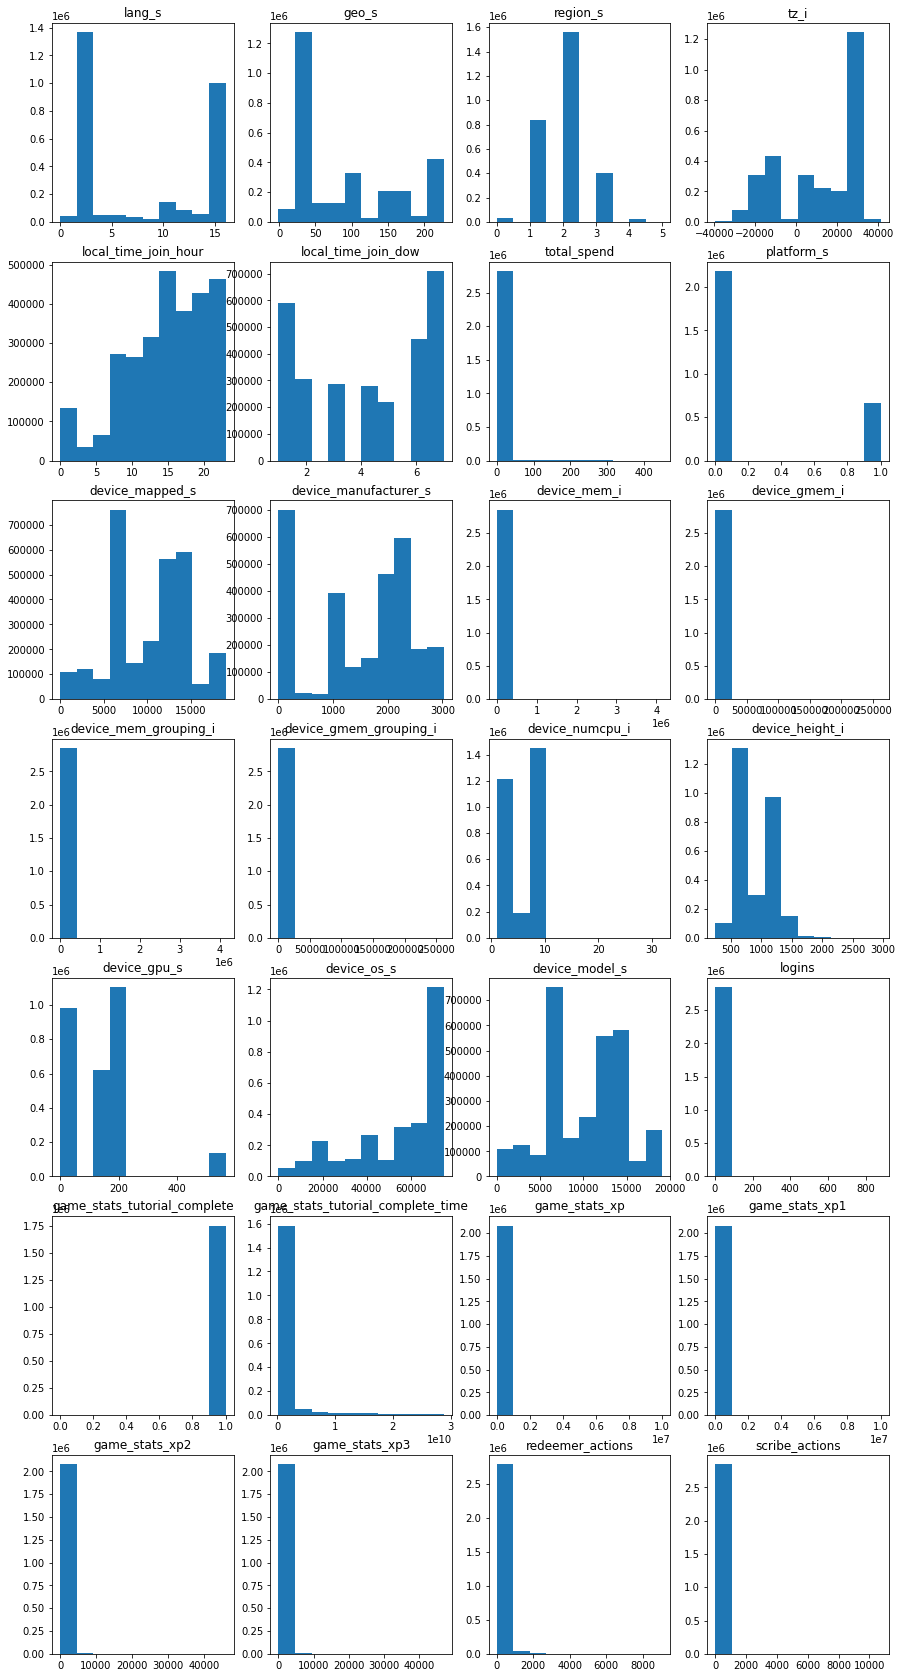

In [126]:
df = joined_df.copy()

columns = df.select_dtypes(['object']).columns
for c in columns:
    df[c] = df[c].astype('category')
    df[c] = df[c].cat.codes



columns = df.drop('uid_s', axis=1).columns

ncols = 4
nrows = int(np.ceil(len(columns) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 30))

row = 0
col = 0
for c in columns:
    axes[row, col].hist(df[c])
    axes[row, col].set_title(c)
    
    col = int((col + 1) % ncols)
    if col == 0:
        row += 1
        

In [127]:
for c in joined_df.columns:
    print(c, joined_df[c].mode().values)

uid_s [      0       1       2 ... 2845928 2845929 2845930]
lang_s ['EN']
geo_s ['CN']
region_s ['asia']
tz_i [28800]
local_time_join_hour [20]
local_time_join_dow [7]
total_spend [0]
platform_s ['android']
device_mapped_s ['iphone8,1']
device_manufacturer_s ['apple']
device_mem_i [2002.]
device_gmem_i [1024.]
device_mem_grouping_i [2048.]
device_gmem_grouping_i [1024.]
device_numcpu_i [8.]
device_height_i [1080.]
device_gpu_s ['adreno (tm) 506']
device_os_s ['ios 12.2']
device_model_s ['iphone8,1']
logins [2.]
game_stats_tutorial_complete [1.]
game_stats_tutorial_complete_time [5.09e+08]
game_stats_xp [80.]
game_stats_xp1 [80.]
game_stats_xp2 [0.]
game_stats_xp3 [0.]
redeemer_actions [12.]
scribe_actions [7.]


## Data Tranformations

Given the problem to identify users that spent at all, we need to turn the total_spend field into a binary field, where the two categories mean "spent nothing" and "spent anything more than 0".

In [128]:
joined_df['did_spend'] = joined_df['total_spend'].apply(lambda x: 1 if x > 0 else 0)

joined_df[['did_spend', 'uid_s']].groupby('did_spend').count()

,uid_s
did_spend,
0,2813535
1,32396


Although the following assumptions would ideally be tested or verified with other teams, I will not test them to save time:

* device_mem_i does not provide more information than device_mem_grouping_i
* The same for device_gmem_i and device_gmem_grouping_i
* The same for device_model_s and device_mapped_s
* device_os_s is less effective than just the base OS, so for example the entry "android os 9 / api-28 (ww_phone-201905061022/1.." will be converted to "android os 9 "
* The base OS is always the value before "/" in device_os_s
* Whenever game_stats_tutorial_complete is missing, the user did not complete the tutorial 
* Whenever game_stats_xp[...] is missing, the user achieved 0 xp[...]
* A missing value for every other column will be replaced with the most common value of that column. I'm not using the average or median for numeric fields simply for simplicity 
* The language itself doesn't provide information, just whether it is the most common language for that country

In [129]:
joined_df['base_os'] = joined_df['device_os_s'].apply(lambda x: None if x is None else x.split('/')[0])

In [130]:
joined_df['game_stats_tutorial_complete'].unique()

array([ 1., nan,  0.])

In [131]:
joined_df[joined_df['game_stats_tutorial_complete'] == 0]['game_stats_tutorial_complete_time'].head()

179    NaN
695    NaN
761    NaN
1005   NaN
1060   NaN
Name: game_stats_tutorial_complete_time, dtype: float64

In [132]:
joined_df['game_stats_tutorial_complete'] = joined_df['game_stats_tutorial_complete'].fillna(0)
joined_df['game_stats_tutorial_complete'].unique()

array([1., 0.])

In [133]:
joined_df['game_stats_tutorial_complete_time'] = joined_df['game_stats_tutorial_complete_time'].fillna(-1)


In [134]:
for c in ['game_stats_xp',
          'game_stats_xp1',
          'game_stats_xp2',
          'game_stats_xp3']:
    joined_df[c] = joined_df[c].fillna(0)

In [135]:
for c in joined_df.columns:
    mode = joined_df[c].mode().values[0]
    
    joined_df[c] = joined_df[c].fillna(mode)

In [137]:
most_common_language = {}
for country, group_df in joined_df.groupby('geo_s'):
    most_common_language[country] = group_df['lang_s'].mode()[0] #if multiple values are the mode, just take the first for simplicity
    
joined_df['is_mode_language'] = joined_df[['geo_s', 'lang_s']].apply(lambda row: 1 if most_common_language[row['geo_s']] == row['lang_s'] else 0,
                                               axis=1)

### Drop unneded columns

In [138]:
final_df = joined_df.drop(['lang_s',
                          'device_mem_i',
                          'device_gmem_i',
                          'device_model_s',
                          'device_os_s',
                           'total_spend',
                          ],
                         axis=1)

final_df.head()

,uid_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,platform_s,device_mapped_s,device_manufacturer_s,device_mem_grouping_i,...,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,did_spend,base_os,is_mode_language
0,0,MY,asia,28800,14,3,android,asus_x01ad,asus,3584.0,...,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0,0,android os 9,1
1,1,MX,americas,-18000,14,1,android,moto g (5),motorola,1920.0,...,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0,0,android os 8.1.0,1
2,2,CN,asia,28800,2,3,android,mi 6,xiaomi,3776.0,...,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0,0,android os 8.0.0,1
3,3,CN,asia,28800,8,6,android,oppo r7splus,oppo,3648.0,...,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0,0,android os 5.1.1,1
4,4,IN,asia,19800,19,6,android,cph1803,oppo,2816.0,...,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0,0,android os 8.1.0,1


In [139]:
final_df.columns

Index(['uid_s', 'geo_s', 'region_s', 'tz_i', 'local_time_join_hour',
       'local_time_join_dow', 'platform_s', 'device_mapped_s',
       'device_manufacturer_s', 'device_mem_grouping_i',
       'device_gmem_grouping_i', 'device_numcpu_i', 'device_height_i',
       'device_gpu_s', 'logins', 'game_stats_tutorial_complete',
       'game_stats_tutorial_complete_time', 'game_stats_xp', 'game_stats_xp1',
       'game_stats_xp2', 'game_stats_xp3', 'redeemer_actions',
       'scribe_actions', 'did_spend', 'base_os', 'is_mode_language'],
      dtype='object')

In [140]:
final_df.count()

uid_s                                2845931
geo_s                                2845931
region_s                             2845931
tz_i                                 2845931
local_time_join_hour                 2845931
local_time_join_dow                  2845931
platform_s                           2845931
device_mapped_s                      2845931
device_manufacturer_s                2845931
device_mem_grouping_i                2845931
device_gmem_grouping_i               2845931
device_numcpu_i                      2845931
device_height_i                      2845931
device_gpu_s                         2845931
logins                               2845931
game_stats_tutorial_complete         2845931
game_stats_tutorial_complete_time    2845931
game_stats_xp                        2845931
game_stats_xp1                       2845931
game_stats_xp2                       2845931
game_stats_xp3                       2845931
redeemer_actions                     2845931
scribe_act

so now no values are missing

## Tune parameters


Ideally, I would test different models, but to save time I will just go with Catboost and do some (but not much) parameter tuning

In [198]:
all_features = final_df.drop(['uid_s', 'did_spend'], axis=1)

target = final_df[['did_spend']]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_features, target, test_size=0.6)
# Use a large test size only to speed up training (you might not do that in the real world)

In [199]:
cat_columns = []
for c in X_train.columns:
    if X_train[c].dtype == 'O':
        cat_columns.append(c)

In [200]:
cat_columns

['geo_s',
 'region_s',
 'platform_s',
 'device_mapped_s',
 'device_manufacturer_s',
 'device_gpu_s',
 'base_os']

### Test different balancing approaches

The classes ("did spend" or "did not spend") are imbalanced. There are likely more effective ways of balancing, like SMOTE sampling, but for simplicity I will test 3 methods: doing nothing, a combination of downsampling the not-spending examples and upsampling the others, and the using the auto_class_weights parameter

In [202]:
class_counts = joined_df[['did_spend', 'uid_s']].groupby('did_spend').count().reset_index()

weights = [1.0, class_counts[class_counts['did_spend'] == 0]['uid_s'].values[0] / class_counts[class_counts['did_spend'] == 1]['uid_s'].values[0]]
weights = np.array(weights) / 2


indices = []

indices += random.sample(list(y_train[y_train['did_spend'] == 0].index), k=int(len(y_train.index) * weights[0]))

for i in y_train[y_train['did_spend'] == 1].index:
    indices += [i] * random.randint(0, int(weights[1]))

X_balanced = X_train.loc[indices]
y_balanced = y_train.loc[indices]

In [192]:

model = catboost.CatBoostClassifier(iterations=300,
                                    cat_features=cat_columns)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = sklearn.metrics.f1_score(y_test, predictions)

model = catboost.CatBoostClassifier(iterations=300,
                                    auto_class_weights='Balanced',
                                                cat_features=cat_columns)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
score_weighted = sklearn.metrics.f1_score(y_test, predictions)

model = catboost.CatBoostClassifier(iterations=300,
                                    cat_features=cat_columns)
model.fit(X_balanced, y_balanced)
predictions = model.predict(X_test)
score_balanced = sklearn.metrics.f1_score(y_test, predictions)

print('')
print(score, score_weighted, score_balanced)

Learning rate set to 0.5
0:	learn: 0.1114728	total: 808ms	remaining: 4m 1s
1:	learn: 0.0612627	total: 1.61s	remaining: 3m 59s
2:	learn: 0.0526369	total: 2.57s	remaining: 4m 14s
3:	learn: 0.0510846	total: 3.47s	remaining: 4m 16s
4:	learn: 0.0496154	total: 4.35s	remaining: 4m 16s
5:	learn: 0.0492824	total: 5.26s	remaining: 4m 17s
6:	learn: 0.0491013	total: 6.15s	remaining: 4m 17s
7:	learn: 0.0484881	total: 7.06s	remaining: 4m 17s
8:	learn: 0.0481650	total: 8.03s	remaining: 4m 19s
9:	learn: 0.0479370	total: 8.85s	remaining: 4m 16s
10:	learn: 0.0478387	total: 9.71s	remaining: 4m 14s
11:	learn: 0.0475680	total: 10.8s	remaining: 4m 18s
12:	learn: 0.0475018	total: 11.6s	remaining: 4m 15s
13:	learn: 0.0474623	total: 12.5s	remaining: 4m 15s
14:	learn: 0.0473505	total: 13.5s	remaining: 4m 15s
15:	learn: 0.0472634	total: 14.4s	remaining: 4m 15s
16:	learn: 0.0470402	total: 15.3s	remaining: 4m 14s
17:	learn: 0.0469672	total: 16.4s	remaining: 4m 16s
18:	learn: 0.0469262	total: 17.3s	remaining: 4m 15

156:	learn: 0.0435299	total: 2m 31s	remaining: 2m 17s
157:	learn: 0.0434966	total: 2m 32s	remaining: 2m 16s
158:	learn: 0.0434928	total: 2m 33s	remaining: 2m 15s
159:	learn: 0.0434864	total: 2m 33s	remaining: 2m 14s
160:	learn: 0.0434748	total: 2m 34s	remaining: 2m 13s
161:	learn: 0.0434660	total: 2m 35s	remaining: 2m 12s
162:	learn: 0.0434594	total: 2m 36s	remaining: 2m 11s
163:	learn: 0.0434451	total: 2m 37s	remaining: 2m 10s
164:	learn: 0.0434370	total: 2m 38s	remaining: 2m 9s
165:	learn: 0.0434278	total: 2m 39s	remaining: 2m 8s
166:	learn: 0.0434064	total: 2m 40s	remaining: 2m 7s
167:	learn: 0.0434001	total: 2m 41s	remaining: 2m 6s
168:	learn: 0.0433828	total: 2m 42s	remaining: 2m 6s
169:	learn: 0.0433683	total: 2m 43s	remaining: 2m 5s
170:	learn: 0.0433566	total: 2m 44s	remaining: 2m 4s
171:	learn: 0.0433559	total: 2m 45s	remaining: 2m 3s
172:	learn: 0.0433504	total: 2m 46s	remaining: 2m 2s
173:	learn: 0.0433448	total: 2m 47s	remaining: 2m 1s
174:	learn: 0.0433400	total: 2m 48s	re

11:	learn: 0.4120078	total: 13s	remaining: 5m 11s
12:	learn: 0.4104945	total: 14s	remaining: 5m 8s
13:	learn: 0.4083687	total: 14.4s	remaining: 4m 55s
14:	learn: 0.4076944	total: 15.3s	remaining: 4m 51s
15:	learn: 0.4072873	total: 15.9s	remaining: 4m 41s
16:	learn: 0.4057284	total: 16.8s	remaining: 4m 39s
17:	learn: 0.4053466	total: 17.4s	remaining: 4m 32s
18:	learn: 0.4036670	total: 18.3s	remaining: 4m 30s
19:	learn: 0.4026295	total: 19.2s	remaining: 4m 28s
20:	learn: 0.4015854	total: 20.1s	remaining: 4m 27s
21:	learn: 0.4011490	total: 21s	remaining: 4m 25s
22:	learn: 0.4008534	total: 21.5s	remaining: 4m 18s
23:	learn: 0.3994852	total: 22.4s	remaining: 4m 17s
24:	learn: 0.3984808	total: 23.5s	remaining: 4m 18s
25:	learn: 0.3981826	total: 24.2s	remaining: 4m 15s
26:	learn: 0.3978730	total: 25.2s	remaining: 4m 14s
27:	learn: 0.3972610	total: 26.1s	remaining: 4m 13s
28:	learn: 0.3964797	total: 27.2s	remaining: 4m 14s
29:	learn: 0.3950701	total: 28.2s	remaining: 4m 14s
30:	learn: 0.393894

167:	learn: 0.3405492	total: 2m 45s	remaining: 2m 10s
168:	learn: 0.3404039	total: 2m 46s	remaining: 2m 9s
169:	learn: 0.3401423	total: 2m 47s	remaining: 2m 8s
170:	learn: 0.3399193	total: 2m 48s	remaining: 2m 7s
171:	learn: 0.3396107	total: 2m 49s	remaining: 2m 6s
172:	learn: 0.3392725	total: 2m 50s	remaining: 2m 5s
173:	learn: 0.3390456	total: 2m 51s	remaining: 2m 4s
174:	learn: 0.3388516	total: 2m 52s	remaining: 2m 3s
175:	learn: 0.3386859	total: 2m 53s	remaining: 2m 2s
176:	learn: 0.3383623	total: 2m 54s	remaining: 2m 1s
177:	learn: 0.3379961	total: 2m 55s	remaining: 2m
178:	learn: 0.3378420	total: 2m 56s	remaining: 1m 59s
179:	learn: 0.3375414	total: 2m 57s	remaining: 1m 58s
180:	learn: 0.3373122	total: 2m 58s	remaining: 1m 57s
181:	learn: 0.3370870	total: 2m 59s	remaining: 1m 56s
182:	learn: 0.3369258	total: 3m	remaining: 1m 55s
183:	learn: 0.3367017	total: 3m 1s	remaining: 1m 54s
184:	learn: 0.3363532	total: 3m 2s	remaining: 1m 53s
185:	learn: 0.3359958	total: 3m 3s	remaining: 1

22:	learn: 0.2591631	total: 18.4s	remaining: 3m 41s
23:	learn: 0.2588303	total: 19.1s	remaining: 3m 40s
24:	learn: 0.2571694	total: 19.9s	remaining: 3m 39s
25:	learn: 0.2532901	total: 20.9s	remaining: 3m 39s
26:	learn: 0.2525894	total: 21.6s	remaining: 3m 38s
27:	learn: 0.2483276	total: 22.5s	remaining: 3m 38s
28:	learn: 0.2465415	total: 23.3s	remaining: 3m 37s
29:	learn: 0.2450254	total: 24.1s	remaining: 3m 37s
30:	learn: 0.2428376	total: 24.9s	remaining: 3m 36s
31:	learn: 0.2416298	total: 25.7s	remaining: 3m 34s
32:	learn: 0.2411739	total: 26.5s	remaining: 3m 34s
33:	learn: 0.2404051	total: 27.4s	remaining: 3m 34s
34:	learn: 0.2381367	total: 28.3s	remaining: 3m 34s
35:	learn: 0.2368517	total: 29.4s	remaining: 3m 35s
36:	learn: 0.2360200	total: 30.2s	remaining: 3m 34s
37:	learn: 0.2353973	total: 31s	remaining: 3m 33s
38:	learn: 0.2343738	total: 31.7s	remaining: 3m 32s
39:	learn: 0.2331249	total: 32.4s	remaining: 3m 30s
40:	learn: 0.2329152	total: 33.1s	remaining: 3m 29s
41:	learn: 0.2

178:	learn: 0.1635840	total: 2m 25s	remaining: 1m 38s
179:	learn: 0.1634237	total: 2m 26s	remaining: 1m 37s
180:	learn: 0.1634041	total: 2m 26s	remaining: 1m 36s
181:	learn: 0.1631960	total: 2m 27s	remaining: 1m 35s
182:	learn: 0.1628488	total: 2m 28s	remaining: 1m 34s
183:	learn: 0.1626586	total: 2m 29s	remaining: 1m 34s
184:	learn: 0.1625778	total: 2m 29s	remaining: 1m 33s
185:	learn: 0.1619296	total: 2m 30s	remaining: 1m 32s
186:	learn: 0.1617843	total: 2m 31s	remaining: 1m 31s
187:	learn: 0.1614615	total: 2m 32s	remaining: 1m 30s
188:	learn: 0.1611788	total: 2m 33s	remaining: 1m 29s
189:	learn: 0.1610444	total: 2m 33s	remaining: 1m 29s
190:	learn: 0.1609095	total: 2m 34s	remaining: 1m 28s
191:	learn: 0.1607259	total: 2m 35s	remaining: 1m 27s
192:	learn: 0.1606753	total: 2m 35s	remaining: 1m 26s
193:	learn: 0.1604665	total: 2m 36s	remaining: 1m 25s
194:	learn: 0.1603989	total: 2m 37s	remaining: 1m 24s
195:	learn: 0.1599806	total: 2m 38s	remaining: 1m 24s
196:	learn: 0.1598029	total:

So using the balanced dataset performed the best

### Hyperparameter tuning

There are better ways to tune (like using hyperopt) rather than just a grid-search, but for simplicity I will just use a grid search

In [203]:
train_count = 0

best_score = -1
best_model = None
best_i = 0
best_d = 0
best_l = 0
for i in [1000]: #if you were doing this for real, you would try more values
    for d in [10]: #if you were doing this for real, you would try more values
        for l in [1, 3, 6]:
            model = catboost.CatBoostClassifier(iterations=i,
                                                depth=d,
                                                l2_leaf_reg=l,
                                                cat_features=cat_columns)
            model.fit(X_balanced, y_balanced)

            predictions = model.predict(X_test)
            
            score = sklearn.metrics.f1_score(y_test, predictions)
            if score > best_score:
                best_score = score
                best_i = i
                best_d = d
                best_l = l
                best_model = model
                
            train_count += 1
            print('**************')
            print('Ieration', train_count)
            print('**************')
            

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6691327	total: 706ms	remaining: 11m 45s
1:	learn: 0.6459763	total: 1.36s	remaining: 11m 17s
2:	learn: 0.6263959	total: 1.97s	remaining: 10m 53s
3:	learn: 0.6061051	total: 2.57s	remaining: 10m 40s
4:	learn: 0.5883393	total: 3.17s	remaining: 10m 31s
5:	learn: 0.5724483	total: 3.88s	remaining: 10m 43s
6:	learn: 0.5570488	total: 4.44s	remaining: 10m 30s
7:	learn: 0.5423730	total: 5.11s	remaining: 10m 33s
8:	learn: 0.5297355	total: 5.73s	remaining: 10m 31s
9:	learn: 0.5183975	total: 6.39s	remaining: 10m 32s
10:	learn: 0.5079465	total: 6.99s	remaining: 10m 28s
11:	learn: 0.4985935	total: 7.61s	remaining: 10m 26s
12:	learn: 0.4900168	total: 8.24s	remaining: 10m 25s
13:	learn: 0.4822075	total: 8.91s	remaining: 10m 27s
14:	learn: 0.4752384	total: 9.56s	remaining: 10m 27s
15:	learn: 0.4686027	total: 10.3s	remaining: 10m 31s
16:	learn: 0.4623876	total: 11s	remaining: 10m 33s
17:	learn: 0.4568146	total: 11.7s	remaining: 10m 36s
18:	learn: 0.4511954	total: 12.3s	remaining: 10m 37s
19:	l

154:	learn: 0.2199753	total: 2m 3s	remaining: 11m 15s
155:	learn: 0.2193833	total: 2m 4s	remaining: 11m 14s
156:	learn: 0.2188817	total: 2m 5s	remaining: 11m 14s
157:	learn: 0.2185891	total: 2m 6s	remaining: 11m 13s
158:	learn: 0.2182233	total: 2m 7s	remaining: 11m 12s
159:	learn: 0.2179148	total: 2m 8s	remaining: 11m 12s
160:	learn: 0.2175159	total: 2m 8s	remaining: 11m 11s
161:	learn: 0.2170844	total: 2m 9s	remaining: 11m 10s
162:	learn: 0.2165618	total: 2m 10s	remaining: 11m 9s
163:	learn: 0.2163181	total: 2m 11s	remaining: 11m 9s
164:	learn: 0.2159716	total: 2m 12s	remaining: 11m 9s
165:	learn: 0.2157307	total: 2m 12s	remaining: 11m 8s
166:	learn: 0.2149615	total: 2m 13s	remaining: 11m 7s
167:	learn: 0.2147535	total: 2m 14s	remaining: 11m 7s
168:	learn: 0.2142277	total: 2m 15s	remaining: 11m 6s
169:	learn: 0.2139342	total: 2m 16s	remaining: 11m 5s
170:	learn: 0.2134844	total: 2m 17s	remaining: 11m 5s
171:	learn: 0.2129359	total: 2m 18s	remaining: 11m 4s
172:	learn: 0.2125835	total:

305:	learn: 0.1798981	total: 4m 19s	remaining: 9m 48s
306:	learn: 0.1797263	total: 4m 20s	remaining: 9m 47s
307:	learn: 0.1796331	total: 4m 21s	remaining: 9m 47s
308:	learn: 0.1790669	total: 4m 22s	remaining: 9m 46s
309:	learn: 0.1789968	total: 4m 23s	remaining: 9m 45s
310:	learn: 0.1788113	total: 4m 24s	remaining: 9m 45s
311:	learn: 0.1785565	total: 4m 24s	remaining: 9m 44s
312:	learn: 0.1784408	total: 4m 25s	remaining: 9m 43s
313:	learn: 0.1781420	total: 4m 26s	remaining: 9m 42s
314:	learn: 0.1777201	total: 4m 27s	remaining: 9m 42s
315:	learn: 0.1775465	total: 4m 28s	remaining: 9m 41s
316:	learn: 0.1773847	total: 4m 29s	remaining: 9m 41s
317:	learn: 0.1772824	total: 4m 30s	remaining: 9m 40s
318:	learn: 0.1772094	total: 4m 31s	remaining: 9m 39s
319:	learn: 0.1768775	total: 4m 32s	remaining: 9m 38s
320:	learn: 0.1767196	total: 4m 33s	remaining: 9m 37s
321:	learn: 0.1766667	total: 4m 34s	remaining: 9m 37s
322:	learn: 0.1765731	total: 4m 34s	remaining: 9m 36s
323:	learn: 0.1763659	total:

458:	learn: 0.1550133	total: 6m 35s	remaining: 7m 46s
459:	learn: 0.1548751	total: 6m 36s	remaining: 7m 45s
460:	learn: 0.1546168	total: 6m 37s	remaining: 7m 44s
461:	learn: 0.1545183	total: 6m 38s	remaining: 7m 43s
462:	learn: 0.1544153	total: 6m 39s	remaining: 7m 42s
463:	learn: 0.1542466	total: 6m 39s	remaining: 7m 42s
464:	learn: 0.1540845	total: 6m 40s	remaining: 7m 41s
465:	learn: 0.1538889	total: 6m 41s	remaining: 7m 40s
466:	learn: 0.1537598	total: 6m 42s	remaining: 7m 39s
467:	learn: 0.1537482	total: 6m 43s	remaining: 7m 38s
468:	learn: 0.1536501	total: 6m 44s	remaining: 7m 37s
469:	learn: 0.1535172	total: 6m 45s	remaining: 7m 36s
470:	learn: 0.1533930	total: 6m 45s	remaining: 7m 35s
471:	learn: 0.1532461	total: 6m 46s	remaining: 7m 34s
472:	learn: 0.1530482	total: 6m 47s	remaining: 7m 34s
473:	learn: 0.1528233	total: 6m 48s	remaining: 7m 33s
474:	learn: 0.1527252	total: 6m 49s	remaining: 7m 32s
475:	learn: 0.1526600	total: 6m 50s	remaining: 7m 31s
476:	learn: 0.1525629	total:

611:	learn: 0.1356355	total: 8m 47s	remaining: 5m 34s
612:	learn: 0.1354217	total: 8m 48s	remaining: 5m 33s
613:	learn: 0.1352969	total: 8m 49s	remaining: 5m 33s
614:	learn: 0.1351673	total: 8m 50s	remaining: 5m 32s
615:	learn: 0.1351382	total: 8m 51s	remaining: 5m 31s
616:	learn: 0.1350067	total: 8m 52s	remaining: 5m 30s
617:	learn: 0.1349284	total: 8m 53s	remaining: 5m 29s
618:	learn: 0.1347685	total: 8m 54s	remaining: 5m 28s
619:	learn: 0.1346717	total: 8m 55s	remaining: 5m 27s
620:	learn: 0.1345747	total: 8m 55s	remaining: 5m 27s
621:	learn: 0.1344487	total: 8m 56s	remaining: 5m 26s
622:	learn: 0.1343602	total: 8m 57s	remaining: 5m 25s
623:	learn: 0.1342390	total: 8m 58s	remaining: 5m 24s
624:	learn: 0.1341938	total: 8m 59s	remaining: 5m 23s
625:	learn: 0.1340034	total: 9m	remaining: 5m 22s
626:	learn: 0.1339146	total: 9m 1s	remaining: 5m 22s
627:	learn: 0.1338608	total: 9m 2s	remaining: 5m 21s
628:	learn: 0.1338153	total: 9m 3s	remaining: 5m 20s
629:	learn: 0.1337430	total: 9m 4s	

763:	learn: 0.1216552	total: 11m 1s	remaining: 3m 24s
764:	learn: 0.1215488	total: 11m 2s	remaining: 3m 23s
765:	learn: 0.1214264	total: 11m 3s	remaining: 3m 22s
766:	learn: 0.1213739	total: 11m 4s	remaining: 3m 21s
767:	learn: 0.1211614	total: 11m 5s	remaining: 3m 20s
768:	learn: 0.1210163	total: 11m 5s	remaining: 3m 20s
769:	learn: 0.1209749	total: 11m 6s	remaining: 3m 19s
770:	learn: 0.1208744	total: 11m 7s	remaining: 3m 18s
771:	learn: 0.1208065	total: 11m 8s	remaining: 3m 17s
772:	learn: 0.1207763	total: 11m 9s	remaining: 3m 16s
773:	learn: 0.1207351	total: 11m 10s	remaining: 3m 15s
774:	learn: 0.1206782	total: 11m 10s	remaining: 3m 14s
775:	learn: 0.1206411	total: 11m 11s	remaining: 3m 13s
776:	learn: 0.1206134	total: 11m 12s	remaining: 3m 13s
777:	learn: 0.1205671	total: 11m 13s	remaining: 3m 12s
778:	learn: 0.1205188	total: 11m 14s	remaining: 3m 11s
779:	learn: 0.1204660	total: 11m 15s	remaining: 3m 10s
780:	learn: 0.1203710	total: 11m 16s	remaining: 3m 9s
781:	learn: 0.1203019

914:	learn: 0.1113027	total: 13m 12s	remaining: 1m 13s
915:	learn: 0.1112499	total: 13m 13s	remaining: 1m 12s
916:	learn: 0.1112287	total: 13m 14s	remaining: 1m 11s
917:	learn: 0.1112094	total: 13m 14s	remaining: 1m 11s
918:	learn: 0.1111282	total: 13m 15s	remaining: 1m 10s
919:	learn: 0.1110305	total: 13m 16s	remaining: 1m 9s
920:	learn: 0.1110059	total: 13m 17s	remaining: 1m 8s
921:	learn: 0.1109637	total: 13m 18s	remaining: 1m 7s
922:	learn: 0.1107920	total: 13m 19s	remaining: 1m 6s
923:	learn: 0.1106974	total: 13m 20s	remaining: 1m 5s
924:	learn: 0.1106143	total: 13m 21s	remaining: 1m 4s
925:	learn: 0.1105565	total: 13m 22s	remaining: 1m 4s
926:	learn: 0.1105221	total: 13m 22s	remaining: 1m 3s
927:	learn: 0.1104570	total: 13m 23s	remaining: 1m 2s
928:	learn: 0.1103530	total: 13m 24s	remaining: 1m 1s
929:	learn: 0.1102722	total: 13m 25s	remaining: 1m
930:	learn: 0.1102461	total: 13m 26s	remaining: 59.8s
931:	learn: 0.1101926	total: 13m 27s	remaining: 58.9s
932:	learn: 0.1101353	tota

68:	learn: 0.2952093	total: 51.9s	remaining: 11m 40s
69:	learn: 0.2927358	total: 52.7s	remaining: 11m 40s
70:	learn: 0.2914407	total: 53.5s	remaining: 11m 40s
71:	learn: 0.2907009	total: 54.2s	remaining: 11m 38s
72:	learn: 0.2895307	total: 55s	remaining: 11m 38s
73:	learn: 0.2878950	total: 55.8s	remaining: 11m 38s
74:	learn: 0.2862144	total: 56.7s	remaining: 11m 39s
75:	learn: 0.2851922	total: 57.5s	remaining: 11m 39s
76:	learn: 0.2842828	total: 58.3s	remaining: 11m 38s
77:	learn: 0.2830982	total: 59.2s	remaining: 11m 39s
78:	learn: 0.2817923	total: 1m	remaining: 11m 39s
79:	learn: 0.2803246	total: 1m	remaining: 11m 39s
80:	learn: 0.2787349	total: 1m 1s	remaining: 11m 40s
81:	learn: 0.2769580	total: 1m 2s	remaining: 11m 40s
82:	learn: 0.2754817	total: 1m 3s	remaining: 11m 42s
83:	learn: 0.2744727	total: 1m 4s	remaining: 11m 40s
84:	learn: 0.2734292	total: 1m 5s	remaining: 11m 40s
85:	learn: 0.2721982	total: 1m 5s	remaining: 11m 40s
86:	learn: 0.2709296	total: 1m 6s	remaining: 11m 40s
8

219:	learn: 0.2034646	total: 2m 57s	remaining: 10m 30s
220:	learn: 0.2033248	total: 2m 58s	remaining: 10m 30s
221:	learn: 0.2030811	total: 2m 59s	remaining: 10m 29s
222:	learn: 0.2028382	total: 3m	remaining: 10m 28s
223:	learn: 0.2025908	total: 3m 1s	remaining: 10m 28s
224:	learn: 0.2022845	total: 3m 2s	remaining: 10m 27s
225:	learn: 0.2019193	total: 3m 3s	remaining: 10m 27s
226:	learn: 0.2016873	total: 3m 3s	remaining: 10m 26s
227:	learn: 0.2015621	total: 3m 4s	remaining: 10m 25s
228:	learn: 0.2014767	total: 3m 5s	remaining: 10m 25s
229:	learn: 0.2010107	total: 3m 6s	remaining: 10m 24s
230:	learn: 0.2008656	total: 3m 7s	remaining: 10m 24s
231:	learn: 0.2004707	total: 3m 8s	remaining: 10m 23s
232:	learn: 0.2003449	total: 3m 9s	remaining: 10m 22s
233:	learn: 0.2001257	total: 3m 10s	remaining: 10m 22s
234:	learn: 0.1998267	total: 3m 10s	remaining: 10m 21s
235:	learn: 0.1996839	total: 3m 11s	remaining: 10m 21s
236:	learn: 0.1994490	total: 3m 12s	remaining: 10m 20s
237:	learn: 0.1990100	to

372:	learn: 0.1689849	total: 5m 11s	remaining: 8m 43s
373:	learn: 0.1688333	total: 5m 12s	remaining: 8m 42s
374:	learn: 0.1687002	total: 5m 13s	remaining: 8m 41s
375:	learn: 0.1686251	total: 5m 13s	remaining: 8m 40s
376:	learn: 0.1684710	total: 5m 14s	remaining: 8m 40s
377:	learn: 0.1683322	total: 5m 15s	remaining: 8m 39s
378:	learn: 0.1681930	total: 5m 16s	remaining: 8m 39s
379:	learn: 0.1681338	total: 5m 17s	remaining: 8m 38s
380:	learn: 0.1679816	total: 5m 18s	remaining: 8m 37s
381:	learn: 0.1677953	total: 5m 19s	remaining: 8m 36s
382:	learn: 0.1673461	total: 5m 20s	remaining: 8m 36s
383:	learn: 0.1672006	total: 5m 21s	remaining: 8m 35s
384:	learn: 0.1669745	total: 5m 21s	remaining: 8m 34s
385:	learn: 0.1668447	total: 5m 22s	remaining: 8m 33s
386:	learn: 0.1667489	total: 5m 23s	remaining: 8m 32s
387:	learn: 0.1666245	total: 5m 24s	remaining: 8m 31s
388:	learn: 0.1664204	total: 5m 25s	remaining: 8m 31s
389:	learn: 0.1663267	total: 5m 26s	remaining: 8m 30s
390:	learn: 0.1661309	total:

525:	learn: 0.1480771	total: 7m 25s	remaining: 6m 41s
526:	learn: 0.1479440	total: 7m 26s	remaining: 6m 40s
527:	learn: 0.1478032	total: 7m 27s	remaining: 6m 40s
528:	learn: 0.1476724	total: 7m 28s	remaining: 6m 39s
529:	learn: 0.1475598	total: 7m 29s	remaining: 6m 38s
530:	learn: 0.1474678	total: 7m 30s	remaining: 6m 37s
531:	learn: 0.1473939	total: 7m 31s	remaining: 6m 36s
532:	learn: 0.1473081	total: 7m 32s	remaining: 6m 36s
533:	learn: 0.1471628	total: 7m 33s	remaining: 6m 35s
534:	learn: 0.1470447	total: 7m 33s	remaining: 6m 34s
535:	learn: 0.1468655	total: 7m 34s	remaining: 6m 33s
536:	learn: 0.1467772	total: 7m 35s	remaining: 6m 32s
537:	learn: 0.1466857	total: 7m 36s	remaining: 6m 32s
538:	learn: 0.1465879	total: 7m 37s	remaining: 6m 31s
539:	learn: 0.1465044	total: 7m 38s	remaining: 6m 30s
540:	learn: 0.1464280	total: 7m 39s	remaining: 6m 29s
541:	learn: 0.1462860	total: 7m 40s	remaining: 6m 28s
542:	learn: 0.1461945	total: 7m 40s	remaining: 6m 27s
543:	learn: 0.1458567	total:

678:	learn: 0.1322001	total: 9m 40s	remaining: 4m 34s
679:	learn: 0.1321446	total: 9m 41s	remaining: 4m 33s
680:	learn: 0.1320682	total: 9m 41s	remaining: 4m 32s
681:	learn: 0.1318660	total: 9m 42s	remaining: 4m 31s
682:	learn: 0.1317720	total: 9m 43s	remaining: 4m 30s
683:	learn: 0.1317373	total: 9m 44s	remaining: 4m 30s
684:	learn: 0.1316662	total: 9m 45s	remaining: 4m 29s
685:	learn: 0.1316307	total: 9m 46s	remaining: 4m 28s
686:	learn: 0.1316160	total: 9m 47s	remaining: 4m 27s
687:	learn: 0.1315902	total: 9m 47s	remaining: 4m 26s
688:	learn: 0.1315537	total: 9m 48s	remaining: 4m 25s
689:	learn: 0.1315084	total: 9m 49s	remaining: 4m 24s
690:	learn: 0.1314471	total: 9m 50s	remaining: 4m 24s
691:	learn: 0.1313902	total: 9m 51s	remaining: 4m 23s
692:	learn: 0.1313376	total: 9m 52s	remaining: 4m 22s
693:	learn: 0.1313047	total: 9m 53s	remaining: 4m 21s
694:	learn: 0.1312130	total: 9m 54s	remaining: 4m 20s
695:	learn: 0.1311251	total: 9m 54s	remaining: 4m 19s
696:	learn: 0.1310485	total:

829:	learn: 0.1200006	total: 11m 54s	remaining: 2m 26s
830:	learn: 0.1199361	total: 11m 55s	remaining: 2m 25s
831:	learn: 0.1197320	total: 11m 56s	remaining: 2m 24s
832:	learn: 0.1196733	total: 11m 56s	remaining: 2m 23s
833:	learn: 0.1196404	total: 11m 57s	remaining: 2m 22s
834:	learn: 0.1195459	total: 11m 58s	remaining: 2m 21s
835:	learn: 0.1194941	total: 11m 59s	remaining: 2m 21s
836:	learn: 0.1194236	total: 12m	remaining: 2m 20s
837:	learn: 0.1193463	total: 12m 1s	remaining: 2m 19s
838:	learn: 0.1193177	total: 12m 1s	remaining: 2m 18s
839:	learn: 0.1192632	total: 12m 2s	remaining: 2m 17s
840:	learn: 0.1191734	total: 12m 3s	remaining: 2m 16s
841:	learn: 0.1190738	total: 12m 4s	remaining: 2m 15s
842:	learn: 0.1188757	total: 12m 5s	remaining: 2m 15s
843:	learn: 0.1187712	total: 12m 6s	remaining: 2m 14s
844:	learn: 0.1187059	total: 12m 7s	remaining: 2m 13s
845:	learn: 0.1186452	total: 12m 8s	remaining: 2m 12s
846:	learn: 0.1186075	total: 12m 8s	remaining: 2m 11s
847:	learn: 0.1185496	to

981:	learn: 0.1091605	total: 14m 7s	remaining: 15.5s
982:	learn: 0.1091433	total: 14m 8s	remaining: 14.7s
983:	learn: 0.1091200	total: 14m 9s	remaining: 13.8s
984:	learn: 0.1090383	total: 14m 10s	remaining: 12.9s
985:	learn: 0.1090070	total: 14m 11s	remaining: 12.1s
986:	learn: 0.1089459	total: 14m 12s	remaining: 11.2s
987:	learn: 0.1089305	total: 14m 13s	remaining: 10.4s
988:	learn: 0.1089178	total: 14m 13s	remaining: 9.5s
989:	learn: 0.1088163	total: 14m 14s	remaining: 8.63s
990:	learn: 0.1087494	total: 14m 15s	remaining: 7.77s
991:	learn: 0.1086553	total: 14m 16s	remaining: 6.91s
992:	learn: 0.1085994	total: 14m 17s	remaining: 6.04s
993:	learn: 0.1085691	total: 14m 18s	remaining: 5.18s
994:	learn: 0.1085225	total: 14m 19s	remaining: 4.32s
995:	learn: 0.1084970	total: 14m 20s	remaining: 3.46s
996:	learn: 0.1084132	total: 14m 21s	remaining: 2.59s
997:	learn: 0.1083803	total: 14m 21s	remaining: 1.73s
998:	learn: 0.1083032	total: 14m 22s	remaining: 864ms
999:	learn: 0.1082604	total: 14m

134:	learn: 0.2340154	total: 1m 52s	remaining: 12m 4s
135:	learn: 0.2331870	total: 1m 53s	remaining: 12m 3s
136:	learn: 0.2327279	total: 1m 54s	remaining: 12m 2s
137:	learn: 0.2323541	total: 1m 55s	remaining: 12m 1s
138:	learn: 0.2319050	total: 1m 56s	remaining: 12m
139:	learn: 0.2315674	total: 1m 57s	remaining: 11m 59s
140:	learn: 0.2313054	total: 1m 57s	remaining: 11m 57s
141:	learn: 0.2308234	total: 1m 58s	remaining: 11m 56s
142:	learn: 0.2303632	total: 1m 59s	remaining: 11m 56s
143:	learn: 0.2300433	total: 2m	remaining: 11m 55s
144:	learn: 0.2295453	total: 2m 1s	remaining: 11m 54s
145:	learn: 0.2289317	total: 2m 1s	remaining: 11m 53s
146:	learn: 0.2286439	total: 2m 2s	remaining: 11m 52s
147:	learn: 0.2284578	total: 2m 3s	remaining: 11m 51s
148:	learn: 0.2282435	total: 2m 4s	remaining: 11m 50s
149:	learn: 0.2278615	total: 2m 5s	remaining: 11m 49s
150:	learn: 0.2273643	total: 2m 6s	remaining: 11m 48s
151:	learn: 0.2271557	total: 2m 6s	remaining: 11m 47s
152:	learn: 0.2268931	total: 2

285:	learn: 0.1896990	total: 4m 5s	remaining: 10m 12s
286:	learn: 0.1895012	total: 4m 6s	remaining: 10m 11s
287:	learn: 0.1892878	total: 4m 7s	remaining: 10m 11s
288:	learn: 0.1890698	total: 4m 8s	remaining: 10m 10s
289:	learn: 0.1888246	total: 4m 9s	remaining: 10m 9s
290:	learn: 0.1886524	total: 4m 10s	remaining: 10m 9s
291:	learn: 0.1884833	total: 4m 10s	remaining: 10m 8s
292:	learn: 0.1883145	total: 4m 11s	remaining: 10m 7s
293:	learn: 0.1881316	total: 4m 12s	remaining: 10m 6s
294:	learn: 0.1880458	total: 4m 13s	remaining: 10m 5s
295:	learn: 0.1878078	total: 4m 14s	remaining: 10m 5s
296:	learn: 0.1875376	total: 4m 15s	remaining: 10m 4s
297:	learn: 0.1871121	total: 4m 16s	remaining: 10m 3s
298:	learn: 0.1870286	total: 4m 17s	remaining: 10m 2s
299:	learn: 0.1868264	total: 4m 18s	remaining: 10m 2s
300:	learn: 0.1861753	total: 4m 18s	remaining: 10m 1s
301:	learn: 0.1857647	total: 4m 19s	remaining: 10m
302:	learn: 0.1855359	total: 4m 20s	remaining: 9m 59s
303:	learn: 0.1849139	total: 4m 

438:	learn: 0.1638938	total: 6m 21s	remaining: 8m 7s
439:	learn: 0.1638042	total: 6m 22s	remaining: 8m 6s
440:	learn: 0.1637308	total: 6m 23s	remaining: 8m 5s
441:	learn: 0.1636374	total: 6m 24s	remaining: 8m 4s
442:	learn: 0.1634769	total: 6m 25s	remaining: 8m 4s
443:	learn: 0.1633801	total: 6m 25s	remaining: 8m 3s
444:	learn: 0.1632511	total: 6m 26s	remaining: 8m 2s
445:	learn: 0.1629838	total: 6m 27s	remaining: 8m 1s
446:	learn: 0.1628357	total: 6m 28s	remaining: 8m
447:	learn: 0.1626232	total: 6m 29s	remaining: 8m
448:	learn: 0.1625397	total: 6m 30s	remaining: 7m 59s
449:	learn: 0.1623764	total: 6m 31s	remaining: 7m 58s
450:	learn: 0.1623114	total: 6m 32s	remaining: 7m 57s
451:	learn: 0.1621572	total: 6m 33s	remaining: 7m 56s
452:	learn: 0.1620131	total: 6m 34s	remaining: 7m 55s
453:	learn: 0.1618988	total: 6m 34s	remaining: 7m 54s
454:	learn: 0.1618246	total: 6m 35s	remaining: 7m 54s
455:	learn: 0.1615393	total: 6m 36s	remaining: 7m 53s
456:	learn: 0.1614445	total: 6m 37s	remainin

592:	learn: 0.1442606	total: 8m 40s	remaining: 5m 57s
593:	learn: 0.1440950	total: 8m 41s	remaining: 5m 56s
594:	learn: 0.1440448	total: 8m 42s	remaining: 5m 55s
595:	learn: 0.1439813	total: 8m 42s	remaining: 5m 54s
596:	learn: 0.1438504	total: 8m 43s	remaining: 5m 53s
597:	learn: 0.1437875	total: 8m 44s	remaining: 5m 52s
598:	learn: 0.1436834	total: 8m 45s	remaining: 5m 51s
599:	learn: 0.1436249	total: 8m 46s	remaining: 5m 50s
600:	learn: 0.1435706	total: 8m 47s	remaining: 5m 50s
601:	learn: 0.1435340	total: 8m 48s	remaining: 5m 49s
602:	learn: 0.1434163	total: 8m 48s	remaining: 5m 48s
603:	learn: 0.1433536	total: 8m 49s	remaining: 5m 47s
604:	learn: 0.1432623	total: 8m 50s	remaining: 5m 46s
605:	learn: 0.1431999	total: 8m 51s	remaining: 5m 45s
606:	learn: 0.1431344	total: 8m 52s	remaining: 5m 44s
607:	learn: 0.1429998	total: 8m 53s	remaining: 5m 43s
608:	learn: 0.1429454	total: 8m 53s	remaining: 5m 42s
609:	learn: 0.1428317	total: 8m 54s	remaining: 5m 41s
610:	learn: 0.1427690	total:

744:	learn: 0.1303024	total: 10m 56s	remaining: 3m 44s
745:	learn: 0.1302239	total: 10m 56s	remaining: 3m 43s
746:	learn: 0.1301748	total: 10m 57s	remaining: 3m 42s
747:	learn: 0.1301586	total: 10m 58s	remaining: 3m 41s
748:	learn: 0.1300003	total: 10m 59s	remaining: 3m 40s
749:	learn: 0.1299759	total: 11m	remaining: 3m 40s
750:	learn: 0.1299094	total: 11m 1s	remaining: 3m 39s
751:	learn: 0.1296726	total: 11m 2s	remaining: 3m 38s
752:	learn: 0.1296399	total: 11m 2s	remaining: 3m 37s
753:	learn: 0.1295578	total: 11m 3s	remaining: 3m 36s
754:	learn: 0.1294994	total: 11m 4s	remaining: 3m 35s
755:	learn: 0.1293853	total: 11m 5s	remaining: 3m 34s
756:	learn: 0.1292999	total: 11m 6s	remaining: 3m 33s
757:	learn: 0.1292670	total: 11m 7s	remaining: 3m 33s
758:	learn: 0.1292158	total: 11m 8s	remaining: 3m 32s
759:	learn: 0.1291525	total: 11m 9s	remaining: 3m 31s
760:	learn: 0.1290531	total: 11m 9s	remaining: 3m 30s
761:	learn: 0.1290143	total: 11m 10s	remaining: 3m 29s
762:	learn: 0.1288901	tot

895:	learn: 0.1194879	total: 13m 8s	remaining: 1m 31s
896:	learn: 0.1193829	total: 13m 9s	remaining: 1m 30s
897:	learn: 0.1193220	total: 13m 10s	remaining: 1m 29s
898:	learn: 0.1191911	total: 13m 11s	remaining: 1m 28s
899:	learn: 0.1191381	total: 13m 12s	remaining: 1m 28s
900:	learn: 0.1191130	total: 13m 13s	remaining: 1m 27s
901:	learn: 0.1190760	total: 13m 14s	remaining: 1m 26s
902:	learn: 0.1190232	total: 13m 15s	remaining: 1m 25s
903:	learn: 0.1189614	total: 13m 16s	remaining: 1m 24s
904:	learn: 0.1189467	total: 13m 17s	remaining: 1m 23s
905:	learn: 0.1188728	total: 13m 18s	remaining: 1m 22s
906:	learn: 0.1187438	total: 13m 19s	remaining: 1m 21s
907:	learn: 0.1186884	total: 13m 20s	remaining: 1m 21s
908:	learn: 0.1185842	total: 13m 21s	remaining: 1m 20s
909:	learn: 0.1185422	total: 13m 22s	remaining: 1m 19s
910:	learn: 0.1184377	total: 13m 23s	remaining: 1m 18s
911:	learn: 0.1183468	total: 13m 23s	remaining: 1m 17s
912:	learn: 0.1182864	total: 13m 24s	remaining: 1m 16s
913:	learn: 

In [204]:
print('Best score:', best_score) 
print('Best i, d, l:', 
      best_i ,
      best_d,
      best_l)

Best score: 0.16417626085299802
Best i, d, l: 1000 10 3


## Test excluding fields

It's possible that some fields are actually making the model worse. Especially the columns with high cardinality, and therefore few examples with any given value, the training data may make it look like a relationship exists when it really doesn't. Therefore, we can test if we get an improvement when we exclude each feature

In [205]:
scores = {}

for c in X_balanced.columns:
    X_dropped = X_balanced.drop(c, axis = 1)
    X_test_dropped = X_test.drop(c, axis = 1) 
    
    cat_columns = []
    for col in X_dropped.columns:
        if X_dropped[col].dtype == 'O':
            cat_columns.append(col)
    
    
    model = catboost.CatBoostClassifier(iterations=best_i,
                                                depth=best_d,
                                                l2_leaf_reg=best_l,
                                                cat_features=cat_columns)
    model.fit(X_dropped, y_balanced)

    predictions = model.predict(X_test_dropped)

    scores[c] = sklearn.metrics.f1_score(y_test, predictions)

scores

0:	learn: 0.6705266	total: 561ms	remaining: 9m 20s
1:	learn: 0.6478057	total: 1.13s	remaining: 9m 23s
2:	learn: 0.6287564	total: 1.76s	remaining: 9m 46s
3:	learn: 0.6117456	total: 2.32s	remaining: 9m 37s
4:	learn: 0.5948803	total: 2.93s	remaining: 9m 43s
5:	learn: 0.5807903	total: 3.51s	remaining: 9m 40s
6:	learn: 0.5671048	total: 4.08s	remaining: 9m 39s
7:	learn: 0.5542354	total: 4.75s	remaining: 9m 49s
8:	learn: 0.5424850	total: 5.32s	remaining: 9m 45s
9:	learn: 0.5309566	total: 5.9s	remaining: 9m 43s
10:	learn: 0.5213892	total: 6.53s	remaining: 9m 46s
11:	learn: 0.5127788	total: 7.2s	remaining: 9m 52s
12:	learn: 0.5041447	total: 7.89s	remaining: 9m 58s
13:	learn: 0.4959356	total: 8.51s	remaining: 9m 59s
14:	learn: 0.4885975	total: 9.14s	remaining: 10m
15:	learn: 0.4820449	total: 9.73s	remaining: 9m 58s
16:	learn: 0.4758800	total: 10.4s	remaining: 10m 3s
17:	learn: 0.4703080	total: 11.1s	remaining: 10m 4s
18:	learn: 0.4648510	total: 11.8s	remaining: 10m 7s
19:	learn: 0.4595044	total:

156:	learn: 0.2526259	total: 1m 47s	remaining: 9m 35s
157:	learn: 0.2522360	total: 1m 47s	remaining: 9m 34s
158:	learn: 0.2513400	total: 1m 48s	remaining: 9m 34s
159:	learn: 0.2507774	total: 1m 49s	remaining: 9m 34s
160:	learn: 0.2502263	total: 1m 50s	remaining: 9m 34s
161:	learn: 0.2495466	total: 1m 50s	remaining: 9m 33s
162:	learn: 0.2493340	total: 1m 51s	remaining: 9m 33s
163:	learn: 0.2490650	total: 1m 52s	remaining: 9m 32s
164:	learn: 0.2487102	total: 1m 53s	remaining: 9m 31s
165:	learn: 0.2482952	total: 1m 53s	remaining: 9m 31s
166:	learn: 0.2479443	total: 1m 54s	remaining: 9m 30s
167:	learn: 0.2476491	total: 1m 55s	remaining: 9m 30s
168:	learn: 0.2474808	total: 1m 55s	remaining: 9m 28s
169:	learn: 0.2470323	total: 1m 56s	remaining: 9m 28s
170:	learn: 0.2466319	total: 1m 57s	remaining: 9m 27s
171:	learn: 0.2461074	total: 1m 57s	remaining: 9m 27s
172:	learn: 0.2458827	total: 1m 58s	remaining: 9m 26s
173:	learn: 0.2455148	total: 1m 59s	remaining: 9m 25s
174:	learn: 0.2452615	total:

310:	learn: 0.2101523	total: 3m 35s	remaining: 7m 57s
311:	learn: 0.2100332	total: 3m 36s	remaining: 7m 56s
312:	learn: 0.2098029	total: 3m 36s	remaining: 7m 56s
313:	learn: 0.2093727	total: 3m 37s	remaining: 7m 55s
314:	learn: 0.2092651	total: 3m 38s	remaining: 7m 55s
315:	learn: 0.2090675	total: 3m 39s	remaining: 7m 54s
316:	learn: 0.2089311	total: 3m 40s	remaining: 7m 54s
317:	learn: 0.2086743	total: 3m 40s	remaining: 7m 53s
318:	learn: 0.2084933	total: 3m 41s	remaining: 7m 53s
319:	learn: 0.2083703	total: 3m 42s	remaining: 7m 52s
320:	learn: 0.2082490	total: 3m 43s	remaining: 7m 52s
321:	learn: 0.2081065	total: 3m 43s	remaining: 7m 51s
322:	learn: 0.2079150	total: 3m 44s	remaining: 7m 50s
323:	learn: 0.2077407	total: 3m 45s	remaining: 7m 49s
324:	learn: 0.2076519	total: 3m 45s	remaining: 7m 49s
325:	learn: 0.2073064	total: 3m 46s	remaining: 7m 48s
326:	learn: 0.2071714	total: 3m 47s	remaining: 7m 47s
327:	learn: 0.2069589	total: 3m 48s	remaining: 7m 47s
328:	learn: 0.2067904	total:

463:	learn: 0.1804392	total: 5m 30s	remaining: 6m 21s
464:	learn: 0.1803494	total: 5m 31s	remaining: 6m 20s
465:	learn: 0.1802093	total: 5m 31s	remaining: 6m 20s
466:	learn: 0.1799692	total: 5m 32s	remaining: 6m 19s
467:	learn: 0.1797693	total: 5m 33s	remaining: 6m 18s
468:	learn: 0.1795504	total: 5m 34s	remaining: 6m 18s
469:	learn: 0.1794250	total: 5m 34s	remaining: 6m 17s
470:	learn: 0.1793584	total: 5m 35s	remaining: 6m 16s
471:	learn: 0.1792580	total: 5m 36s	remaining: 6m 16s
472:	learn: 0.1791248	total: 5m 36s	remaining: 6m 15s
473:	learn: 0.1787797	total: 5m 37s	remaining: 6m 14s
474:	learn: 0.1786114	total: 5m 38s	remaining: 6m 14s
475:	learn: 0.1785043	total: 5m 39s	remaining: 6m 13s
476:	learn: 0.1781957	total: 5m 39s	remaining: 6m 12s
477:	learn: 0.1780989	total: 5m 40s	remaining: 6m 12s
478:	learn: 0.1779790	total: 5m 41s	remaining: 6m 11s
479:	learn: 0.1777799	total: 5m 42s	remaining: 6m 10s
480:	learn: 0.1777408	total: 5m 42s	remaining: 6m 10s
481:	learn: 0.1776265	total:

617:	learn: 0.1577208	total: 7m 24s	remaining: 4m 34s
618:	learn: 0.1576425	total: 7m 24s	remaining: 4m 33s
619:	learn: 0.1575773	total: 7m 25s	remaining: 4m 33s
620:	learn: 0.1575163	total: 7m 26s	remaining: 4m 32s
621:	learn: 0.1573362	total: 7m 26s	remaining: 4m 31s
622:	learn: 0.1572749	total: 7m 27s	remaining: 4m 30s
623:	learn: 0.1571427	total: 7m 28s	remaining: 4m 30s
624:	learn: 0.1571180	total: 7m 29s	remaining: 4m 29s
625:	learn: 0.1570740	total: 7m 29s	remaining: 4m 28s
626:	learn: 0.1570336	total: 7m 30s	remaining: 4m 27s
627:	learn: 0.1569718	total: 7m 30s	remaining: 4m 27s
628:	learn: 0.1567982	total: 7m 31s	remaining: 4m 26s
629:	learn: 0.1567079	total: 7m 32s	remaining: 4m 25s
630:	learn: 0.1565592	total: 7m 33s	remaining: 4m 25s
631:	learn: 0.1565007	total: 7m 33s	remaining: 4m 24s
632:	learn: 0.1564120	total: 7m 34s	remaining: 4m 23s
633:	learn: 0.1563253	total: 7m 35s	remaining: 4m 22s
634:	learn: 0.1562262	total: 7m 36s	remaining: 4m 22s
635:	learn: 0.1561337	total:

771:	learn: 0.1413752	total: 9m 16s	remaining: 2m 44s
772:	learn: 0.1412922	total: 9m 16s	remaining: 2m 43s
773:	learn: 0.1411584	total: 9m 17s	remaining: 2m 42s
774:	learn: 0.1410880	total: 9m 18s	remaining: 2m 42s
775:	learn: 0.1410308	total: 9m 19s	remaining: 2m 41s
776:	learn: 0.1409317	total: 9m 19s	remaining: 2m 40s
777:	learn: 0.1408638	total: 9m 20s	remaining: 2m 39s
778:	learn: 0.1407649	total: 9m 21s	remaining: 2m 39s
779:	learn: 0.1406720	total: 9m 21s	remaining: 2m 38s
780:	learn: 0.1406447	total: 9m 22s	remaining: 2m 37s
781:	learn: 0.1405159	total: 9m 23s	remaining: 2m 37s
782:	learn: 0.1404362	total: 9m 24s	remaining: 2m 36s
783:	learn: 0.1403491	total: 9m 24s	remaining: 2m 35s
784:	learn: 0.1402832	total: 9m 25s	remaining: 2m 34s
785:	learn: 0.1399772	total: 9m 26s	remaining: 2m 34s
786:	learn: 0.1398123	total: 9m 27s	remaining: 2m 33s
787:	learn: 0.1397066	total: 9m 27s	remaining: 2m 32s
788:	learn: 0.1396264	total: 9m 28s	remaining: 2m 32s
789:	learn: 0.1394181	total:

923:	learn: 0.1294590	total: 11m 8s	remaining: 55s
924:	learn: 0.1294196	total: 11m 9s	remaining: 54.3s
925:	learn: 0.1293800	total: 11m 10s	remaining: 53.6s
926:	learn: 0.1293179	total: 11m 10s	remaining: 52.8s
927:	learn: 0.1292119	total: 11m 11s	remaining: 52.1s
928:	learn: 0.1291723	total: 11m 12s	remaining: 51.4s
929:	learn: 0.1290661	total: 11m 13s	remaining: 50.7s
930:	learn: 0.1289363	total: 11m 13s	remaining: 49.9s
931:	learn: 0.1289119	total: 11m 14s	remaining: 49.2s
932:	learn: 0.1288451	total: 11m 15s	remaining: 48.5s
933:	learn: 0.1287329	total: 11m 15s	remaining: 47.8s
934:	learn: 0.1286303	total: 11m 16s	remaining: 47s
935:	learn: 0.1285311	total: 11m 17s	remaining: 46.3s
936:	learn: 0.1285161	total: 11m 18s	remaining: 45.6s
937:	learn: 0.1284874	total: 11m 19s	remaining: 44.9s
938:	learn: 0.1284487	total: 11m 19s	remaining: 44.2s
939:	learn: 0.1284265	total: 11m 20s	remaining: 43.4s
940:	learn: 0.1283669	total: 11m 21s	remaining: 42.7s
941:	learn: 0.1283113	total: 11m 2

79:	learn: 0.2753223	total: 54.9s	remaining: 10m 31s
80:	learn: 0.2740846	total: 55.7s	remaining: 10m 31s
81:	learn: 0.2730986	total: 56.5s	remaining: 10m 32s
82:	learn: 0.2712702	total: 57.3s	remaining: 10m 32s
83:	learn: 0.2700509	total: 58.1s	remaining: 10m 33s
84:	learn: 0.2686510	total: 58.9s	remaining: 10m 33s
85:	learn: 0.2676578	total: 59.7s	remaining: 10m 33s
86:	learn: 0.2664220	total: 1m	remaining: 10m 34s
87:	learn: 0.2655924	total: 1m 1s	remaining: 10m 33s
88:	learn: 0.2644923	total: 1m 1s	remaining: 10m 34s
89:	learn: 0.2631972	total: 1m 2s	remaining: 10m 34s
90:	learn: 0.2620784	total: 1m 3s	remaining: 10m 34s
91:	learn: 0.2608959	total: 1m 4s	remaining: 10m 36s
92:	learn: 0.2600352	total: 1m 5s	remaining: 10m 35s
93:	learn: 0.2592603	total: 1m 5s	remaining: 10m 35s
94:	learn: 0.2580019	total: 1m 6s	remaining: 10m 35s
95:	learn: 0.2567358	total: 1m 7s	remaining: 10m 35s
96:	learn: 0.2559164	total: 1m 8s	remaining: 10m 34s
97:	learn: 0.2552392	total: 1m 8s	remaining: 10m 

231:	learn: 0.1990729	total: 2m 49s	remaining: 9m 19s
232:	learn: 0.1988788	total: 2m 49s	remaining: 9m 19s
233:	learn: 0.1986240	total: 2m 50s	remaining: 9m 18s
234:	learn: 0.1983862	total: 2m 51s	remaining: 9m 18s
235:	learn: 0.1982193	total: 2m 52s	remaining: 9m 17s
236:	learn: 0.1977786	total: 2m 53s	remaining: 9m 17s
237:	learn: 0.1975522	total: 2m 53s	remaining: 9m 16s
238:	learn: 0.1971759	total: 2m 54s	remaining: 9m 16s
239:	learn: 0.1968411	total: 2m 55s	remaining: 9m 15s
240:	learn: 0.1962960	total: 2m 56s	remaining: 9m 15s
241:	learn: 0.1959833	total: 2m 57s	remaining: 9m 14s
242:	learn: 0.1953560	total: 2m 57s	remaining: 9m 14s
243:	learn: 0.1950522	total: 2m 58s	remaining: 9m 14s
244:	learn: 0.1948530	total: 2m 59s	remaining: 9m 13s
245:	learn: 0.1944963	total: 3m	remaining: 9m 13s
246:	learn: 0.1942423	total: 3m 1s	remaining: 9m 12s
247:	learn: 0.1939771	total: 3m 2s	remaining: 9m 12s
248:	learn: 0.1935902	total: 3m 3s	remaining: 9m 11s
249:	learn: 0.1933193	total: 3m 3s	

384:	learn: 0.1663362	total: 4m 50s	remaining: 7m 43s
385:	learn: 0.1662259	total: 4m 50s	remaining: 7m 42s
386:	learn: 0.1660327	total: 4m 51s	remaining: 7m 42s
387:	learn: 0.1657343	total: 4m 52s	remaining: 7m 41s
388:	learn: 0.1655834	total: 4m 53s	remaining: 7m 40s
389:	learn: 0.1654807	total: 4m 54s	remaining: 7m 40s
390:	learn: 0.1653011	total: 4m 55s	remaining: 7m 39s
391:	learn: 0.1652044	total: 4m 55s	remaining: 7m 38s
392:	learn: 0.1650365	total: 4m 56s	remaining: 7m 37s
393:	learn: 0.1645424	total: 4m 57s	remaining: 7m 37s
394:	learn: 0.1642335	total: 4m 58s	remaining: 7m 36s
395:	learn: 0.1640949	total: 4m 58s	remaining: 7m 35s
396:	learn: 0.1639348	total: 4m 59s	remaining: 7m 35s
397:	learn: 0.1637902	total: 5m	remaining: 7m 34s
398:	learn: 0.1633631	total: 5m 1s	remaining: 7m 33s
399:	learn: 0.1631377	total: 5m 2s	remaining: 7m 33s
400:	learn: 0.1630782	total: 5m 2s	remaining: 7m 32s
401:	learn: 0.1629608	total: 5m 3s	remaining: 7m 31s
402:	learn: 0.1627485	total: 5m 4s	r

537:	learn: 0.1439112	total: 6m 51s	remaining: 5m 53s
538:	learn: 0.1437875	total: 6m 52s	remaining: 5m 53s
539:	learn: 0.1437136	total: 6m 53s	remaining: 5m 52s
540:	learn: 0.1435940	total: 6m 54s	remaining: 5m 51s
541:	learn: 0.1434189	total: 6m 54s	remaining: 5m 50s
542:	learn: 0.1433480	total: 6m 55s	remaining: 5m 49s
543:	learn: 0.1432484	total: 6m 56s	remaining: 5m 49s
544:	learn: 0.1431725	total: 6m 57s	remaining: 5m 48s
545:	learn: 0.1430872	total: 6m 58s	remaining: 5m 47s
546:	learn: 0.1430291	total: 6m 58s	remaining: 5m 46s
547:	learn: 0.1429456	total: 6m 59s	remaining: 5m 46s
548:	learn: 0.1427945	total: 7m	remaining: 5m 45s
549:	learn: 0.1427334	total: 7m 1s	remaining: 5m 44s
550:	learn: 0.1425104	total: 7m 2s	remaining: 5m 44s
551:	learn: 0.1424256	total: 7m 3s	remaining: 5m 43s
552:	learn: 0.1423037	total: 7m 3s	remaining: 5m 42s
553:	learn: 0.1421159	total: 7m 4s	remaining: 5m 41s
554:	learn: 0.1420052	total: 7m 5s	remaining: 5m 41s
555:	learn: 0.1419710	total: 7m 6s	rem

691:	learn: 0.1286772	total: 8m 54s	remaining: 3m 57s
692:	learn: 0.1286351	total: 8m 55s	remaining: 3m 57s
693:	learn: 0.1283987	total: 8m 56s	remaining: 3m 56s
694:	learn: 0.1283379	total: 8m 56s	remaining: 3m 55s
695:	learn: 0.1282987	total: 8m 57s	remaining: 3m 54s
696:	learn: 0.1280183	total: 8m 58s	remaining: 3m 54s
697:	learn: 0.1279773	total: 8m 59s	remaining: 3m 53s
698:	learn: 0.1279465	total: 9m	remaining: 3m 52s
699:	learn: 0.1278905	total: 9m 1s	remaining: 3m 51s
700:	learn: 0.1276954	total: 9m 1s	remaining: 3m 51s
701:	learn: 0.1275487	total: 9m 2s	remaining: 3m 50s
702:	learn: 0.1274945	total: 9m 3s	remaining: 3m 49s
703:	learn: 0.1273966	total: 9m 4s	remaining: 3m 48s
704:	learn: 0.1273310	total: 9m 5s	remaining: 3m 48s
705:	learn: 0.1272266	total: 9m 6s	remaining: 3m 47s
706:	learn: 0.1271564	total: 9m 6s	remaining: 3m 46s
707:	learn: 0.1270694	total: 9m 7s	remaining: 3m 45s
708:	learn: 0.1269595	total: 9m 8s	remaining: 3m 45s
709:	learn: 0.1269157	total: 9m 9s	remaini

843:	learn: 0.1162983	total: 10m 55s	remaining: 2m 1s
844:	learn: 0.1162705	total: 10m 56s	remaining: 2m
845:	learn: 0.1162138	total: 10m 56s	remaining: 1m 59s
846:	learn: 0.1161503	total: 10m 57s	remaining: 1m 58s
847:	learn: 0.1161204	total: 10m 58s	remaining: 1m 58s
848:	learn: 0.1160946	total: 10m 59s	remaining: 1m 57s
849:	learn: 0.1160572	total: 11m	remaining: 1m 56s
850:	learn: 0.1160047	total: 11m	remaining: 1m 55s
851:	learn: 0.1159463	total: 11m 1s	remaining: 1m 54s
852:	learn: 0.1158747	total: 11m 2s	remaining: 1m 54s
853:	learn: 0.1158300	total: 11m 3s	remaining: 1m 53s
854:	learn: 0.1157331	total: 11m 4s	remaining: 1m 52s
855:	learn: 0.1156367	total: 11m 5s	remaining: 1m 51s
856:	learn: 0.1155729	total: 11m 5s	remaining: 1m 51s
857:	learn: 0.1154934	total: 11m 6s	remaining: 1m 50s
858:	learn: 0.1154362	total: 11m 7s	remaining: 1m 49s
859:	learn: 0.1153767	total: 11m 8s	remaining: 1m 48s
860:	learn: 0.1153322	total: 11m 9s	remaining: 1m 48s
861:	learn: 0.1153161	total: 11m 

995:	learn: 0.1063863	total: 12m 55s	remaining: 3.11s
996:	learn: 0.1063582	total: 12m 56s	remaining: 2.33s
997:	learn: 0.1063363	total: 12m 56s	remaining: 1.56s
998:	learn: 0.1062595	total: 12m 57s	remaining: 778ms
999:	learn: 0.1061396	total: 12m 58s	remaining: 0us
0:	learn: 0.6681335	total: 683ms	remaining: 11m 22s
1:	learn: 0.6455788	total: 1.34s	remaining: 11m 8s
2:	learn: 0.6255900	total: 2.16s	remaining: 11m 58s
3:	learn: 0.6067423	total: 2.76s	remaining: 11m 28s
4:	learn: 0.5899364	total: 3.43s	remaining: 11m 22s
5:	learn: 0.5727139	total: 4.06s	remaining: 11m 12s
6:	learn: 0.5587963	total: 4.76s	remaining: 11m 14s
7:	learn: 0.5448215	total: 5.42s	remaining: 11m 11s
8:	learn: 0.5322558	total: 6.03s	remaining: 11m 4s
9:	learn: 0.5215244	total: 6.76s	remaining: 11m 9s
10:	learn: 0.5109874	total: 7.46s	remaining: 11m 10s
11:	learn: 0.5017711	total: 8.22s	remaining: 11m 16s
12:	learn: 0.4930202	total: 8.93s	remaining: 11m 18s
13:	learn: 0.4854268	total: 9.67s	remaining: 11m 20s
14:

149:	learn: 0.2264196	total: 1m 59s	remaining: 11m 17s
150:	learn: 0.2259745	total: 2m	remaining: 11m 15s
151:	learn: 0.2257145	total: 2m	remaining: 11m 14s
152:	learn: 0.2254433	total: 2m 1s	remaining: 11m 13s
153:	learn: 0.2251329	total: 2m 2s	remaining: 11m 13s
154:	learn: 0.2248655	total: 2m 3s	remaining: 11m 12s
155:	learn: 0.2246384	total: 2m 4s	remaining: 11m 11s
156:	learn: 0.2240821	total: 2m 5s	remaining: 11m 11s
157:	learn: 0.2234376	total: 2m 5s	remaining: 11m 11s
158:	learn: 0.2230237	total: 2m 6s	remaining: 11m 10s
159:	learn: 0.2227769	total: 2m 7s	remaining: 11m 9s
160:	learn: 0.2225688	total: 2m 8s	remaining: 11m 9s
161:	learn: 0.2223336	total: 2m 9s	remaining: 11m 8s
162:	learn: 0.2219428	total: 2m 10s	remaining: 11m 8s
163:	learn: 0.2215874	total: 2m 10s	remaining: 11m 7s
164:	learn: 0.2212134	total: 2m 11s	remaining: 11m 7s
165:	learn: 0.2207625	total: 2m 12s	remaining: 11m 6s
166:	learn: 0.2203497	total: 2m 13s	remaining: 11m 6s
167:	learn: 0.2202265	total: 2m 14s	

301:	learn: 0.1857855	total: 4m 11s	remaining: 9m 40s
302:	learn: 0.1856811	total: 4m 12s	remaining: 9m 39s
303:	learn: 0.1855349	total: 4m 12s	remaining: 9m 38s
304:	learn: 0.1852414	total: 4m 13s	remaining: 9m 38s
305:	learn: 0.1849286	total: 4m 14s	remaining: 9m 37s
306:	learn: 0.1846619	total: 4m 15s	remaining: 9m 36s
307:	learn: 0.1845284	total: 4m 16s	remaining: 9m 36s
308:	learn: 0.1843080	total: 4m 17s	remaining: 9m 35s
309:	learn: 0.1839866	total: 4m 18s	remaining: 9m 34s
310:	learn: 0.1837551	total: 4m 19s	remaining: 9m 34s
311:	learn: 0.1836301	total: 4m 20s	remaining: 9m 33s
312:	learn: 0.1836031	total: 4m 20s	remaining: 9m 32s
313:	learn: 0.1832270	total: 4m 21s	remaining: 9m 32s
314:	learn: 0.1829627	total: 4m 22s	remaining: 9m 31s
315:	learn: 0.1827532	total: 4m 23s	remaining: 9m 31s
316:	learn: 0.1823810	total: 4m 24s	remaining: 9m 30s
317:	learn: 0.1820442	total: 4m 25s	remaining: 9m 30s
318:	learn: 0.1819095	total: 4m 26s	remaining: 9m 29s
319:	learn: 0.1816596	total:

454:	learn: 0.1585983	total: 6m 26s	remaining: 7m 42s
455:	learn: 0.1584538	total: 6m 27s	remaining: 7m 42s
456:	learn: 0.1583660	total: 6m 28s	remaining: 7m 41s
457:	learn: 0.1582750	total: 6m 29s	remaining: 7m 40s
458:	learn: 0.1582253	total: 6m 30s	remaining: 7m 39s
459:	learn: 0.1580815	total: 6m 30s	remaining: 7m 38s
460:	learn: 0.1576758	total: 6m 31s	remaining: 7m 38s
461:	learn: 0.1574435	total: 6m 32s	remaining: 7m 37s
462:	learn: 0.1573568	total: 6m 33s	remaining: 7m 36s
463:	learn: 0.1572912	total: 6m 34s	remaining: 7m 35s
464:	learn: 0.1572083	total: 6m 35s	remaining: 7m 34s
465:	learn: 0.1568140	total: 6m 36s	remaining: 7m 33s
466:	learn: 0.1567885	total: 6m 36s	remaining: 7m 33s
467:	learn: 0.1566669	total: 6m 37s	remaining: 7m 32s
468:	learn: 0.1565364	total: 6m 38s	remaining: 7m 31s
469:	learn: 0.1562986	total: 6m 39s	remaining: 7m 30s
470:	learn: 0.1561937	total: 6m 40s	remaining: 7m 29s
471:	learn: 0.1560208	total: 6m 41s	remaining: 7m 29s
472:	learn: 0.1558997	total:

607:	learn: 0.1400496	total: 8m 42s	remaining: 5m 36s
608:	learn: 0.1399974	total: 8m 43s	remaining: 5m 35s
609:	learn: 0.1399511	total: 8m 43s	remaining: 5m 34s
610:	learn: 0.1398890	total: 8m 44s	remaining: 5m 34s
611:	learn: 0.1398514	total: 8m 45s	remaining: 5m 33s
612:	learn: 0.1398059	total: 8m 46s	remaining: 5m 32s
613:	learn: 0.1397333	total: 8m 47s	remaining: 5m 31s
614:	learn: 0.1396625	total: 8m 48s	remaining: 5m 30s
615:	learn: 0.1395917	total: 8m 49s	remaining: 5m 29s
616:	learn: 0.1393941	total: 8m 50s	remaining: 5m 29s
617:	learn: 0.1393518	total: 8m 50s	remaining: 5m 28s
618:	learn: 0.1392663	total: 8m 51s	remaining: 5m 27s
619:	learn: 0.1392068	total: 8m 52s	remaining: 5m 26s
620:	learn: 0.1391401	total: 8m 53s	remaining: 5m 25s
621:	learn: 0.1391063	total: 8m 54s	remaining: 5m 24s
622:	learn: 0.1389358	total: 8m 55s	remaining: 5m 23s
623:	learn: 0.1387141	total: 8m 56s	remaining: 5m 23s
624:	learn: 0.1386169	total: 8m 57s	remaining: 5m 22s
625:	learn: 0.1385694	total:

759:	learn: 0.1267942	total: 10m 56s	remaining: 3m 27s
760:	learn: 0.1267233	total: 10m 57s	remaining: 3m 26s
761:	learn: 0.1265250	total: 10m 58s	remaining: 3m 25s
762:	learn: 0.1264333	total: 10m 59s	remaining: 3m 24s
763:	learn: 0.1262246	total: 11m	remaining: 3m 23s
764:	learn: 0.1261329	total: 11m 1s	remaining: 3m 23s
765:	learn: 0.1260550	total: 11m 1s	remaining: 3m 22s
766:	learn: 0.1259630	total: 11m 2s	remaining: 3m 21s
767:	learn: 0.1258720	total: 11m 3s	remaining: 3m 20s
768:	learn: 0.1257478	total: 11m 4s	remaining: 3m 19s
769:	learn: 0.1256770	total: 11m 5s	remaining: 3m 18s
770:	learn: 0.1255645	total: 11m 6s	remaining: 3m 17s
771:	learn: 0.1254089	total: 11m 7s	remaining: 3m 17s
772:	learn: 0.1253458	total: 11m 8s	remaining: 3m 16s
773:	learn: 0.1252668	total: 11m 8s	remaining: 3m 15s
774:	learn: 0.1251786	total: 11m 9s	remaining: 3m 14s
775:	learn: 0.1250397	total: 11m 10s	remaining: 3m 13s
776:	learn: 0.1249392	total: 11m 11s	remaining: 3m 12s
777:	learn: 0.1248799	tot

910:	learn: 0.1154753	total: 13m 9s	remaining: 1m 17s
911:	learn: 0.1154334	total: 13m 10s	remaining: 1m 16s
912:	learn: 0.1153875	total: 13m 11s	remaining: 1m 15s
913:	learn: 0.1153073	total: 13m 12s	remaining: 1m 14s
914:	learn: 0.1152384	total: 13m 12s	remaining: 1m 13s
915:	learn: 0.1152151	total: 13m 13s	remaining: 1m 12s
916:	learn: 0.1151535	total: 13m 14s	remaining: 1m 11s
917:	learn: 0.1151137	total: 13m 15s	remaining: 1m 11s
918:	learn: 0.1150160	total: 13m 16s	remaining: 1m 10s
919:	learn: 0.1149999	total: 13m 17s	remaining: 1m 9s
920:	learn: 0.1148786	total: 13m 18s	remaining: 1m 8s
921:	learn: 0.1148496	total: 13m 19s	remaining: 1m 7s
922:	learn: 0.1147618	total: 13m 20s	remaining: 1m 6s
923:	learn: 0.1147298	total: 13m 20s	remaining: 1m 5s
924:	learn: 0.1147020	total: 13m 21s	remaining: 1m 5s
925:	learn: 0.1146260	total: 13m 22s	remaining: 1m 4s
926:	learn: 0.1146011	total: 13m 23s	remaining: 1m 3s
927:	learn: 0.1145723	total: 13m 24s	remaining: 1m 2s
928:	learn: 0.114522

64:	learn: 0.3034919	total: 48.7s	remaining: 11m 40s
65:	learn: 0.3020485	total: 49.5s	remaining: 11m 40s
66:	learn: 0.3006561	total: 50.4s	remaining: 11m 42s
67:	learn: 0.2990151	total: 51.3s	remaining: 11m 43s
68:	learn: 0.2978375	total: 52.1s	remaining: 11m 43s
69:	learn: 0.2953963	total: 53s	remaining: 11m 43s
70:	learn: 0.2939013	total: 53.8s	remaining: 11m 44s
71:	learn: 0.2925930	total: 54.6s	remaining: 11m 44s
72:	learn: 0.2911458	total: 55.5s	remaining: 11m 44s
73:	learn: 0.2897919	total: 56.4s	remaining: 11m 45s
74:	learn: 0.2888918	total: 57.2s	remaining: 11m 45s
75:	learn: 0.2870185	total: 58.2s	remaining: 11m 47s
76:	learn: 0.2850590	total: 58.9s	remaining: 11m 46s
77:	learn: 0.2839430	total: 59.8s	remaining: 11m 46s
78:	learn: 0.2832202	total: 1m	remaining: 11m 45s
79:	learn: 0.2818018	total: 1m 1s	remaining: 11m 47s
80:	learn: 0.2804336	total: 1m 2s	remaining: 11m 48s
81:	learn: 0.2794026	total: 1m 3s	remaining: 11m 48s
82:	learn: 0.2785663	total: 1m 4s	remaining: 11m 48

215:	learn: 0.2183514	total: 3m	remaining: 10m 54s
216:	learn: 0.2180897	total: 3m 1s	remaining: 10m 53s
217:	learn: 0.2179647	total: 3m 1s	remaining: 10m 52s
218:	learn: 0.2175630	total: 3m 2s	remaining: 10m 51s
219:	learn: 0.2173902	total: 3m 3s	remaining: 10m 50s
220:	learn: 0.2170782	total: 3m 4s	remaining: 10m 50s
221:	learn: 0.2168270	total: 3m 5s	remaining: 10m 49s
222:	learn: 0.2164699	total: 3m 6s	remaining: 10m 49s
223:	learn: 0.2162634	total: 3m 7s	remaining: 10m 48s
224:	learn: 0.2159223	total: 3m 8s	remaining: 10m 48s
225:	learn: 0.2155063	total: 3m 9s	remaining: 10m 47s
226:	learn: 0.2153602	total: 3m 10s	remaining: 10m 47s
227:	learn: 0.2151697	total: 3m 10s	remaining: 10m 45s
228:	learn: 0.2146883	total: 3m 11s	remaining: 10m 45s
229:	learn: 0.2143897	total: 3m 12s	remaining: 10m 45s
230:	learn: 0.2141869	total: 3m 13s	remaining: 10m 44s
231:	learn: 0.2140299	total: 3m 14s	remaining: 10m 44s
232:	learn: 0.2137526	total: 3m 15s	remaining: 10m 43s
233:	learn: 0.2133630	to

367:	learn: 0.1847115	total: 5m 19s	remaining: 9m 8s
368:	learn: 0.1846152	total: 5m 20s	remaining: 9m 7s
369:	learn: 0.1843275	total: 5m 20s	remaining: 9m 6s
370:	learn: 0.1842656	total: 5m 21s	remaining: 9m 5s
371:	learn: 0.1841671	total: 5m 22s	remaining: 9m 5s
372:	learn: 0.1840406	total: 5m 23s	remaining: 9m 4s
373:	learn: 0.1839416	total: 5m 24s	remaining: 9m 3s
374:	learn: 0.1837228	total: 5m 25s	remaining: 9m 2s
375:	learn: 0.1836374	total: 5m 26s	remaining: 9m 2s
376:	learn: 0.1835423	total: 5m 27s	remaining: 9m 1s
377:	learn: 0.1832397	total: 5m 28s	remaining: 9m
378:	learn: 0.1831185	total: 5m 29s	remaining: 8m 59s
379:	learn: 0.1829352	total: 5m 30s	remaining: 8m 58s
380:	learn: 0.1828134	total: 5m 31s	remaining: 8m 58s
381:	learn: 0.1825544	total: 5m 32s	remaining: 8m 57s
382:	learn: 0.1823875	total: 5m 32s	remaining: 8m 56s
383:	learn: 0.1822553	total: 5m 33s	remaining: 8m 55s
384:	learn: 0.1821635	total: 5m 34s	remaining: 8m 54s
385:	learn: 0.1819375	total: 5m 35s	remain

520:	learn: 0.1603317	total: 7m 38s	remaining: 7m 1s
521:	learn: 0.1602578	total: 7m 39s	remaining: 7m 1s
522:	learn: 0.1601330	total: 7m 40s	remaining: 7m
523:	learn: 0.1599962	total: 7m 41s	remaining: 6m 59s
524:	learn: 0.1599000	total: 7m 42s	remaining: 6m 58s
525:	learn: 0.1597056	total: 7m 43s	remaining: 6m 57s
526:	learn: 0.1595668	total: 7m 44s	remaining: 6m 56s
527:	learn: 0.1592393	total: 7m 45s	remaining: 6m 55s
528:	learn: 0.1591213	total: 7m 46s	remaining: 6m 55s
529:	learn: 0.1589777	total: 7m 47s	remaining: 6m 54s
530:	learn: 0.1586844	total: 7m 47s	remaining: 6m 53s
531:	learn: 0.1585796	total: 7m 48s	remaining: 6m 52s
532:	learn: 0.1585283	total: 7m 49s	remaining: 6m 51s
533:	learn: 0.1584509	total: 7m 50s	remaining: 6m 50s
534:	learn: 0.1583173	total: 7m 51s	remaining: 6m 49s
535:	learn: 0.1582278	total: 7m 52s	remaining: 6m 48s
536:	learn: 0.1581304	total: 7m 53s	remaining: 6m 48s
537:	learn: 0.1580019	total: 7m 54s	remaining: 6m 47s
538:	learn: 0.1578707	total: 7m 55

673:	learn: 0.1410379	total: 10m	remaining: 4m 50s
674:	learn: 0.1408727	total: 10m 1s	remaining: 4m 49s
675:	learn: 0.1406860	total: 10m 2s	remaining: 4m 48s
676:	learn: 0.1405177	total: 10m 3s	remaining: 4m 47s
677:	learn: 0.1402785	total: 10m 4s	remaining: 4m 47s
678:	learn: 0.1401893	total: 10m 5s	remaining: 4m 46s
679:	learn: 0.1400998	total: 10m 6s	remaining: 4m 45s
680:	learn: 0.1400227	total: 10m 7s	remaining: 4m 44s
681:	learn: 0.1399576	total: 10m 8s	remaining: 4m 43s
682:	learn: 0.1398119	total: 10m 9s	remaining: 4m 42s
683:	learn: 0.1397089	total: 10m 10s	remaining: 4m 41s
684:	learn: 0.1395701	total: 10m 11s	remaining: 4m 40s
685:	learn: 0.1395003	total: 10m 11s	remaining: 4m 40s
686:	learn: 0.1394242	total: 10m 12s	remaining: 4m 39s
687:	learn: 0.1393615	total: 10m 13s	remaining: 4m 38s
688:	learn: 0.1392650	total: 10m 14s	remaining: 4m 37s
689:	learn: 0.1392181	total: 10m 15s	remaining: 4m 36s
690:	learn: 0.1391085	total: 10m 16s	remaining: 4m 35s
691:	learn: 0.1389848	t

824:	learn: 0.1286046	total: 12m 20s	remaining: 2m 37s
825:	learn: 0.1285576	total: 12m 21s	remaining: 2m 36s
826:	learn: 0.1285390	total: 12m 22s	remaining: 2m 35s
827:	learn: 0.1284897	total: 12m 23s	remaining: 2m 34s
828:	learn: 0.1284450	total: 12m 24s	remaining: 2m 33s
829:	learn: 0.1283606	total: 12m 25s	remaining: 2m 32s
830:	learn: 0.1282521	total: 12m 26s	remaining: 2m 31s
831:	learn: 0.1281041	total: 12m 27s	remaining: 2m 30s
832:	learn: 0.1280505	total: 12m 28s	remaining: 2m 29s
833:	learn: 0.1279956	total: 12m 29s	remaining: 2m 29s
834:	learn: 0.1279381	total: 12m 30s	remaining: 2m 28s
835:	learn: 0.1278755	total: 12m 30s	remaining: 2m 27s
836:	learn: 0.1277999	total: 12m 31s	remaining: 2m 26s
837:	learn: 0.1277832	total: 12m 32s	remaining: 2m 25s
838:	learn: 0.1277043	total: 12m 33s	remaining: 2m 24s
839:	learn: 0.1276085	total: 12m 34s	remaining: 2m 23s
840:	learn: 0.1276012	total: 12m 35s	remaining: 2m 22s
841:	learn: 0.1275803	total: 12m 36s	remaining: 2m 21s
842:	learn

975:	learn: 0.1181315	total: 14m 37s	remaining: 21.6s
976:	learn: 0.1181031	total: 14m 38s	remaining: 20.7s
977:	learn: 0.1180486	total: 14m 39s	remaining: 19.8s
978:	learn: 0.1180183	total: 14m 40s	remaining: 18.9s
979:	learn: 0.1179955	total: 14m 41s	remaining: 18s
980:	learn: 0.1178330	total: 14m 41s	remaining: 17.1s
981:	learn: 0.1177774	total: 14m 42s	remaining: 16.2s
982:	learn: 0.1177263	total: 14m 43s	remaining: 15.3s
983:	learn: 0.1177064	total: 14m 44s	remaining: 14.4s
984:	learn: 0.1176509	total: 14m 45s	remaining: 13.5s
985:	learn: 0.1176079	total: 14m 46s	remaining: 12.6s
986:	learn: 0.1175460	total: 14m 47s	remaining: 11.7s
987:	learn: 0.1175123	total: 14m 48s	remaining: 10.8s
988:	learn: 0.1174773	total: 14m 49s	remaining: 9.89s
989:	learn: 0.1174394	total: 14m 50s	remaining: 8.99s
990:	learn: 0.1173767	total: 14m 51s	remaining: 8.09s
991:	learn: 0.1173600	total: 14m 51s	remaining: 7.19s
992:	learn: 0.1173398	total: 14m 52s	remaining: 6.29s
993:	learn: 0.1173111	total: 1

129:	learn: 0.2376216	total: 1m 46s	remaining: 11m 49s
130:	learn: 0.2371759	total: 1m 46s	remaining: 11m 48s
131:	learn: 0.2369017	total: 1m 47s	remaining: 11m 47s
132:	learn: 0.2366129	total: 1m 48s	remaining: 11m 46s
133:	learn: 0.2363097	total: 1m 49s	remaining: 11m 45s
134:	learn: 0.2357695	total: 1m 50s	remaining: 11m 44s
135:	learn: 0.2353832	total: 1m 50s	remaining: 11m 44s
136:	learn: 0.2350656	total: 1m 51s	remaining: 11m 43s
137:	learn: 0.2346981	total: 1m 52s	remaining: 11m 43s
138:	learn: 0.2343593	total: 1m 53s	remaining: 11m 42s
139:	learn: 0.2341095	total: 1m 54s	remaining: 11m 42s
140:	learn: 0.2337052	total: 1m 55s	remaining: 11m 40s
141:	learn: 0.2334244	total: 1m 55s	remaining: 11m 39s
142:	learn: 0.2331256	total: 1m 56s	remaining: 11m 38s
143:	learn: 0.2325378	total: 1m 57s	remaining: 11m 38s
144:	learn: 0.2317244	total: 1m 58s	remaining: 11m 38s
145:	learn: 0.2313892	total: 1m 59s	remaining: 11m 38s
146:	learn: 0.2311186	total: 2m	remaining: 11m 38s
147:	learn: 0.

279:	learn: 0.1957080	total: 4m	remaining: 10m 18s
280:	learn: 0.1955735	total: 4m 1s	remaining: 10m 17s
281:	learn: 0.1954297	total: 4m 2s	remaining: 10m 16s
282:	learn: 0.1951629	total: 4m 3s	remaining: 10m 16s
283:	learn: 0.1950086	total: 4m 3s	remaining: 10m 15s
284:	learn: 0.1946806	total: 4m 4s	remaining: 10m 14s
285:	learn: 0.1945066	total: 4m 5s	remaining: 10m 13s
286:	learn: 0.1942355	total: 4m 6s	remaining: 10m 12s
287:	learn: 0.1940090	total: 4m 7s	remaining: 10m 12s
288:	learn: 0.1938279	total: 4m 8s	remaining: 10m 11s
289:	learn: 0.1936781	total: 4m 9s	remaining: 10m 10s
290:	learn: 0.1936057	total: 4m 10s	remaining: 10m 9s
291:	learn: 0.1933849	total: 4m 11s	remaining: 10m 8s
292:	learn: 0.1931992	total: 4m 11s	remaining: 10m 7s
293:	learn: 0.1930246	total: 4m 12s	remaining: 10m 7s
294:	learn: 0.1928238	total: 4m 13s	remaining: 10m 6s
295:	learn: 0.1925647	total: 4m 14s	remaining: 10m 5s
296:	learn: 0.1924255	total: 4m 15s	remaining: 10m 4s
297:	learn: 0.1922857	total: 4m

432:	learn: 0.1706584	total: 6m 23s	remaining: 8m 22s
433:	learn: 0.1705511	total: 6m 24s	remaining: 8m 21s
434:	learn: 0.1704535	total: 6m 25s	remaining: 8m 20s
435:	learn: 0.1701026	total: 6m 26s	remaining: 8m 19s
436:	learn: 0.1699928	total: 6m 27s	remaining: 8m 18s
437:	learn: 0.1698688	total: 6m 28s	remaining: 8m 18s
438:	learn: 0.1697695	total: 6m 28s	remaining: 8m 17s
439:	learn: 0.1696651	total: 6m 29s	remaining: 8m 16s
440:	learn: 0.1695582	total: 6m 30s	remaining: 8m 15s
441:	learn: 0.1694751	total: 6m 31s	remaining: 8m 14s
442:	learn: 0.1693979	total: 6m 32s	remaining: 8m 13s
443:	learn: 0.1692418	total: 6m 33s	remaining: 8m 12s
444:	learn: 0.1691507	total: 6m 34s	remaining: 8m 11s
445:	learn: 0.1691171	total: 6m 35s	remaining: 8m 10s
446:	learn: 0.1689943	total: 6m 36s	remaining: 8m 9s
447:	learn: 0.1687699	total: 6m 37s	remaining: 8m 9s
448:	learn: 0.1686624	total: 6m 37s	remaining: 8m 8s
449:	learn: 0.1683919	total: 6m 38s	remaining: 8m 7s
450:	learn: 0.1682685	total: 6m 

585:	learn: 0.1489696	total: 8m 42s	remaining: 6m 9s
586:	learn: 0.1488581	total: 8m 44s	remaining: 6m 8s
587:	learn: 0.1487957	total: 8m 44s	remaining: 6m 7s
588:	learn: 0.1487067	total: 8m 45s	remaining: 6m 6s
589:	learn: 0.1486435	total: 8m 46s	remaining: 6m 6s
590:	learn: 0.1484900	total: 8m 47s	remaining: 6m 5s
591:	learn: 0.1483850	total: 8m 48s	remaining: 6m 4s
592:	learn: 0.1483281	total: 8m 49s	remaining: 6m 3s
593:	learn: 0.1482238	total: 8m 50s	remaining: 6m 2s
594:	learn: 0.1481555	total: 8m 51s	remaining: 6m 1s
595:	learn: 0.1481080	total: 8m 52s	remaining: 6m
596:	learn: 0.1479922	total: 8m 53s	remaining: 5m 59s
597:	learn: 0.1479118	total: 8m 54s	remaining: 5m 59s
598:	learn: 0.1478940	total: 8m 54s	remaining: 5m 58s
599:	learn: 0.1478305	total: 8m 55s	remaining: 5m 57s
600:	learn: 0.1477356	total: 8m 56s	remaining: 5m 56s
601:	learn: 0.1476850	total: 8m 57s	remaining: 5m 55s
602:	learn: 0.1475360	total: 8m 58s	remaining: 5m 54s
603:	learn: 0.1474337	total: 8m 59s	remain

737:	learn: 0.1348571	total: 11m 5s	remaining: 3m 56s
738:	learn: 0.1347796	total: 11m 6s	remaining: 3m 55s
739:	learn: 0.1347132	total: 11m 7s	remaining: 3m 54s
740:	learn: 0.1345680	total: 11m 9s	remaining: 3m 53s
741:	learn: 0.1345364	total: 11m 10s	remaining: 3m 53s
742:	learn: 0.1344323	total: 11m 11s	remaining: 3m 52s
743:	learn: 0.1342534	total: 11m 12s	remaining: 3m 51s
744:	learn: 0.1341233	total: 11m 13s	remaining: 3m 50s
745:	learn: 0.1340977	total: 11m 13s	remaining: 3m 49s
746:	learn: 0.1339897	total: 11m 14s	remaining: 3m 48s
747:	learn: 0.1339317	total: 11m 15s	remaining: 3m 47s
748:	learn: 0.1337447	total: 11m 16s	remaining: 3m 46s
749:	learn: 0.1336499	total: 11m 17s	remaining: 3m 45s
750:	learn: 0.1335318	total: 11m 18s	remaining: 3m 45s
751:	learn: 0.1334928	total: 11m 20s	remaining: 3m 44s
752:	learn: 0.1334244	total: 11m 21s	remaining: 3m 43s
753:	learn: 0.1333501	total: 11m 22s	remaining: 3m 42s
754:	learn: 0.1332827	total: 11m 23s	remaining: 3m 41s
755:	learn: 0.

888:	learn: 0.1238681	total: 13m 31s	remaining: 1m 41s
889:	learn: 0.1237859	total: 13m 32s	remaining: 1m 40s
890:	learn: 0.1237151	total: 13m 33s	remaining: 1m 39s
891:	learn: 0.1236291	total: 13m 34s	remaining: 1m 38s
892:	learn: 0.1235473	total: 13m 35s	remaining: 1m 37s
893:	learn: 0.1234482	total: 13m 36s	remaining: 1m 36s
894:	learn: 0.1234117	total: 13m 37s	remaining: 1m 35s
895:	learn: 0.1233835	total: 13m 38s	remaining: 1m 34s
896:	learn: 0.1233254	total: 13m 39s	remaining: 1m 34s
897:	learn: 0.1233017	total: 13m 39s	remaining: 1m 33s
898:	learn: 0.1232327	total: 13m 40s	remaining: 1m 32s
899:	learn: 0.1231755	total: 13m 41s	remaining: 1m 31s
900:	learn: 0.1231589	total: 13m 42s	remaining: 1m 30s
901:	learn: 0.1231058	total: 13m 43s	remaining: 1m 29s
902:	learn: 0.1230392	total: 13m 44s	remaining: 1m 28s
903:	learn: 0.1230046	total: 13m 45s	remaining: 1m 27s
904:	learn: 0.1229637	total: 13m 46s	remaining: 1m 26s
905:	learn: 0.1229390	total: 13m 47s	remaining: 1m 25s
906:	learn

41:	learn: 0.3586955	total: 30.6s	remaining: 11m 37s
42:	learn: 0.3563508	total: 31.3s	remaining: 11m 36s
43:	learn: 0.3524208	total: 32.4s	remaining: 11m 43s
44:	learn: 0.3480736	total: 33.3s	remaining: 11m 46s
45:	learn: 0.3457737	total: 34.1s	remaining: 11m 46s
46:	learn: 0.3419148	total: 34.9s	remaining: 11m 46s
47:	learn: 0.3389159	total: 35.7s	remaining: 11m 47s
48:	learn: 0.3360086	total: 36.5s	remaining: 11m 47s
49:	learn: 0.3334706	total: 37.3s	remaining: 11m 49s
50:	learn: 0.3301191	total: 38.2s	remaining: 11m 50s
51:	learn: 0.3266223	total: 39s	remaining: 11m 51s
52:	learn: 0.3230687	total: 39.8s	remaining: 11m 51s
53:	learn: 0.3204504	total: 40.7s	remaining: 11m 52s
54:	learn: 0.3177846	total: 41.5s	remaining: 11m 53s
55:	learn: 0.3153446	total: 42.4s	remaining: 11m 54s
56:	learn: 0.3128920	total: 43.2s	remaining: 11m 55s
57:	learn: 0.3100011	total: 44s	remaining: 11m 54s
58:	learn: 0.3072994	total: 44.8s	remaining: 11m 55s
59:	learn: 0.3052341	total: 45.7s	remaining: 11m 5

194:	learn: 0.2077445	total: 2m 43s	remaining: 11m 14s
195:	learn: 0.2074307	total: 2m 44s	remaining: 11m 14s
196:	learn: 0.2070019	total: 2m 45s	remaining: 11m 13s
197:	learn: 0.2068137	total: 2m 46s	remaining: 11m 13s
198:	learn: 0.2065820	total: 2m 47s	remaining: 11m 12s
199:	learn: 0.2057390	total: 2m 48s	remaining: 11m 12s
200:	learn: 0.2054487	total: 2m 48s	remaining: 11m 11s
201:	learn: 0.2052438	total: 2m 49s	remaining: 11m 10s
202:	learn: 0.2050794	total: 2m 50s	remaining: 11m 9s
203:	learn: 0.2048652	total: 2m 51s	remaining: 11m 9s
204:	learn: 0.2045727	total: 2m 52s	remaining: 11m 8s
205:	learn: 0.2042555	total: 2m 53s	remaining: 11m 7s
206:	learn: 0.2039871	total: 2m 54s	remaining: 11m 6s
207:	learn: 0.2038507	total: 2m 54s	remaining: 11m 6s
208:	learn: 0.2035425	total: 2m 55s	remaining: 11m 4s
209:	learn: 0.2032123	total: 2m 56s	remaining: 11m 4s
210:	learn: 0.2030853	total: 2m 57s	remaining: 11m 3s
211:	learn: 0.2029220	total: 2m 58s	remaining: 11m 3s
212:	learn: 0.202609

345:	learn: 0.1750739	total: 5m 4s	remaining: 9m 34s
346:	learn: 0.1749400	total: 5m 5s	remaining: 9m 34s
347:	learn: 0.1748214	total: 5m 6s	remaining: 9m 33s
348:	learn: 0.1746583	total: 5m 7s	remaining: 9m 33s
349:	learn: 0.1741291	total: 5m 8s	remaining: 9m 33s
350:	learn: 0.1740008	total: 5m 9s	remaining: 9m 32s
351:	learn: 0.1738732	total: 5m 10s	remaining: 9m 32s
352:	learn: 0.1737613	total: 5m 11s	remaining: 9m 30s
353:	learn: 0.1733452	total: 5m 12s	remaining: 9m 30s
354:	learn: 0.1731781	total: 5m 13s	remaining: 9m 29s
355:	learn: 0.1731239	total: 5m 14s	remaining: 9m 28s
356:	learn: 0.1730165	total: 5m 15s	remaining: 9m 28s
357:	learn: 0.1729554	total: 5m 16s	remaining: 9m 27s
358:	learn: 0.1727357	total: 5m 17s	remaining: 9m 26s
359:	learn: 0.1725622	total: 5m 18s	remaining: 9m 25s
360:	learn: 0.1721775	total: 5m 19s	remaining: 9m 25s
361:	learn: 0.1720240	total: 5m 20s	remaining: 9m 24s
362:	learn: 0.1717547	total: 5m 21s	remaining: 9m 23s
363:	learn: 0.1716258	total: 5m 22

498:	learn: 0.1505551	total: 7m 23s	remaining: 7m 25s
499:	learn: 0.1504262	total: 7m 24s	remaining: 7m 24s
500:	learn: 0.1503099	total: 7m 25s	remaining: 7m 23s
501:	learn: 0.1501995	total: 7m 25s	remaining: 7m 22s
502:	learn: 0.1500528	total: 7m 26s	remaining: 7m 21s
503:	learn: 0.1499345	total: 7m 27s	remaining: 7m 20s
504:	learn: 0.1498733	total: 7m 28s	remaining: 7m 19s
505:	learn: 0.1497883	total: 7m 29s	remaining: 7m 19s
506:	learn: 0.1496825	total: 7m 30s	remaining: 7m 18s
507:	learn: 0.1496167	total: 7m 31s	remaining: 7m 17s
508:	learn: 0.1495055	total: 7m 32s	remaining: 7m 16s
509:	learn: 0.1494381	total: 7m 32s	remaining: 7m 15s
510:	learn: 0.1493587	total: 7m 33s	remaining: 7m 14s
511:	learn: 0.1492540	total: 7m 34s	remaining: 7m 13s
512:	learn: 0.1491027	total: 7m 35s	remaining: 7m 12s
513:	learn: 0.1490294	total: 7m 36s	remaining: 7m 11s
514:	learn: 0.1488543	total: 7m 37s	remaining: 7m 10s
515:	learn: 0.1487334	total: 7m 38s	remaining: 7m 9s
516:	learn: 0.1486537	total: 

651:	learn: 0.1334118	total: 9m 43s	remaining: 5m 11s
652:	learn: 0.1333461	total: 9m 44s	remaining: 5m 10s
653:	learn: 0.1332901	total: 9m 45s	remaining: 5m 9s
654:	learn: 0.1332641	total: 9m 46s	remaining: 5m 8s
655:	learn: 0.1331697	total: 9m 47s	remaining: 5m 7s
656:	learn: 0.1329907	total: 9m 48s	remaining: 5m 6s
657:	learn: 0.1329373	total: 9m 48s	remaining: 5m 6s
658:	learn: 0.1328303	total: 9m 49s	remaining: 5m 5s
659:	learn: 0.1327411	total: 9m 50s	remaining: 5m 4s
660:	learn: 0.1326712	total: 9m 51s	remaining: 5m 3s
661:	learn: 0.1325692	total: 9m 52s	remaining: 5m 2s
662:	learn: 0.1324894	total: 9m 53s	remaining: 5m 1s
663:	learn: 0.1324401	total: 9m 54s	remaining: 5m
664:	learn: 0.1323248	total: 9m 55s	remaining: 4m 59s
665:	learn: 0.1322781	total: 9m 55s	remaining: 4m 58s
666:	learn: 0.1321550	total: 9m 57s	remaining: 4m 58s
667:	learn: 0.1320890	total: 9m 57s	remaining: 4m 57s
668:	learn: 0.1320233	total: 9m 58s	remaining: 4m 56s
669:	learn: 0.1319262	total: 9m 59s	remain

802:	learn: 0.1223129	total: 11m 59s	remaining: 2m 56s
803:	learn: 0.1222761	total: 12m	remaining: 2m 55s
804:	learn: 0.1222197	total: 12m 1s	remaining: 2m 54s
805:	learn: 0.1221927	total: 12m 2s	remaining: 2m 53s
806:	learn: 0.1221539	total: 12m 2s	remaining: 2m 52s
807:	learn: 0.1220786	total: 12m 3s	remaining: 2m 51s
808:	learn: 0.1220478	total: 12m 4s	remaining: 2m 51s
809:	learn: 0.1219931	total: 12m 5s	remaining: 2m 50s
810:	learn: 0.1219043	total: 12m 6s	remaining: 2m 49s
811:	learn: 0.1218200	total: 12m 7s	remaining: 2m 48s
812:	learn: 0.1216478	total: 12m 7s	remaining: 2m 47s
813:	learn: 0.1215298	total: 12m 8s	remaining: 2m 46s
814:	learn: 0.1215025	total: 12m 9s	remaining: 2m 45s
815:	learn: 0.1213498	total: 12m 10s	remaining: 2m 44s
816:	learn: 0.1212978	total: 12m 11s	remaining: 2m 43s
817:	learn: 0.1212476	total: 12m 12s	remaining: 2m 42s
818:	learn: 0.1211432	total: 12m 13s	remaining: 2m 42s
819:	learn: 0.1210777	total: 12m 14s	remaining: 2m 41s
820:	learn: 0.1209452	tot

953:	learn: 0.1118687	total: 14m 16s	remaining: 41.3s
954:	learn: 0.1118437	total: 14m 17s	remaining: 40.4s
955:	learn: 0.1118355	total: 14m 17s	remaining: 39.5s
956:	learn: 0.1117900	total: 14m 18s	remaining: 38.6s
957:	learn: 0.1117665	total: 14m 19s	remaining: 37.7s
958:	learn: 0.1117173	total: 14m 20s	remaining: 36.8s
959:	learn: 0.1116697	total: 14m 21s	remaining: 35.9s
960:	learn: 0.1116492	total: 14m 22s	remaining: 35s
961:	learn: 0.1116124	total: 14m 23s	remaining: 34.1s
962:	learn: 0.1116028	total: 14m 24s	remaining: 33.2s
963:	learn: 0.1115685	total: 14m 25s	remaining: 32.3s
964:	learn: 0.1115112	total: 14m 26s	remaining: 31.4s
965:	learn: 0.1114571	total: 14m 27s	remaining: 30.5s
966:	learn: 0.1114389	total: 14m 28s	remaining: 29.6s
967:	learn: 0.1114057	total: 14m 28s	remaining: 28.7s
968:	learn: 0.1113562	total: 14m 29s	remaining: 27.8s
969:	learn: 0.1112706	total: 14m 30s	remaining: 26.9s
970:	learn: 0.1111393	total: 14m 31s	remaining: 26s
971:	learn: 0.1111082	total: 14m

109:	learn: 0.3167343	total: 1m 13s	remaining: 9m 53s
110:	learn: 0.3149921	total: 1m 14s	remaining: 9m 53s
111:	learn: 0.3146982	total: 1m 14s	remaining: 9m 52s
112:	learn: 0.3144406	total: 1m 15s	remaining: 9m 51s
113:	learn: 0.3140681	total: 1m 16s	remaining: 9m 50s
114:	learn: 0.3134655	total: 1m 16s	remaining: 9m 49s
115:	learn: 0.3120912	total: 1m 17s	remaining: 9m 51s
116:	learn: 0.3117951	total: 1m 18s	remaining: 9m 52s
117:	learn: 0.3115207	total: 1m 19s	remaining: 9m 52s
118:	learn: 0.3110915	total: 1m 20s	remaining: 9m 53s
119:	learn: 0.3097769	total: 1m 21s	remaining: 9m 55s
120:	learn: 0.3085319	total: 1m 22s	remaining: 9m 57s
121:	learn: 0.3082330	total: 1m 23s	remaining: 9m 58s
122:	learn: 0.3079205	total: 1m 23s	remaining: 9m 57s
123:	learn: 0.3077150	total: 1m 24s	remaining: 9m 56s
124:	learn: 0.3075312	total: 1m 25s	remaining: 9m 55s
125:	learn: 0.3071416	total: 1m 25s	remaining: 9m 55s
126:	learn: 0.3068273	total: 1m 26s	remaining: 9m 54s
127:	learn: 0.3057821	total:

262:	learn: 0.2507958	total: 3m	remaining: 8m 26s
263:	learn: 0.2506165	total: 3m 1s	remaining: 8m 26s
264:	learn: 0.2501407	total: 3m 2s	remaining: 8m 25s
265:	learn: 0.2498767	total: 3m 2s	remaining: 8m 24s
266:	learn: 0.2497517	total: 3m 3s	remaining: 8m 24s
267:	learn: 0.2496432	total: 3m 4s	remaining: 8m 23s
268:	learn: 0.2492541	total: 3m 5s	remaining: 8m 23s
269:	learn: 0.2490024	total: 3m 5s	remaining: 8m 22s
270:	learn: 0.2487893	total: 3m 6s	remaining: 8m 21s
271:	learn: 0.2486516	total: 3m 7s	remaining: 8m 20s
272:	learn: 0.2485367	total: 3m 7s	remaining: 8m 20s
273:	learn: 0.2482156	total: 3m 8s	remaining: 8m 19s
274:	learn: 0.2479028	total: 3m 9s	remaining: 8m 18s
275:	learn: 0.2477923	total: 3m 9s	remaining: 8m 17s
276:	learn: 0.2476357	total: 3m 10s	remaining: 8m 17s
277:	learn: 0.2472395	total: 3m 11s	remaining: 8m 16s
278:	learn: 0.2470569	total: 3m 11s	remaining: 8m 15s
279:	learn: 0.2468832	total: 3m 12s	remaining: 8m 14s
280:	learn: 0.2466141	total: 3m 13s	remaining

416:	learn: 0.2166228	total: 4m 50s	remaining: 6m 46s
417:	learn: 0.2165303	total: 4m 51s	remaining: 6m 45s
418:	learn: 0.2164408	total: 4m 52s	remaining: 6m 44s
419:	learn: 0.2161872	total: 4m 52s	remaining: 6m 44s
420:	learn: 0.2159473	total: 4m 53s	remaining: 6m 43s
421:	learn: 0.2153893	total: 4m 54s	remaining: 6m 43s
422:	learn: 0.2153056	total: 4m 55s	remaining: 6m 42s
423:	learn: 0.2151769	total: 4m 55s	remaining: 6m 41s
424:	learn: 0.2148613	total: 4m 56s	remaining: 6m 41s
425:	learn: 0.2147170	total: 4m 57s	remaining: 6m 40s
426:	learn: 0.2145743	total: 4m 57s	remaining: 6m 39s
427:	learn: 0.2144960	total: 4m 58s	remaining: 6m 38s
428:	learn: 0.2143490	total: 4m 59s	remaining: 6m 38s
429:	learn: 0.2141749	total: 4m 59s	remaining: 6m 37s
430:	learn: 0.2140871	total: 5m	remaining: 6m 36s
431:	learn: 0.2139444	total: 5m 1s	remaining: 6m 35s
432:	learn: 0.2138042	total: 5m 1s	remaining: 6m 35s
433:	learn: 0.2137006	total: 5m 2s	remaining: 6m 34s
434:	learn: 0.2135649	total: 5m 3s	

570:	learn: 0.1925949	total: 6m 37s	remaining: 4m 58s
571:	learn: 0.1922899	total: 6m 38s	remaining: 4m 58s
572:	learn: 0.1919723	total: 6m 39s	remaining: 4m 57s
573:	learn: 0.1918927	total: 6m 40s	remaining: 4m 56s
574:	learn: 0.1917641	total: 6m 40s	remaining: 4m 56s
575:	learn: 0.1916208	total: 6m 41s	remaining: 4m 55s
576:	learn: 0.1914307	total: 6m 42s	remaining: 4m 54s
577:	learn: 0.1912631	total: 6m 42s	remaining: 4m 54s
578:	learn: 0.1911778	total: 6m 43s	remaining: 4m 53s
579:	learn: 0.1910884	total: 6m 44s	remaining: 4m 52s
580:	learn: 0.1909848	total: 6m 45s	remaining: 4m 52s
581:	learn: 0.1908710	total: 6m 45s	remaining: 4m 51s
582:	learn: 0.1908273	total: 6m 46s	remaining: 4m 50s
583:	learn: 0.1907421	total: 6m 46s	remaining: 4m 49s
584:	learn: 0.1906334	total: 6m 47s	remaining: 4m 49s
585:	learn: 0.1904360	total: 6m 48s	remaining: 4m 48s
586:	learn: 0.1902933	total: 6m 48s	remaining: 4m 47s
587:	learn: 0.1902233	total: 6m 49s	remaining: 4m 47s
588:	learn: 0.1901438	total:

723:	learn: 0.1739046	total: 8m 28s	remaining: 3m 14s
724:	learn: 0.1737691	total: 8m 29s	remaining: 3m 13s
725:	learn: 0.1737031	total: 8m 30s	remaining: 3m 12s
726:	learn: 0.1735847	total: 8m 31s	remaining: 3m 11s
727:	learn: 0.1735032	total: 8m 31s	remaining: 3m 11s
728:	learn: 0.1734164	total: 8m 32s	remaining: 3m 10s
729:	learn: 0.1733678	total: 8m 33s	remaining: 3m 9s
730:	learn: 0.1732071	total: 8m 33s	remaining: 3m 9s
731:	learn: 0.1731605	total: 8m 34s	remaining: 3m 8s
732:	learn: 0.1730755	total: 8m 35s	remaining: 3m 7s
733:	learn: 0.1729994	total: 8m 35s	remaining: 3m 6s
734:	learn: 0.1728797	total: 8m 36s	remaining: 3m 6s
735:	learn: 0.1727840	total: 8m 37s	remaining: 3m 5s
736:	learn: 0.1727127	total: 8m 37s	remaining: 3m 4s
737:	learn: 0.1726140	total: 8m 38s	remaining: 3m 4s
738:	learn: 0.1724910	total: 8m 39s	remaining: 3m 3s
739:	learn: 0.1724389	total: 8m 39s	remaining: 3m 2s
740:	learn: 0.1722806	total: 8m 40s	remaining: 3m 1s
741:	learn: 0.1722073	total: 8m 41s	rema

876:	learn: 0.1604128	total: 10m 18s	remaining: 1m 26s
877:	learn: 0.1603920	total: 10m 18s	remaining: 1m 25s
878:	learn: 0.1602156	total: 10m 19s	remaining: 1m 25s
879:	learn: 0.1601140	total: 10m 20s	remaining: 1m 24s
880:	learn: 0.1600309	total: 10m 20s	remaining: 1m 23s
881:	learn: 0.1599626	total: 10m 21s	remaining: 1m 23s
882:	learn: 0.1598758	total: 10m 22s	remaining: 1m 22s
883:	learn: 0.1597920	total: 10m 23s	remaining: 1m 21s
884:	learn: 0.1596301	total: 10m 23s	remaining: 1m 21s
885:	learn: 0.1596063	total: 10m 24s	remaining: 1m 20s
886:	learn: 0.1595315	total: 10m 25s	remaining: 1m 19s
887:	learn: 0.1594639	total: 10m 25s	remaining: 1m 18s
888:	learn: 0.1592893	total: 10m 26s	remaining: 1m 18s
889:	learn: 0.1592649	total: 10m 27s	remaining: 1m 17s
890:	learn: 0.1592061	total: 10m 27s	remaining: 1m 16s
891:	learn: 0.1591634	total: 10m 28s	remaining: 1m 16s
892:	learn: 0.1590294	total: 10m 29s	remaining: 1m 15s
893:	learn: 0.1589615	total: 10m 30s	remaining: 1m 14s
894:	learn

30:	learn: 0.3948574	total: 19.6s	remaining: 10m 13s
31:	learn: 0.3911108	total: 20.3s	remaining: 10m 14s
32:	learn: 0.3845992	total: 21s	remaining: 10m 16s
33:	learn: 0.3808908	total: 21.7s	remaining: 10m 17s
34:	learn: 0.3777495	total: 22.4s	remaining: 10m 16s
35:	learn: 0.3719084	total: 23.1s	remaining: 10m 19s
36:	learn: 0.3685730	total: 23.7s	remaining: 10m 17s
37:	learn: 0.3660493	total: 24.4s	remaining: 10m 18s
38:	learn: 0.3636384	total: 25.1s	remaining: 10m 18s
39:	learn: 0.3596941	total: 25.9s	remaining: 10m 21s
40:	learn: 0.3575076	total: 26.5s	remaining: 10m 19s
41:	learn: 0.3553595	total: 27.1s	remaining: 10m 18s
42:	learn: 0.3531747	total: 27.8s	remaining: 10m 17s
43:	learn: 0.3512710	total: 28.4s	remaining: 10m 17s
44:	learn: 0.3489297	total: 29.1s	remaining: 10m 17s
45:	learn: 0.3452013	total: 29.8s	remaining: 10m 17s
46:	learn: 0.3412638	total: 30.5s	remaining: 10m 19s
47:	learn: 0.3373635	total: 31.4s	remaining: 10m 21s
48:	learn: 0.3339570	total: 32.2s	remaining: 10m

183:	learn: 0.2148512	total: 2m 16s	remaining: 10m 5s
184:	learn: 0.2146712	total: 2m 17s	remaining: 10m 4s
185:	learn: 0.2142745	total: 2m 18s	remaining: 10m 4s
186:	learn: 0.2139698	total: 2m 18s	remaining: 10m 4s
187:	learn: 0.2137671	total: 2m 19s	remaining: 10m 3s
188:	learn: 0.2135154	total: 2m 20s	remaining: 10m 2s
189:	learn: 0.2131242	total: 2m 21s	remaining: 10m 1s
190:	learn: 0.2130026	total: 2m 21s	remaining: 10m
191:	learn: 0.2127934	total: 2m 22s	remaining: 10m
192:	learn: 0.2124326	total: 2m 23s	remaining: 9m 59s
193:	learn: 0.2118571	total: 2m 24s	remaining: 9m 59s
194:	learn: 0.2112539	total: 2m 25s	remaining: 9m 58s
195:	learn: 0.2110187	total: 2m 25s	remaining: 9m 58s
196:	learn: 0.2107745	total: 2m 26s	remaining: 9m 57s
197:	learn: 0.2105750	total: 2m 27s	remaining: 9m 56s
198:	learn: 0.2103458	total: 2m 28s	remaining: 9m 56s
199:	learn: 0.2101665	total: 2m 28s	remaining: 9m 55s
200:	learn: 0.2100466	total: 2m 29s	remaining: 9m 54s
201:	learn: 0.2098280	total: 2m 30

336:	learn: 0.1767571	total: 4m 19s	remaining: 8m 30s
337:	learn: 0.1765416	total: 4m 20s	remaining: 8m 29s
338:	learn: 0.1760083	total: 4m 21s	remaining: 8m 29s
339:	learn: 0.1758083	total: 4m 22s	remaining: 8m 28s
340:	learn: 0.1755204	total: 4m 22s	remaining: 8m 27s
341:	learn: 0.1754534	total: 4m 23s	remaining: 8m 26s
342:	learn: 0.1752934	total: 4m 24s	remaining: 8m 26s
343:	learn: 0.1751962	total: 4m 25s	remaining: 8m 25s
344:	learn: 0.1750776	total: 4m 25s	remaining: 8m 24s
345:	learn: 0.1748789	total: 4m 26s	remaining: 8m 23s
346:	learn: 0.1747042	total: 4m 27s	remaining: 8m 23s
347:	learn: 0.1745732	total: 4m 28s	remaining: 8m 22s
348:	learn: 0.1744785	total: 4m 28s	remaining: 8m 21s
349:	learn: 0.1743876	total: 4m 29s	remaining: 8m 21s
350:	learn: 0.1742974	total: 4m 30s	remaining: 8m 20s
351:	learn: 0.1739791	total: 4m 31s	remaining: 8m 19s
352:	learn: 0.1737888	total: 4m 32s	remaining: 8m 19s
353:	learn: 0.1736705	total: 4m 33s	remaining: 8m 18s
354:	learn: 0.1734234	total:

489:	learn: 0.1529356	total: 6m 29s	remaining: 6m 44s
490:	learn: 0.1528275	total: 6m 29s	remaining: 6m 44s
491:	learn: 0.1525744	total: 6m 30s	remaining: 6m 43s
492:	learn: 0.1524768	total: 6m 31s	remaining: 6m 42s
493:	learn: 0.1523674	total: 6m 32s	remaining: 6m 41s
494:	learn: 0.1521488	total: 6m 33s	remaining: 6m 41s
495:	learn: 0.1516817	total: 6m 33s	remaining: 6m 40s
496:	learn: 0.1515987	total: 6m 34s	remaining: 6m 39s
497:	learn: 0.1514860	total: 6m 35s	remaining: 6m 38s
498:	learn: 0.1513622	total: 6m 36s	remaining: 6m 38s
499:	learn: 0.1510408	total: 6m 37s	remaining: 6m 37s
500:	learn: 0.1509403	total: 6m 39s	remaining: 6m 37s
501:	learn: 0.1508365	total: 6m 39s	remaining: 6m 36s
502:	learn: 0.1507462	total: 6m 41s	remaining: 6m 36s
503:	learn: 0.1506255	total: 6m 42s	remaining: 6m 35s
504:	learn: 0.1504840	total: 6m 42s	remaining: 6m 34s
505:	learn: 0.1503563	total: 6m 43s	remaining: 6m 34s
506:	learn: 0.1501921	total: 6m 44s	remaining: 6m 33s
507:	learn: 0.1500833	total:

642:	learn: 0.1340098	total: 8m 34s	remaining: 4m 45s
643:	learn: 0.1338873	total: 8m 35s	remaining: 4m 44s
644:	learn: 0.1337951	total: 8m 36s	remaining: 4m 44s
645:	learn: 0.1337563	total: 8m 36s	remaining: 4m 43s
646:	learn: 0.1336674	total: 8m 37s	remaining: 4m 42s
647:	learn: 0.1335795	total: 8m 38s	remaining: 4m 41s
648:	learn: 0.1334871	total: 8m 39s	remaining: 4m 40s
649:	learn: 0.1333759	total: 8m 40s	remaining: 4m 40s
650:	learn: 0.1332317	total: 8m 41s	remaining: 4m 39s
651:	learn: 0.1330775	total: 8m 41s	remaining: 4m 38s
652:	learn: 0.1329743	total: 8m 42s	remaining: 4m 37s
653:	learn: 0.1328424	total: 8m 43s	remaining: 4m 36s
654:	learn: 0.1327379	total: 8m 44s	remaining: 4m 36s
655:	learn: 0.1326900	total: 8m 45s	remaining: 4m 35s
656:	learn: 0.1325768	total: 8m 45s	remaining: 4m 34s
657:	learn: 0.1325387	total: 8m 46s	remaining: 4m 33s
658:	learn: 0.1324951	total: 8m 47s	remaining: 4m 32s
659:	learn: 0.1323999	total: 8m 48s	remaining: 4m 32s
660:	learn: 0.1323263	total:

795:	learn: 0.1226474	total: 10m 36s	remaining: 2m 43s
796:	learn: 0.1225772	total: 10m 37s	remaining: 2m 42s
797:	learn: 0.1224834	total: 10m 38s	remaining: 2m 41s
798:	learn: 0.1224690	total: 10m 38s	remaining: 2m 40s
799:	learn: 0.1224086	total: 10m 39s	remaining: 2m 39s
800:	learn: 0.1223664	total: 10m 40s	remaining: 2m 39s
801:	learn: 0.1223301	total: 10m 41s	remaining: 2m 38s
802:	learn: 0.1222065	total: 10m 42s	remaining: 2m 37s
803:	learn: 0.1221386	total: 10m 42s	remaining: 2m 36s
804:	learn: 0.1220757	total: 10m 43s	remaining: 2m 35s
805:	learn: 0.1220138	total: 10m 44s	remaining: 2m 35s
806:	learn: 0.1219871	total: 10m 45s	remaining: 2m 34s
807:	learn: 0.1219577	total: 10m 46s	remaining: 2m 33s
808:	learn: 0.1219401	total: 10m 46s	remaining: 2m 32s
809:	learn: 0.1219152	total: 10m 47s	remaining: 2m 31s
810:	learn: 0.1218145	total: 10m 48s	remaining: 2m 31s
811:	learn: 0.1217577	total: 10m 49s	remaining: 2m 30s
812:	learn: 0.1217033	total: 10m 50s	remaining: 2m 29s
813:	learn

946:	learn: 0.1132300	total: 12m 37s	remaining: 42.4s
947:	learn: 0.1131933	total: 12m 38s	remaining: 41.6s
948:	learn: 0.1131335	total: 12m 39s	remaining: 40.8s
949:	learn: 0.1130858	total: 12m 40s	remaining: 40s
950:	learn: 0.1130022	total: 12m 41s	remaining: 39.2s
951:	learn: 0.1129789	total: 12m 42s	remaining: 38.4s
952:	learn: 0.1129494	total: 12m 43s	remaining: 37.6s
953:	learn: 0.1128665	total: 12m 43s	remaining: 36.8s
954:	learn: 0.1127614	total: 12m 44s	remaining: 36s
955:	learn: 0.1127436	total: 12m 45s	remaining: 35.2s
956:	learn: 0.1126889	total: 12m 46s	remaining: 34.4s
957:	learn: 0.1126648	total: 12m 47s	remaining: 33.6s
958:	learn: 0.1126099	total: 12m 48s	remaining: 32.9s
959:	learn: 0.1125940	total: 12m 49s	remaining: 32.1s
960:	learn: 0.1125430	total: 12m 50s	remaining: 31.3s
961:	learn: 0.1124973	total: 12m 51s	remaining: 30.5s
962:	learn: 0.1124221	total: 12m 52s	remaining: 29.7s
963:	learn: 0.1123894	total: 12m 53s	remaining: 28.9s
964:	learn: 0.1123189	total: 12m

102:	learn: 0.2519371	total: 1m 23s	remaining: 12m 9s
103:	learn: 0.2504698	total: 1m 24s	remaining: 12m 9s
104:	learn: 0.2496227	total: 1m 25s	remaining: 12m 9s
105:	learn: 0.2485708	total: 1m 26s	remaining: 12m 10s
106:	learn: 0.2473184	total: 1m 27s	remaining: 12m 11s
107:	learn: 0.2470063	total: 1m 28s	remaining: 12m 10s
108:	learn: 0.2460675	total: 1m 29s	remaining: 12m 10s
109:	learn: 0.2454376	total: 1m 30s	remaining: 12m 9s
110:	learn: 0.2445666	total: 1m 31s	remaining: 12m 9s
111:	learn: 0.2436863	total: 1m 31s	remaining: 12m 9s
112:	learn: 0.2430526	total: 1m 32s	remaining: 12m 8s
113:	learn: 0.2422047	total: 1m 33s	remaining: 12m 8s
114:	learn: 0.2418086	total: 1m 34s	remaining: 12m 6s
115:	learn: 0.2413156	total: 1m 35s	remaining: 12m 5s
116:	learn: 0.2410085	total: 1m 36s	remaining: 12m 5s
117:	learn: 0.2405888	total: 1m 36s	remaining: 12m 4s
118:	learn: 0.2401475	total: 1m 37s	remaining: 12m 3s
119:	learn: 0.2398794	total: 1m 38s	remaining: 12m 1s
120:	learn: 0.2393167	to

253:	learn: 0.1936207	total: 3m 36s	remaining: 10m 35s
254:	learn: 0.1934403	total: 3m 37s	remaining: 10m 34s
255:	learn: 0.1932595	total: 3m 38s	remaining: 10m 33s
256:	learn: 0.1929833	total: 3m 39s	remaining: 10m 33s
257:	learn: 0.1926805	total: 3m 40s	remaining: 10m 32s
258:	learn: 0.1925112	total: 3m 40s	remaining: 10m 31s
259:	learn: 0.1923529	total: 3m 41s	remaining: 10m 30s
260:	learn: 0.1920073	total: 3m 42s	remaining: 10m 30s
261:	learn: 0.1918785	total: 3m 43s	remaining: 10m 29s
262:	learn: 0.1915559	total: 3m 44s	remaining: 10m 29s
263:	learn: 0.1911907	total: 3m 45s	remaining: 10m 28s
264:	learn: 0.1909844	total: 3m 46s	remaining: 10m 27s
265:	learn: 0.1908303	total: 3m 47s	remaining: 10m 27s
266:	learn: 0.1907130	total: 3m 48s	remaining: 10m 26s
267:	learn: 0.1905086	total: 3m 48s	remaining: 10m 25s
268:	learn: 0.1903564	total: 3m 49s	remaining: 10m 24s
269:	learn: 0.1899959	total: 3m 50s	remaining: 10m 24s
270:	learn: 0.1897031	total: 3m 51s	remaining: 10m 23s
271:	learn

406:	learn: 0.1649104	total: 5m 52s	remaining: 8m 33s
407:	learn: 0.1646360	total: 5m 52s	remaining: 8m 32s
408:	learn: 0.1644419	total: 5m 53s	remaining: 8m 31s
409:	learn: 0.1643115	total: 5m 54s	remaining: 8m 30s
410:	learn: 0.1641805	total: 5m 55s	remaining: 8m 29s
411:	learn: 0.1638332	total: 5m 56s	remaining: 8m 29s
412:	learn: 0.1637242	total: 5m 57s	remaining: 8m 28s
413:	learn: 0.1636406	total: 5m 58s	remaining: 8m 27s
414:	learn: 0.1634706	total: 5m 59s	remaining: 8m 26s
415:	learn: 0.1634019	total: 6m	remaining: 8m 25s
416:	learn: 0.1633249	total: 6m 1s	remaining: 8m 25s
417:	learn: 0.1631960	total: 6m 2s	remaining: 8m 24s
418:	learn: 0.1630451	total: 6m 2s	remaining: 8m 23s
419:	learn: 0.1629304	total: 6m 3s	remaining: 8m 22s
420:	learn: 0.1628541	total: 6m 4s	remaining: 8m 21s
421:	learn: 0.1627719	total: 6m 5s	remaining: 8m 20s
422:	learn: 0.1626457	total: 6m 6s	remaining: 8m 20s
423:	learn: 0.1626058	total: 6m 7s	remaining: 8m 19s
424:	learn: 0.1624448	total: 6m 8s	remai

560:	learn: 0.1444734	total: 8m 10s	remaining: 6m 24s
561:	learn: 0.1443445	total: 8m 11s	remaining: 6m 23s
562:	learn: 0.1442631	total: 8m 12s	remaining: 6m 22s
563:	learn: 0.1441151	total: 8m 13s	remaining: 6m 21s
564:	learn: 0.1440103	total: 8m 14s	remaining: 6m 20s
565:	learn: 0.1439293	total: 8m 15s	remaining: 6m 19s
566:	learn: 0.1438595	total: 8m 16s	remaining: 6m 18s
567:	learn: 0.1436756	total: 8m 17s	remaining: 6m 18s
568:	learn: 0.1435758	total: 8m 17s	remaining: 6m 17s
569:	learn: 0.1434287	total: 8m 18s	remaining: 6m 16s
570:	learn: 0.1433768	total: 8m 19s	remaining: 6m 15s
571:	learn: 0.1432945	total: 8m 20s	remaining: 6m 14s
572:	learn: 0.1432051	total: 8m 21s	remaining: 6m 13s
573:	learn: 0.1431119	total: 8m 22s	remaining: 6m 12s
574:	learn: 0.1428636	total: 8m 23s	remaining: 6m 12s
575:	learn: 0.1426968	total: 8m 24s	remaining: 6m 11s
576:	learn: 0.1426154	total: 8m 25s	remaining: 6m 10s
577:	learn: 0.1425717	total: 8m 26s	remaining: 6m 9s
578:	learn: 0.1424404	total: 

713:	learn: 0.1288841	total: 10m 28s	remaining: 4m 11s
714:	learn: 0.1288083	total: 10m 29s	remaining: 4m 10s
715:	learn: 0.1287314	total: 10m 29s	remaining: 4m 9s
716:	learn: 0.1287158	total: 10m 30s	remaining: 4m 8s
717:	learn: 0.1286860	total: 10m 31s	remaining: 4m 8s
718:	learn: 0.1285583	total: 10m 32s	remaining: 4m 7s
719:	learn: 0.1285372	total: 10m 33s	remaining: 4m 6s
720:	learn: 0.1284940	total: 10m 33s	remaining: 4m 5s
721:	learn: 0.1284499	total: 10m 34s	remaining: 4m 4s
722:	learn: 0.1284117	total: 10m 35s	remaining: 4m 3s
723:	learn: 0.1283021	total: 10m 36s	remaining: 4m 2s
724:	learn: 0.1282693	total: 10m 37s	remaining: 4m 1s
725:	learn: 0.1282240	total: 10m 38s	remaining: 4m 1s
726:	learn: 0.1281282	total: 10m 39s	remaining: 4m
727:	learn: 0.1280405	total: 10m 40s	remaining: 3m 59s
728:	learn: 0.1279407	total: 10m 41s	remaining: 3m 58s
729:	learn: 0.1279203	total: 10m 42s	remaining: 3m 57s
730:	learn: 0.1278766	total: 10m 43s	remaining: 3m 56s
731:	learn: 0.1277376	tot

864:	learn: 0.1177593	total: 12m 43s	remaining: 1m 59s
865:	learn: 0.1177370	total: 12m 43s	remaining: 1m 58s
866:	learn: 0.1175697	total: 12m 44s	remaining: 1m 57s
867:	learn: 0.1175322	total: 12m 45s	remaining: 1m 56s
868:	learn: 0.1174518	total: 12m 46s	remaining: 1m 55s
869:	learn: 0.1173708	total: 12m 47s	remaining: 1m 54s
870:	learn: 0.1172515	total: 12m 48s	remaining: 1m 53s
871:	learn: 0.1171763	total: 12m 49s	remaining: 1m 52s
872:	learn: 0.1171146	total: 12m 50s	remaining: 1m 52s
873:	learn: 0.1170560	total: 12m 51s	remaining: 1m 51s
874:	learn: 0.1169463	total: 12m 52s	remaining: 1m 50s
875:	learn: 0.1168590	total: 12m 53s	remaining: 1m 49s
876:	learn: 0.1167719	total: 12m 54s	remaining: 1m 48s
877:	learn: 0.1165222	total: 12m 55s	remaining: 1m 47s
878:	learn: 0.1164074	total: 12m 55s	remaining: 1m 46s
879:	learn: 0.1162174	total: 12m 56s	remaining: 1m 45s
880:	learn: 0.1161421	total: 12m 57s	remaining: 1m 45s
881:	learn: 0.1161175	total: 12m 58s	remaining: 1m 44s
882:	learn

17:	learn: 0.4561244	total: 12.1s	remaining: 10m 59s
18:	learn: 0.4508944	total: 12.8s	remaining: 11m 1s
19:	learn: 0.4459411	total: 13.5s	remaining: 11m 2s
20:	learn: 0.4412028	total: 14.2s	remaining: 11m 1s
21:	learn: 0.4369971	total: 14.8s	remaining: 10m 59s
22:	learn: 0.4331314	total: 15.6s	remaining: 11m 4s
23:	learn: 0.4282601	total: 16.4s	remaining: 11m 7s
24:	learn: 0.4238366	total: 17.2s	remaining: 11m 9s
25:	learn: 0.4196551	total: 17.8s	remaining: 11m 8s
26:	learn: 0.4125839	total: 18.5s	remaining: 11m 7s
27:	learn: 0.4091073	total: 19.2s	remaining: 11m 7s
28:	learn: 0.4042768	total: 19.9s	remaining: 11m 6s
29:	learn: 0.3993539	total: 20.5s	remaining: 11m 4s
30:	learn: 0.3947004	total: 21.3s	remaining: 11m 5s
31:	learn: 0.3912716	total: 22s	remaining: 11m 4s
32:	learn: 0.3876567	total: 22.7s	remaining: 11m 4s
33:	learn: 0.3844227	total: 23.5s	remaining: 11m 7s
34:	learn: 0.3818042	total: 24.3s	remaining: 11m 8s
35:	learn: 0.3791996	total: 25s	remaining: 11m 9s
36:	learn: 0.3

170:	learn: 0.2196977	total: 2m 17s	remaining: 11m 7s
171:	learn: 0.2192293	total: 2m 18s	remaining: 11m 6s
172:	learn: 0.2189748	total: 2m 19s	remaining: 11m 6s
173:	learn: 0.2185635	total: 2m 20s	remaining: 11m 5s
174:	learn: 0.2179852	total: 2m 21s	remaining: 11m 5s
175:	learn: 0.2175097	total: 2m 21s	remaining: 11m 4s
176:	learn: 0.2172289	total: 2m 22s	remaining: 11m 3s
177:	learn: 0.2169549	total: 2m 23s	remaining: 11m 3s
178:	learn: 0.2164866	total: 2m 24s	remaining: 11m 3s
179:	learn: 0.2161462	total: 2m 25s	remaining: 11m 2s
180:	learn: 0.2156567	total: 2m 26s	remaining: 11m 2s
181:	learn: 0.2154722	total: 2m 27s	remaining: 11m 1s
182:	learn: 0.2152619	total: 2m 27s	remaining: 11m
183:	learn: 0.2150751	total: 2m 28s	remaining: 10m 59s
184:	learn: 0.2146848	total: 2m 29s	remaining: 10m 58s
185:	learn: 0.2144785	total: 2m 30s	remaining: 10m 58s
186:	learn: 0.2138996	total: 2m 31s	remaining: 10m 58s
187:	learn: 0.2134386	total: 2m 32s	remaining: 10m 57s
188:	learn: 0.2131094	tota

321:	learn: 0.1807712	total: 4m 35s	remaining: 9m 39s
322:	learn: 0.1805930	total: 4m 35s	remaining: 9m 38s
323:	learn: 0.1804689	total: 4m 36s	remaining: 9m 37s
324:	learn: 0.1803601	total: 4m 37s	remaining: 9m 36s
325:	learn: 0.1802724	total: 4m 38s	remaining: 9m 35s
326:	learn: 0.1801903	total: 4m 39s	remaining: 9m 34s
327:	learn: 0.1801549	total: 4m 39s	remaining: 9m 33s
328:	learn: 0.1799091	total: 4m 40s	remaining: 9m 32s
329:	learn: 0.1797467	total: 4m 41s	remaining: 9m 32s
330:	learn: 0.1795297	total: 4m 42s	remaining: 9m 31s
331:	learn: 0.1793911	total: 4m 43s	remaining: 9m 30s
332:	learn: 0.1791722	total: 4m 44s	remaining: 9m 29s
333:	learn: 0.1790109	total: 4m 45s	remaining: 9m 29s
334:	learn: 0.1787943	total: 4m 46s	remaining: 9m 28s
335:	learn: 0.1784144	total: 4m 47s	remaining: 9m 27s
336:	learn: 0.1782208	total: 4m 48s	remaining: 9m 26s
337:	learn: 0.1781118	total: 4m 49s	remaining: 9m 26s
338:	learn: 0.1780087	total: 4m 49s	remaining: 9m 25s
339:	learn: 0.1778372	total:

474:	learn: 0.1574617	total: 6m 48s	remaining: 7m 31s
475:	learn: 0.1573556	total: 6m 49s	remaining: 7m 30s
476:	learn: 0.1571779	total: 6m 49s	remaining: 7m 29s
477:	learn: 0.1570926	total: 6m 50s	remaining: 7m 28s
478:	learn: 0.1569716	total: 6m 51s	remaining: 7m 27s
479:	learn: 0.1569192	total: 6m 52s	remaining: 7m 26s
480:	learn: 0.1568453	total: 6m 53s	remaining: 7m 25s
481:	learn: 0.1567434	total: 6m 54s	remaining: 7m 24s
482:	learn: 0.1565587	total: 6m 54s	remaining: 7m 24s
483:	learn: 0.1564319	total: 6m 55s	remaining: 7m 23s
484:	learn: 0.1562885	total: 6m 56s	remaining: 7m 22s
485:	learn: 0.1561606	total: 6m 57s	remaining: 7m 21s
486:	learn: 0.1559626	total: 6m 58s	remaining: 7m 20s
487:	learn: 0.1555071	total: 6m 59s	remaining: 7m 19s
488:	learn: 0.1551560	total: 7m	remaining: 7m 19s
489:	learn: 0.1547685	total: 7m 1s	remaining: 7m 18s
490:	learn: 0.1546253	total: 7m 1s	remaining: 7m 17s
491:	learn: 0.1544233	total: 7m 2s	remaining: 7m 16s
492:	learn: 0.1542462	total: 7m 3s	

627:	learn: 0.1372539	total: 9m 2s	remaining: 5m 21s
628:	learn: 0.1371049	total: 9m 3s	remaining: 5m 20s
629:	learn: 0.1370188	total: 9m 4s	remaining: 5m 19s
630:	learn: 0.1369259	total: 9m 5s	remaining: 5m 18s
631:	learn: 0.1368173	total: 9m 5s	remaining: 5m 17s
632:	learn: 0.1367059	total: 9m 6s	remaining: 5m 17s
633:	learn: 0.1365668	total: 9m 7s	remaining: 5m 16s
634:	learn: 0.1365178	total: 9m 8s	remaining: 5m 15s
635:	learn: 0.1364144	total: 9m 9s	remaining: 5m 14s
636:	learn: 0.1363299	total: 9m 10s	remaining: 5m 13s
637:	learn: 0.1362445	total: 9m 10s	remaining: 5m 12s
638:	learn: 0.1361630	total: 9m 11s	remaining: 5m 11s
639:	learn: 0.1361092	total: 9m 12s	remaining: 5m 10s
640:	learn: 0.1360518	total: 9m 13s	remaining: 5m 10s
641:	learn: 0.1359428	total: 9m 14s	remaining: 5m 9s
642:	learn: 0.1358519	total: 9m 15s	remaining: 5m 8s
643:	learn: 0.1356823	total: 9m 16s	remaining: 5m 7s
644:	learn: 0.1355489	total: 9m 17s	remaining: 5m 6s
645:	learn: 0.1355017	total: 9m 18s	remai

779:	learn: 0.1237211	total: 11m 14s	remaining: 3m 10s
780:	learn: 0.1236191	total: 11m 15s	remaining: 3m 9s
781:	learn: 0.1235527	total: 11m 16s	remaining: 3m 8s
782:	learn: 0.1235182	total: 11m 17s	remaining: 3m 7s
783:	learn: 0.1234903	total: 11m 18s	remaining: 3m 6s
784:	learn: 0.1234431	total: 11m 18s	remaining: 3m 5s
785:	learn: 0.1233615	total: 11m 19s	remaining: 3m 5s
786:	learn: 0.1233155	total: 11m 20s	remaining: 3m 4s
787:	learn: 0.1232547	total: 11m 21s	remaining: 3m 3s
788:	learn: 0.1231808	total: 11m 22s	remaining: 3m 2s
789:	learn: 0.1231268	total: 11m 23s	remaining: 3m 1s
790:	learn: 0.1230908	total: 11m 23s	remaining: 3m
791:	learn: 0.1230343	total: 11m 24s	remaining: 2m 59s
792:	learn: 0.1230035	total: 11m 25s	remaining: 2m 58s
793:	learn: 0.1229567	total: 11m 26s	remaining: 2m 58s
794:	learn: 0.1229347	total: 11m 27s	remaining: 2m 57s
795:	learn: 0.1228289	total: 11m 28s	remaining: 2m 56s
796:	learn: 0.1227455	total: 11m 28s	remaining: 2m 55s
797:	learn: 0.1226998	to

930:	learn: 0.1133430	total: 13m 26s	remaining: 59.7s
931:	learn: 0.1132847	total: 13m 26s	remaining: 58.9s
932:	learn: 0.1132186	total: 13m 27s	remaining: 58s
933:	learn: 0.1130596	total: 13m 28s	remaining: 57.1s
934:	learn: 0.1130297	total: 13m 29s	remaining: 56.3s
935:	learn: 0.1129813	total: 13m 30s	remaining: 55.4s
936:	learn: 0.1129381	total: 13m 31s	remaining: 54.5s
937:	learn: 0.1128972	total: 13m 32s	remaining: 53.7s
938:	learn: 0.1128333	total: 13m 33s	remaining: 52.8s
939:	learn: 0.1128175	total: 13m 34s	remaining: 52s
940:	learn: 0.1127019	total: 13m 34s	remaining: 51.1s
941:	learn: 0.1126654	total: 13m 35s	remaining: 50.2s
942:	learn: 0.1126167	total: 13m 36s	remaining: 49.4s
943:	learn: 0.1126058	total: 13m 37s	remaining: 48.5s
944:	learn: 0.1125548	total: 13m 38s	remaining: 47.6s
945:	learn: 0.1124748	total: 13m 39s	remaining: 46.8s
946:	learn: 0.1124219	total: 13m 40s	remaining: 45.9s
947:	learn: 0.1123957	total: 13m 41s	remaining: 45s
948:	learn: 0.1123480	total: 13m 4

85:	learn: 0.2747232	total: 1m 5s	remaining: 11m 37s
86:	learn: 0.2733744	total: 1m 6s	remaining: 11m 37s
87:	learn: 0.2723654	total: 1m 7s	remaining: 11m 38s
88:	learn: 0.2715956	total: 1m 8s	remaining: 11m 37s
89:	learn: 0.2698539	total: 1m 8s	remaining: 11m 37s
90:	learn: 0.2688128	total: 1m 9s	remaining: 11m 37s
91:	learn: 0.2678896	total: 1m 10s	remaining: 11m 37s
92:	learn: 0.2667623	total: 1m 11s	remaining: 11m 36s
93:	learn: 0.2658338	total: 1m 12s	remaining: 11m 37s
94:	learn: 0.2648725	total: 1m 13s	remaining: 11m 36s
95:	learn: 0.2637703	total: 1m 14s	remaining: 11m 37s
96:	learn: 0.2627435	total: 1m 14s	remaining: 11m 38s
97:	learn: 0.2617377	total: 1m 15s	remaining: 11m 38s
98:	learn: 0.2610160	total: 1m 16s	remaining: 11m 38s
99:	learn: 0.2605040	total: 1m 17s	remaining: 11m 37s
100:	learn: 0.2595676	total: 1m 18s	remaining: 11m 37s
101:	learn: 0.2586793	total: 1m 19s	remaining: 11m 37s
102:	learn: 0.2575635	total: 1m 20s	remaining: 11m 37s
103:	learn: 0.2565008	total: 1m

236:	learn: 0.2020860	total: 3m 15s	remaining: 10m 29s
237:	learn: 0.2017769	total: 3m 16s	remaining: 10m 29s
238:	learn: 0.2014933	total: 3m 17s	remaining: 10m 28s
239:	learn: 0.2014300	total: 3m 18s	remaining: 10m 27s
240:	learn: 0.2012467	total: 3m 18s	remaining: 10m 26s
241:	learn: 0.2010517	total: 3m 19s	remaining: 10m 25s
242:	learn: 0.2009508	total: 3m 20s	remaining: 10m 24s
243:	learn: 0.2007220	total: 3m 21s	remaining: 10m 24s
244:	learn: 0.2004614	total: 3m 22s	remaining: 10m 23s
245:	learn: 0.2002107	total: 3m 23s	remaining: 10m 23s
246:	learn: 0.1999237	total: 3m 24s	remaining: 10m 22s
247:	learn: 0.1997336	total: 3m 25s	remaining: 10m 21s
248:	learn: 0.1995760	total: 3m 25s	remaining: 10m 20s
249:	learn: 0.1994766	total: 3m 26s	remaining: 10m 19s
250:	learn: 0.1992748	total: 3m 27s	remaining: 10m 19s
251:	learn: 0.1987469	total: 3m 28s	remaining: 10m 18s
252:	learn: 0.1986113	total: 3m 29s	remaining: 10m 18s
253:	learn: 0.1983733	total: 3m 30s	remaining: 10m 17s
254:	learn

389:	learn: 0.1731290	total: 5m 30s	remaining: 8m 37s
390:	learn: 0.1729424	total: 5m 31s	remaining: 8m 36s
391:	learn: 0.1728684	total: 5m 32s	remaining: 8m 35s
392:	learn: 0.1726455	total: 5m 33s	remaining: 8m 35s
393:	learn: 0.1725622	total: 5m 34s	remaining: 8m 34s
394:	learn: 0.1724321	total: 5m 35s	remaining: 8m 33s
395:	learn: 0.1720898	total: 5m 36s	remaining: 8m 32s
396:	learn: 0.1719256	total: 5m 36s	remaining: 8m 31s
397:	learn: 0.1718441	total: 5m 37s	remaining: 8m 31s
398:	learn: 0.1717409	total: 5m 38s	remaining: 8m 30s
399:	learn: 0.1716892	total: 5m 39s	remaining: 8m 29s
400:	learn: 0.1715262	total: 5m 40s	remaining: 8m 28s
401:	learn: 0.1713437	total: 5m 41s	remaining: 8m 28s
402:	learn: 0.1712719	total: 5m 42s	remaining: 8m 27s
403:	learn: 0.1710740	total: 5m 43s	remaining: 8m 26s
404:	learn: 0.1708165	total: 5m 44s	remaining: 8m 25s
405:	learn: 0.1707211	total: 5m 45s	remaining: 8m 24s
406:	learn: 0.1706114	total: 5m 45s	remaining: 8m 23s
407:	learn: 0.1704802	total:

542:	learn: 0.1503066	total: 7m 45s	remaining: 6m 31s
543:	learn: 0.1499571	total: 7m 46s	remaining: 6m 31s
544:	learn: 0.1498316	total: 7m 47s	remaining: 6m 30s
545:	learn: 0.1496845	total: 7m 48s	remaining: 6m 29s
546:	learn: 0.1495710	total: 7m 49s	remaining: 6m 28s
547:	learn: 0.1494102	total: 7m 50s	remaining: 6m 27s
548:	learn: 0.1493247	total: 7m 51s	remaining: 6m 26s
549:	learn: 0.1492459	total: 7m 51s	remaining: 6m 26s
550:	learn: 0.1490789	total: 7m 52s	remaining: 6m 25s
551:	learn: 0.1489267	total: 7m 53s	remaining: 6m 24s
552:	learn: 0.1488793	total: 7m 54s	remaining: 6m 23s
553:	learn: 0.1488409	total: 7m 55s	remaining: 6m 22s
554:	learn: 0.1486994	total: 7m 56s	remaining: 6m 21s
555:	learn: 0.1483527	total: 7m 57s	remaining: 6m 21s
556:	learn: 0.1482166	total: 7m 58s	remaining: 6m 20s
557:	learn: 0.1479757	total: 7m 59s	remaining: 6m 19s
558:	learn: 0.1478257	total: 8m	remaining: 6m 18s
559:	learn: 0.1477256	total: 8m	remaining: 6m 17s
560:	learn: 0.1476126	total: 8m 1s	r

695:	learn: 0.1340680	total: 10m 2s	remaining: 4m 23s
696:	learn: 0.1340008	total: 10m 3s	remaining: 4m 22s
697:	learn: 0.1339066	total: 10m 4s	remaining: 4m 21s
698:	learn: 0.1336890	total: 10m 5s	remaining: 4m 20s
699:	learn: 0.1336590	total: 10m 6s	remaining: 4m 19s
700:	learn: 0.1336043	total: 10m 6s	remaining: 4m 18s
701:	learn: 0.1335555	total: 10m 7s	remaining: 4m 18s
702:	learn: 0.1335156	total: 10m 8s	remaining: 4m 17s
703:	learn: 0.1334484	total: 10m 9s	remaining: 4m 16s
704:	learn: 0.1332798	total: 10m 10s	remaining: 4m 15s
705:	learn: 0.1332150	total: 10m 11s	remaining: 4m 14s
706:	learn: 0.1331602	total: 10m 12s	remaining: 4m 13s
707:	learn: 0.1330937	total: 10m 12s	remaining: 4m 12s
708:	learn: 0.1330107	total: 10m 13s	remaining: 4m 11s
709:	learn: 0.1329675	total: 10m 14s	remaining: 4m 11s
710:	learn: 0.1329215	total: 10m 15s	remaining: 4m 10s
711:	learn: 0.1328019	total: 10m 16s	remaining: 4m 9s
712:	learn: 0.1327537	total: 10m 17s	remaining: 4m 8s
713:	learn: 0.1326956

846:	learn: 0.1224432	total: 12m 17s	remaining: 2m 13s
847:	learn: 0.1223848	total: 12m 18s	remaining: 2m 12s
848:	learn: 0.1223518	total: 12m 19s	remaining: 2m 11s
849:	learn: 0.1223382	total: 12m 20s	remaining: 2m 10s
850:	learn: 0.1222896	total: 12m 21s	remaining: 2m 9s
851:	learn: 0.1221956	total: 12m 22s	remaining: 2m 8s
852:	learn: 0.1221401	total: 12m 23s	remaining: 2m 8s
853:	learn: 0.1220701	total: 12m 24s	remaining: 2m 7s
854:	learn: 0.1219895	total: 12m 25s	remaining: 2m 6s
855:	learn: 0.1219523	total: 12m 26s	remaining: 2m 5s
856:	learn: 0.1219268	total: 12m 26s	remaining: 2m 4s
857:	learn: 0.1218870	total: 12m 27s	remaining: 2m 3s
858:	learn: 0.1218473	total: 12m 28s	remaining: 2m 2s
859:	learn: 0.1217982	total: 12m 29s	remaining: 2m 2s
860:	learn: 0.1217528	total: 12m 30s	remaining: 2m 1s
861:	learn: 0.1216893	total: 12m 31s	remaining: 2m
862:	learn: 0.1216654	total: 12m 32s	remaining: 1m 59s
863:	learn: 0.1216039	total: 12m 33s	remaining: 1m 58s
864:	learn: 0.1215049	tot

998:	learn: 0.1132780	total: 14m 35s	remaining: 876ms
999:	learn: 0.1132373	total: 14m 36s	remaining: 0us
0:	learn: 0.6690775	total: 693ms	remaining: 11m 32s
1:	learn: 0.6452097	total: 1.33s	remaining: 11m 4s
2:	learn: 0.6252593	total: 2.02s	remaining: 11m 12s
3:	learn: 0.6066926	total: 2.64s	remaining: 10m 56s
4:	learn: 0.5899965	total: 3.31s	remaining: 10m 59s
5:	learn: 0.5743062	total: 3.91s	remaining: 10m 47s
6:	learn: 0.5599143	total: 4.62s	remaining: 10m 55s
7:	learn: 0.5457151	total: 5.26s	remaining: 10m 52s
8:	learn: 0.5335151	total: 5.89s	remaining: 10m 48s
9:	learn: 0.5218851	total: 6.64s	remaining: 10m 57s
10:	learn: 0.5107971	total: 7.38s	remaining: 11m 3s
11:	learn: 0.5011742	total: 8.12s	remaining: 11m 8s
12:	learn: 0.4919372	total: 8.82s	remaining: 11m 9s
13:	learn: 0.4835840	total: 9.51s	remaining: 11m 10s
14:	learn: 0.4759768	total: 10.3s	remaining: 11m 16s
15:	learn: 0.4692882	total: 11.1s	remaining: 11m 23s
16:	learn: 0.4631186	total: 11.8s	remaining: 11m 22s
17:	lea

152:	learn: 0.2239929	total: 2m 2s	remaining: 11m 15s
153:	learn: 0.2235858	total: 2m 2s	remaining: 11m 14s
154:	learn: 0.2229684	total: 2m 3s	remaining: 11m 14s
155:	learn: 0.2227123	total: 2m 4s	remaining: 11m 13s
156:	learn: 0.2222820	total: 2m 5s	remaining: 11m 13s
157:	learn: 0.2219849	total: 2m 6s	remaining: 11m 12s
158:	learn: 0.2217526	total: 2m 6s	remaining: 11m 11s
159:	learn: 0.2213344	total: 2m 7s	remaining: 11m 11s
160:	learn: 0.2210810	total: 2m 8s	remaining: 11m 10s
161:	learn: 0.2206037	total: 2m 9s	remaining: 11m 9s
162:	learn: 0.2203759	total: 2m 10s	remaining: 11m 8s
163:	learn: 0.2201086	total: 2m 10s	remaining: 11m 7s
164:	learn: 0.2199032	total: 2m 11s	remaining: 11m 6s
165:	learn: 0.2195186	total: 2m 12s	remaining: 11m 5s
166:	learn: 0.2191637	total: 2m 13s	remaining: 11m 5s
167:	learn: 0.2189367	total: 2m 14s	remaining: 11m 4s
168:	learn: 0.2186186	total: 2m 15s	remaining: 11m 4s
169:	learn: 0.2182704	total: 2m 15s	remaining: 11m 3s
170:	learn: 0.2180318	total: 

304:	learn: 0.1839415	total: 4m 12s	remaining: 9m 34s
305:	learn: 0.1838213	total: 4m 13s	remaining: 9m 33s
306:	learn: 0.1836669	total: 4m 13s	remaining: 9m 33s
307:	learn: 0.1832275	total: 4m 14s	remaining: 9m 32s
308:	learn: 0.1829587	total: 4m 15s	remaining: 9m 32s
309:	learn: 0.1827419	total: 4m 16s	remaining: 9m 31s
310:	learn: 0.1825711	total: 4m 17s	remaining: 9m 30s
311:	learn: 0.1824582	total: 4m 18s	remaining: 9m 29s
312:	learn: 0.1823932	total: 4m 19s	remaining: 9m 29s
313:	learn: 0.1821993	total: 4m 20s	remaining: 9m 28s
314:	learn: 0.1820688	total: 4m 21s	remaining: 9m 28s
315:	learn: 0.1817754	total: 4m 22s	remaining: 9m 27s
316:	learn: 0.1816804	total: 4m 22s	remaining: 9m 26s
317:	learn: 0.1815183	total: 4m 23s	remaining: 9m 26s
318:	learn: 0.1813155	total: 4m 24s	remaining: 9m 25s
319:	learn: 0.1810234	total: 4m 25s	remaining: 9m 24s
320:	learn: 0.1808472	total: 4m 26s	remaining: 9m 23s
321:	learn: 0.1807172	total: 4m 27s	remaining: 9m 22s
322:	learn: 0.1804480	total:

457:	learn: 0.1579731	total: 6m 25s	remaining: 7m 36s
458:	learn: 0.1578246	total: 6m 26s	remaining: 7m 35s
459:	learn: 0.1577068	total: 6m 27s	remaining: 7m 34s
460:	learn: 0.1576821	total: 6m 28s	remaining: 7m 33s
461:	learn: 0.1576106	total: 6m 29s	remaining: 7m 33s
462:	learn: 0.1574647	total: 6m 30s	remaining: 7m 32s
463:	learn: 0.1573946	total: 6m 30s	remaining: 7m 31s
464:	learn: 0.1570386	total: 6m 31s	remaining: 7m 30s
465:	learn: 0.1568774	total: 6m 32s	remaining: 7m 30s
466:	learn: 0.1567189	total: 6m 33s	remaining: 7m 29s
467:	learn: 0.1562800	total: 6m 34s	remaining: 7m 28s
468:	learn: 0.1561538	total: 6m 36s	remaining: 7m 28s
469:	learn: 0.1560313	total: 6m 37s	remaining: 7m 28s
470:	learn: 0.1558581	total: 6m 38s	remaining: 7m 27s
471:	learn: 0.1555218	total: 6m 39s	remaining: 7m 27s
472:	learn: 0.1553439	total: 6m 40s	remaining: 7m 26s
473:	learn: 0.1552869	total: 6m 41s	remaining: 7m 25s
474:	learn: 0.1550983	total: 6m 43s	remaining: 7m 25s
475:	learn: 0.1549639	total:

610:	learn: 0.1394609	total: 8m 42s	remaining: 5m 32s
611:	learn: 0.1392372	total: 8m 43s	remaining: 5m 31s
612:	learn: 0.1391613	total: 8m 44s	remaining: 5m 30s
613:	learn: 0.1389590	total: 8m 45s	remaining: 5m 30s
614:	learn: 0.1389222	total: 8m 45s	remaining: 5m 29s
615:	learn: 0.1388193	total: 8m 46s	remaining: 5m 28s
616:	learn: 0.1387086	total: 8m 47s	remaining: 5m 27s
617:	learn: 0.1386340	total: 8m 48s	remaining: 5m 26s
618:	learn: 0.1385392	total: 8m 49s	remaining: 5m 26s
619:	learn: 0.1384711	total: 8m 50s	remaining: 5m 25s
620:	learn: 0.1384049	total: 8m 51s	remaining: 5m 24s
621:	learn: 0.1383628	total: 8m 52s	remaining: 5m 23s
622:	learn: 0.1382778	total: 8m 53s	remaining: 5m 22s
623:	learn: 0.1382215	total: 8m 54s	remaining: 5m 21s
624:	learn: 0.1380392	total: 8m 54s	remaining: 5m 20s
625:	learn: 0.1379333	total: 8m 55s	remaining: 5m 20s
626:	learn: 0.1378420	total: 8m 56s	remaining: 5m 19s
627:	learn: 0.1377442	total: 8m 57s	remaining: 5m 18s
628:	learn: 0.1375915	total:

762:	learn: 0.1245415	total: 10m 57s	remaining: 3m 24s
763:	learn: 0.1245098	total: 10m 58s	remaining: 3m 23s
764:	learn: 0.1243924	total: 10m 59s	remaining: 3m 22s
765:	learn: 0.1243185	total: 11m	remaining: 3m 21s
766:	learn: 0.1242352	total: 11m 1s	remaining: 3m 20s
767:	learn: 0.1241562	total: 11m 2s	remaining: 3m 20s
768:	learn: 0.1239398	total: 11m 3s	remaining: 3m 19s
769:	learn: 0.1238822	total: 11m 4s	remaining: 3m 18s
770:	learn: 0.1238203	total: 11m 4s	remaining: 3m 17s
771:	learn: 0.1237231	total: 11m 5s	remaining: 3m 16s
772:	learn: 0.1236781	total: 11m 6s	remaining: 3m 15s
773:	learn: 0.1236285	total: 11m 7s	remaining: 3m 14s
774:	learn: 0.1236101	total: 11m 8s	remaining: 3m 14s
775:	learn: 0.1235438	total: 11m 9s	remaining: 3m 13s
776:	learn: 0.1234630	total: 11m 10s	remaining: 3m 12s
777:	learn: 0.1231857	total: 11m 11s	remaining: 3m 11s
778:	learn: 0.1231168	total: 11m 12s	remaining: 3m 10s
779:	learn: 0.1230491	total: 11m 12s	remaining: 3m 9s
780:	learn: 0.1229672	tot

913:	learn: 0.1142173	total: 13m 11s	remaining: 1m 14s
914:	learn: 0.1140924	total: 13m 12s	remaining: 1m 13s
915:	learn: 0.1140273	total: 13m 13s	remaining: 1m 12s
916:	learn: 0.1138879	total: 13m 14s	remaining: 1m 11s
917:	learn: 0.1138054	total: 13m 15s	remaining: 1m 11s
918:	learn: 0.1137732	total: 13m 16s	remaining: 1m 10s
919:	learn: 0.1136807	total: 13m 16s	remaining: 1m 9s
920:	learn: 0.1136389	total: 13m 17s	remaining: 1m 8s
921:	learn: 0.1135977	total: 13m 18s	remaining: 1m 7s
922:	learn: 0.1135680	total: 13m 19s	remaining: 1m 6s
923:	learn: 0.1135125	total: 13m 20s	remaining: 1m 5s
924:	learn: 0.1134925	total: 13m 21s	remaining: 1m 4s
925:	learn: 0.1134242	total: 13m 22s	remaining: 1m 4s
926:	learn: 0.1134120	total: 13m 23s	remaining: 1m 3s
927:	learn: 0.1132928	total: 13m 24s	remaining: 1m 2s
928:	learn: 0.1131739	total: 13m 25s	remaining: 1m 1s
929:	learn: 0.1131385	total: 13m 26s	remaining: 1m
930:	learn: 0.1131219	total: 13m 26s	remaining: 59.8s
931:	learn: 0.1130671	tot

69:	learn: 0.2767781	total: 46.4s	remaining: 10m 16s
70:	learn: 0.2747224	total: 47.1s	remaining: 10m 16s
71:	learn: 0.2738467	total: 47.8s	remaining: 10m 16s
72:	learn: 0.2729986	total: 48.5s	remaining: 10m 15s
73:	learn: 0.2715858	total: 49.2s	remaining: 10m 16s
74:	learn: 0.2701858	total: 50s	remaining: 10m 16s
75:	learn: 0.2694505	total: 50.7s	remaining: 10m 15s
76:	learn: 0.2682301	total: 51.3s	remaining: 10m 15s
77:	learn: 0.2674162	total: 52.1s	remaining: 10m 15s
78:	learn: 0.2666292	total: 52.7s	remaining: 10m 14s
79:	learn: 0.2661327	total: 53.4s	remaining: 10m 13s
80:	learn: 0.2653570	total: 54.1s	remaining: 10m 13s
81:	learn: 0.2645255	total: 54.8s	remaining: 10m 14s
82:	learn: 0.2632282	total: 55.6s	remaining: 10m 14s
83:	learn: 0.2620216	total: 56.3s	remaining: 10m 14s
84:	learn: 0.2609506	total: 57.1s	remaining: 10m 14s
85:	learn: 0.2599653	total: 57.7s	remaining: 10m 13s
86:	learn: 0.2592859	total: 58.5s	remaining: 10m 14s
87:	learn: 0.2584976	total: 59.2s	remaining: 10m

222:	learn: 0.1971964	total: 2m 37s	remaining: 9m 8s
223:	learn: 0.1970686	total: 2m 38s	remaining: 9m 8s
224:	learn: 0.1968388	total: 2m 39s	remaining: 9m 7s
225:	learn: 0.1965795	total: 2m 39s	remaining: 9m 6s
226:	learn: 0.1964155	total: 2m 40s	remaining: 9m 5s
227:	learn: 0.1963758	total: 2m 41s	remaining: 9m 5s
228:	learn: 0.1960493	total: 2m 41s	remaining: 9m 5s
229:	learn: 0.1955916	total: 2m 42s	remaining: 9m 5s
230:	learn: 0.1953284	total: 2m 43s	remaining: 9m 4s
231:	learn: 0.1950302	total: 2m 44s	remaining: 9m 3s
232:	learn: 0.1946460	total: 2m 45s	remaining: 9m 3s
233:	learn: 0.1943716	total: 2m 45s	remaining: 9m 2s
234:	learn: 0.1942087	total: 2m 46s	remaining: 9m 2s
235:	learn: 0.1937205	total: 2m 47s	remaining: 9m 1s
236:	learn: 0.1934633	total: 2m 48s	remaining: 9m 1s
237:	learn: 0.1931995	total: 2m 48s	remaining: 9m
238:	learn: 0.1930992	total: 2m 49s	remaining: 8m 59s
239:	learn: 0.1929646	total: 2m 50s	remaining: 8m 59s
240:	learn: 0.1928591	total: 2m 50s	remaining: 

376:	learn: 0.1687937	total: 4m 32s	remaining: 7m 30s
377:	learn: 0.1686683	total: 4m 33s	remaining: 7m 29s
378:	learn: 0.1683858	total: 4m 34s	remaining: 7m 29s
379:	learn: 0.1682442	total: 4m 34s	remaining: 7m 28s
380:	learn: 0.1681772	total: 4m 35s	remaining: 7m 27s
381:	learn: 0.1681289	total: 4m 36s	remaining: 7m 26s
382:	learn: 0.1680871	total: 4m 36s	remaining: 7m 26s
383:	learn: 0.1678604	total: 4m 37s	remaining: 7m 25s
384:	learn: 0.1675723	total: 4m 38s	remaining: 7m 24s
385:	learn: 0.1674387	total: 4m 39s	remaining: 7m 24s
386:	learn: 0.1672762	total: 4m 39s	remaining: 7m 23s
387:	learn: 0.1671767	total: 4m 40s	remaining: 7m 22s
388:	learn: 0.1670082	total: 4m 41s	remaining: 7m 22s
389:	learn: 0.1668751	total: 4m 42s	remaining: 7m 21s
390:	learn: 0.1667219	total: 4m 42s	remaining: 7m 20s
391:	learn: 0.1666577	total: 4m 43s	remaining: 7m 19s
392:	learn: 0.1664672	total: 4m 44s	remaining: 7m 19s
393:	learn: 0.1663711	total: 4m 45s	remaining: 7m 18s
394:	learn: 0.1661659	total:

530:	learn: 0.1468306	total: 6m 28s	remaining: 5m 42s
531:	learn: 0.1466507	total: 6m 28s	remaining: 5m 42s
532:	learn: 0.1464286	total: 6m 29s	remaining: 5m 41s
533:	learn: 0.1463068	total: 6m 30s	remaining: 5m 40s
534:	learn: 0.1462095	total: 6m 31s	remaining: 5m 39s
535:	learn: 0.1461380	total: 6m 31s	remaining: 5m 39s
536:	learn: 0.1460406	total: 6m 32s	remaining: 5m 38s
537:	learn: 0.1459472	total: 6m 33s	remaining: 5m 37s
538:	learn: 0.1458127	total: 6m 34s	remaining: 5m 37s
539:	learn: 0.1457651	total: 6m 35s	remaining: 5m 36s
540:	learn: 0.1456959	total: 6m 35s	remaining: 5m 35s
541:	learn: 0.1456411	total: 6m 36s	remaining: 5m 34s
542:	learn: 0.1455141	total: 6m 37s	remaining: 5m 34s
543:	learn: 0.1454290	total: 6m 37s	remaining: 5m 33s
544:	learn: 0.1453538	total: 6m 38s	remaining: 5m 32s
545:	learn: 0.1452438	total: 6m 38s	remaining: 5m 31s
546:	learn: 0.1451907	total: 6m 39s	remaining: 5m 30s
547:	learn: 0.1450716	total: 6m 40s	remaining: 5m 30s
548:	learn: 0.1450019	total:

683:	learn: 0.1292984	total: 8m 23s	remaining: 3m 52s
684:	learn: 0.1292212	total: 8m 23s	remaining: 3m 51s
685:	learn: 0.1291790	total: 8m 24s	remaining: 3m 50s
686:	learn: 0.1291219	total: 8m 25s	remaining: 3m 50s
687:	learn: 0.1290865	total: 8m 25s	remaining: 3m 49s
688:	learn: 0.1290626	total: 8m 26s	remaining: 3m 48s
689:	learn: 0.1289938	total: 8m 27s	remaining: 3m 48s
690:	learn: 0.1289239	total: 8m 28s	remaining: 3m 47s
691:	learn: 0.1288374	total: 8m 28s	remaining: 3m 46s
692:	learn: 0.1287217	total: 8m 29s	remaining: 3m 45s
693:	learn: 0.1286095	total: 8m 30s	remaining: 3m 45s
694:	learn: 0.1284394	total: 8m 31s	remaining: 3m 44s
695:	learn: 0.1284028	total: 8m 32s	remaining: 3m 43s
696:	learn: 0.1283262	total: 8m 33s	remaining: 3m 43s
697:	learn: 0.1282615	total: 8m 33s	remaining: 3m 42s
698:	learn: 0.1282342	total: 8m 34s	remaining: 3m 41s
699:	learn: 0.1282157	total: 8m 35s	remaining: 3m 40s
700:	learn: 0.1281884	total: 8m 36s	remaining: 3m 40s
701:	learn: 0.1279965	total:

836:	learn: 0.1180978	total: 10m 21s	remaining: 2m 1s
837:	learn: 0.1180147	total: 10m 22s	remaining: 2m
838:	learn: 0.1179762	total: 10m 22s	remaining: 1m 59s
839:	learn: 0.1178877	total: 10m 23s	remaining: 1m 58s
840:	learn: 0.1178247	total: 10m 24s	remaining: 1m 58s
841:	learn: 0.1177634	total: 10m 25s	remaining: 1m 57s
842:	learn: 0.1176910	total: 10m 25s	remaining: 1m 56s
843:	learn: 0.1176611	total: 10m 26s	remaining: 1m 55s
844:	learn: 0.1175955	total: 10m 27s	remaining: 1m 55s
845:	learn: 0.1175279	total: 10m 28s	remaining: 1m 54s
846:	learn: 0.1174505	total: 10m 29s	remaining: 1m 53s
847:	learn: 0.1173521	total: 10m 29s	remaining: 1m 52s
848:	learn: 0.1173281	total: 10m 30s	remaining: 1m 52s
849:	learn: 0.1171921	total: 10m 31s	remaining: 1m 51s
850:	learn: 0.1171109	total: 10m 31s	remaining: 1m 50s
851:	learn: 0.1170468	total: 10m 32s	remaining: 1m 49s
852:	learn: 0.1170179	total: 10m 33s	remaining: 1m 49s
853:	learn: 0.1169486	total: 10m 34s	remaining: 1m 48s
854:	learn: 0.1

988:	learn: 0.1078816	total: 12m 14s	remaining: 8.17s
989:	learn: 0.1078055	total: 12m 15s	remaining: 7.43s
990:	learn: 0.1077869	total: 12m 16s	remaining: 6.69s
991:	learn: 0.1077157	total: 12m 17s	remaining: 5.94s
992:	learn: 0.1076759	total: 12m 17s	remaining: 5.2s
993:	learn: 0.1075753	total: 12m 18s	remaining: 4.46s
994:	learn: 0.1075371	total: 12m 19s	remaining: 3.71s
995:	learn: 0.1074821	total: 12m 19s	remaining: 2.97s
996:	learn: 0.1074303	total: 12m 20s	remaining: 2.23s
997:	learn: 0.1073809	total: 12m 21s	remaining: 1.49s
998:	learn: 0.1073245	total: 12m 22s	remaining: 743ms
999:	learn: 0.1073144	total: 12m 22s	remaining: 0us
0:	learn: 0.6690775	total: 757ms	remaining: 12m 36s
1:	learn: 0.6452097	total: 1.35s	remaining: 11m 15s
2:	learn: 0.6252593	total: 2.04s	remaining: 11m 17s
3:	learn: 0.6066926	total: 2.62s	remaining: 10m 52s
4:	learn: 0.5899965	total: 3.29s	remaining: 10m 54s
5:	learn: 0.5743062	total: 3.87s	remaining: 10m 40s
6:	learn: 0.5599143	total: 4.56s	remaining:

142:	learn: 0.2322417	total: 1m 53s	remaining: 11m 19s
143:	learn: 0.2317715	total: 1m 54s	remaining: 11m 20s
144:	learn: 0.2314618	total: 1m 55s	remaining: 11m 19s
145:	learn: 0.2308611	total: 1m 56s	remaining: 11m 19s
146:	learn: 0.2303385	total: 1m 57s	remaining: 11m 19s
147:	learn: 0.2299529	total: 1m 57s	remaining: 11m 18s
148:	learn: 0.2295185	total: 1m 58s	remaining: 11m 18s
149:	learn: 0.2292025	total: 1m 59s	remaining: 11m 17s
150:	learn: 0.2288650	total: 2m	remaining: 11m 16s
151:	learn: 0.2281482	total: 2m 1s	remaining: 11m 15s
152:	learn: 0.2272528	total: 2m 1s	remaining: 11m 15s
153:	learn: 0.2269770	total: 2m 2s	remaining: 11m 14s
154:	learn: 0.2263356	total: 2m 3s	remaining: 11m 13s
155:	learn: 0.2261086	total: 2m 4s	remaining: 11m 13s
156:	learn: 0.2253391	total: 2m 5s	remaining: 11m 12s
157:	learn: 0.2250190	total: 2m 6s	remaining: 11m 12s
158:	learn: 0.2247049	total: 2m 7s	remaining: 11m 11s
159:	learn: 0.2244448	total: 2m 7s	remaining: 11m 11s
160:	learn: 0.2242871	t

293:	learn: 0.1899940	total: 4m 1s	remaining: 9m 38s
294:	learn: 0.1898566	total: 4m 2s	remaining: 9m 38s
295:	learn: 0.1896580	total: 4m 2s	remaining: 9m 37s
296:	learn: 0.1895072	total: 4m 3s	remaining: 9m 37s
297:	learn: 0.1893675	total: 4m 4s	remaining: 9m 36s
298:	learn: 0.1892558	total: 4m 5s	remaining: 9m 35s
299:	learn: 0.1890897	total: 4m 6s	remaining: 9m 34s
300:	learn: 0.1889047	total: 4m 7s	remaining: 9m 34s
301:	learn: 0.1887073	total: 4m 8s	remaining: 9m 33s
302:	learn: 0.1884703	total: 4m 8s	remaining: 9m 32s
303:	learn: 0.1882792	total: 4m 9s	remaining: 9m 31s
304:	learn: 0.1879187	total: 4m 10s	remaining: 9m 31s
305:	learn: 0.1877666	total: 4m 11s	remaining: 9m 30s
306:	learn: 0.1875962	total: 4m 12s	remaining: 9m 29s
307:	learn: 0.1874399	total: 4m 13s	remaining: 9m 28s
308:	learn: 0.1872359	total: 4m 14s	remaining: 9m 28s
309:	learn: 0.1869884	total: 4m 14s	remaining: 9m 27s
310:	learn: 0.1869112	total: 4m 15s	remaining: 9m 26s
311:	learn: 0.1867199	total: 4m 16s	rem

447:	learn: 0.1638542	total: 6m 14s	remaining: 7m 41s
448:	learn: 0.1637707	total: 6m 15s	remaining: 7m 40s
449:	learn: 0.1635837	total: 6m 16s	remaining: 7m 40s
450:	learn: 0.1634469	total: 6m 17s	remaining: 7m 39s
451:	learn: 0.1633197	total: 6m 18s	remaining: 7m 38s
452:	learn: 0.1631264	total: 6m 18s	remaining: 7m 37s
453:	learn: 0.1630060	total: 6m 19s	remaining: 7m 36s
454:	learn: 0.1629061	total: 6m 20s	remaining: 7m 36s
455:	learn: 0.1627793	total: 6m 21s	remaining: 7m 35s
456:	learn: 0.1626041	total: 6m 22s	remaining: 7m 34s
457:	learn: 0.1625153	total: 6m 23s	remaining: 7m 33s
458:	learn: 0.1624586	total: 6m 24s	remaining: 7m 33s
459:	learn: 0.1622261	total: 6m 25s	remaining: 7m 32s
460:	learn: 0.1621129	total: 6m 26s	remaining: 7m 31s
461:	learn: 0.1619593	total: 6m 27s	remaining: 7m 30s
462:	learn: 0.1618681	total: 6m 27s	remaining: 7m 29s
463:	learn: 0.1618011	total: 6m 28s	remaining: 7m 28s
464:	learn: 0.1617067	total: 6m 29s	remaining: 7m 28s
465:	learn: 0.1615953	total:

600:	learn: 0.1437989	total: 8m 28s	remaining: 5m 37s
601:	learn: 0.1437075	total: 8m 29s	remaining: 5m 36s
602:	learn: 0.1436316	total: 8m 30s	remaining: 5m 36s
603:	learn: 0.1435225	total: 8m 31s	remaining: 5m 35s
604:	learn: 0.1434452	total: 8m 32s	remaining: 5m 34s
605:	learn: 0.1433553	total: 8m 33s	remaining: 5m 33s
606:	learn: 0.1432010	total: 8m 34s	remaining: 5m 32s
607:	learn: 0.1430841	total: 8m 34s	remaining: 5m 32s
608:	learn: 0.1430164	total: 8m 35s	remaining: 5m 31s
609:	learn: 0.1428848	total: 8m 36s	remaining: 5m 30s
610:	learn: 0.1427554	total: 8m 37s	remaining: 5m 29s
611:	learn: 0.1425993	total: 8m 38s	remaining: 5m 28s
612:	learn: 0.1425146	total: 8m 39s	remaining: 5m 27s
613:	learn: 0.1424684	total: 8m 39s	remaining: 5m 26s
614:	learn: 0.1423122	total: 8m 40s	remaining: 5m 26s
615:	learn: 0.1422265	total: 8m 41s	remaining: 5m 25s
616:	learn: 0.1421647	total: 8m 42s	remaining: 5m 24s
617:	learn: 0.1420787	total: 8m 43s	remaining: 5m 23s
618:	learn: 0.1417108	total:

752:	learn: 0.1298045	total: 10m 41s	remaining: 3m 30s
753:	learn: 0.1297499	total: 10m 42s	remaining: 3m 29s
754:	learn: 0.1297281	total: 10m 43s	remaining: 3m 28s
755:	learn: 0.1296673	total: 10m 43s	remaining: 3m 27s
756:	learn: 0.1296237	total: 10m 44s	remaining: 3m 27s
757:	learn: 0.1295795	total: 10m 45s	remaining: 3m 26s
758:	learn: 0.1294635	total: 10m 46s	remaining: 3m 25s
759:	learn: 0.1293969	total: 10m 47s	remaining: 3m 24s
760:	learn: 0.1292949	total: 10m 48s	remaining: 3m 23s
761:	learn: 0.1292060	total: 10m 49s	remaining: 3m 22s
762:	learn: 0.1291522	total: 10m 49s	remaining: 3m 21s
763:	learn: 0.1290747	total: 10m 50s	remaining: 3m 21s
764:	learn: 0.1290048	total: 10m 51s	remaining: 3m 20s
765:	learn: 0.1289529	total: 10m 52s	remaining: 3m 19s
766:	learn: 0.1288523	total: 10m 53s	remaining: 3m 18s
767:	learn: 0.1287500	total: 10m 54s	remaining: 3m 17s
768:	learn: 0.1287014	total: 10m 55s	remaining: 3m 16s
769:	learn: 0.1286596	total: 10m 56s	remaining: 3m 15s
770:	learn

903:	learn: 0.1181501	total: 12m 53s	remaining: 1m 22s
904:	learn: 0.1180070	total: 12m 54s	remaining: 1m 21s
905:	learn: 0.1179115	total: 12m 55s	remaining: 1m 20s
906:	learn: 0.1178490	total: 12m 56s	remaining: 1m 19s
907:	learn: 0.1178142	total: 12m 57s	remaining: 1m 18s
908:	learn: 0.1177483	total: 12m 58s	remaining: 1m 17s
909:	learn: 0.1176877	total: 12m 59s	remaining: 1m 17s
910:	learn: 0.1176196	total: 12m 59s	remaining: 1m 16s
911:	learn: 0.1175511	total: 13m	remaining: 1m 15s
912:	learn: 0.1174238	total: 13m 1s	remaining: 1m 14s
913:	learn: 0.1174030	total: 13m 2s	remaining: 1m 13s
914:	learn: 0.1173380	total: 13m 3s	remaining: 1m 12s
915:	learn: 0.1172946	total: 13m 3s	remaining: 1m 11s
916:	learn: 0.1172157	total: 13m 4s	remaining: 1m 11s
917:	learn: 0.1171852	total: 13m 5s	remaining: 1m 10s
918:	learn: 0.1171323	total: 13m 6s	remaining: 1m 9s
919:	learn: 0.1170737	total: 13m 7s	remaining: 1m 8s
920:	learn: 0.1170412	total: 13m 8s	remaining: 1m 7s
921:	learn: 0.1169774	tota

58:	learn: 0.3089530	total: 43.3s	remaining: 11m 31s
59:	learn: 0.3060505	total: 44.2s	remaining: 11m 32s
60:	learn: 0.3040650	total: 45s	remaining: 11m 32s
61:	learn: 0.3021702	total: 45.8s	remaining: 11m 32s
62:	learn: 0.3001966	total: 46.6s	remaining: 11m 32s
63:	learn: 0.2990229	total: 47.3s	remaining: 11m 31s
64:	learn: 0.2982153	total: 48s	remaining: 11m 30s
65:	learn: 0.2971913	total: 48.9s	remaining: 11m 32s
66:	learn: 0.2953620	total: 49.7s	remaining: 11m 32s
67:	learn: 0.2940926	total: 50.5s	remaining: 11m 32s
68:	learn: 0.2919042	total: 51.4s	remaining: 11m 33s
69:	learn: 0.2899396	total: 52.3s	remaining: 11m 34s
70:	learn: 0.2889791	total: 53.1s	remaining: 11m 35s
71:	learn: 0.2881335	total: 53.8s	remaining: 11m 33s
72:	learn: 0.2869646	total: 54.5s	remaining: 11m 31s
73:	learn: 0.2854544	total: 55.4s	remaining: 11m 32s
74:	learn: 0.2845843	total: 56.3s	remaining: 11m 34s
75:	learn: 0.2836466	total: 57.1s	remaining: 11m 33s
76:	learn: 0.2825592	total: 58s	remaining: 11m 34s

210:	learn: 0.2063197	total: 2m 51s	remaining: 10m 41s
211:	learn: 0.2061313	total: 2m 52s	remaining: 10m 40s
212:	learn: 0.2059768	total: 2m 53s	remaining: 10m 40s
213:	learn: 0.2057675	total: 2m 54s	remaining: 10m 39s
214:	learn: 0.2054503	total: 2m 54s	remaining: 10m 38s
215:	learn: 0.2051240	total: 2m 55s	remaining: 10m 37s
216:	learn: 0.2049393	total: 2m 56s	remaining: 10m 37s
217:	learn: 0.2047690	total: 2m 57s	remaining: 10m 36s
218:	learn: 0.2045526	total: 2m 58s	remaining: 10m 35s
219:	learn: 0.2043892	total: 2m 59s	remaining: 10m 35s
220:	learn: 0.2040267	total: 3m	remaining: 10m 34s
221:	learn: 0.2038414	total: 3m	remaining: 10m 33s
222:	learn: 0.2034075	total: 3m 1s	remaining: 10m 33s
223:	learn: 0.2031183	total: 3m 2s	remaining: 10m 32s
224:	learn: 0.2028527	total: 3m 3s	remaining: 10m 32s
225:	learn: 0.2023552	total: 3m 4s	remaining: 10m 31s
226:	learn: 0.2021724	total: 3m 5s	remaining: 10m 31s
227:	learn: 0.2020530	total: 3m 6s	remaining: 10m 30s
228:	learn: 0.2016056	to

363:	learn: 0.1751931	total: 5m 6s	remaining: 8m 55s
364:	learn: 0.1750902	total: 5m 7s	remaining: 8m 54s
365:	learn: 0.1750304	total: 5m 8s	remaining: 8m 53s
366:	learn: 0.1748513	total: 5m 9s	remaining: 8m 53s
367:	learn: 0.1747408	total: 5m 9s	remaining: 8m 52s
368:	learn: 0.1745616	total: 5m 10s	remaining: 8m 51s
369:	learn: 0.1743888	total: 5m 11s	remaining: 8m 50s
370:	learn: 0.1742793	total: 5m 12s	remaining: 8m 49s
371:	learn: 0.1739790	total: 5m 13s	remaining: 8m 49s
372:	learn: 0.1738102	total: 5m 14s	remaining: 8m 48s
373:	learn: 0.1736692	total: 5m 15s	remaining: 8m 47s
374:	learn: 0.1734331	total: 5m 16s	remaining: 8m 47s
375:	learn: 0.1732944	total: 5m 17s	remaining: 8m 46s
376:	learn: 0.1731809	total: 5m 18s	remaining: 8m 45s
377:	learn: 0.1728867	total: 5m 19s	remaining: 8m 45s
378:	learn: 0.1726325	total: 5m 20s	remaining: 8m 44s
379:	learn: 0.1723351	total: 5m 21s	remaining: 8m 43s
380:	learn: 0.1722206	total: 5m 21s	remaining: 8m 42s
381:	learn: 0.1721603	total: 5m 2

516:	learn: 0.1516331	total: 7m 22s	remaining: 6m 53s
517:	learn: 0.1514365	total: 7m 23s	remaining: 6m 52s
518:	learn: 0.1513633	total: 7m 24s	remaining: 6m 51s
519:	learn: 0.1512491	total: 7m 25s	remaining: 6m 51s
520:	learn: 0.1509455	total: 7m 26s	remaining: 6m 50s
521:	learn: 0.1508367	total: 7m 26s	remaining: 6m 49s
522:	learn: 0.1507873	total: 7m 27s	remaining: 6m 48s
523:	learn: 0.1506490	total: 7m 28s	remaining: 6m 47s
524:	learn: 0.1504964	total: 7m 29s	remaining: 6m 46s
525:	learn: 0.1503330	total: 7m 30s	remaining: 6m 45s
526:	learn: 0.1502231	total: 7m 31s	remaining: 6m 45s
527:	learn: 0.1501656	total: 7m 32s	remaining: 6m 44s
528:	learn: 0.1500420	total: 7m 33s	remaining: 6m 43s
529:	learn: 0.1498467	total: 7m 34s	remaining: 6m 42s
530:	learn: 0.1496771	total: 7m 34s	remaining: 6m 41s
531:	learn: 0.1494954	total: 7m 35s	remaining: 6m 40s
532:	learn: 0.1494600	total: 7m 36s	remaining: 6m 40s
533:	learn: 0.1493730	total: 7m 37s	remaining: 6m 39s
534:	learn: 0.1492740	total:

669:	learn: 0.1340033	total: 9m 36s	remaining: 4m 44s
670:	learn: 0.1339219	total: 9m 37s	remaining: 4m 43s
671:	learn: 0.1338781	total: 9m 38s	remaining: 4m 42s
672:	learn: 0.1338136	total: 9m 39s	remaining: 4m 41s
673:	learn: 0.1337864	total: 9m 40s	remaining: 4m 40s
674:	learn: 0.1337187	total: 9m 41s	remaining: 4m 39s
675:	learn: 0.1335928	total: 9m 42s	remaining: 4m 39s
676:	learn: 0.1335481	total: 9m 43s	remaining: 4m 38s
677:	learn: 0.1335126	total: 9m 43s	remaining: 4m 37s
678:	learn: 0.1334342	total: 9m 44s	remaining: 4m 36s
679:	learn: 0.1333406	total: 9m 45s	remaining: 4m 35s
680:	learn: 0.1332918	total: 9m 46s	remaining: 4m 34s
681:	learn: 0.1332441	total: 9m 47s	remaining: 4m 33s
682:	learn: 0.1332094	total: 9m 48s	remaining: 4m 32s
683:	learn: 0.1331596	total: 9m 48s	remaining: 4m 32s
684:	learn: 0.1330723	total: 9m 49s	remaining: 4m 31s
685:	learn: 0.1330089	total: 9m 50s	remaining: 4m 30s
686:	learn: 0.1329513	total: 9m 51s	remaining: 4m 29s
687:	learn: 0.1327883	total:

820:	learn: 0.1213127	total: 11m 51s	remaining: 2m 35s
821:	learn: 0.1212627	total: 11m 51s	remaining: 2m 34s
822:	learn: 0.1211843	total: 11m 52s	remaining: 2m 33s
823:	learn: 0.1211586	total: 11m 53s	remaining: 2m 32s
824:	learn: 0.1210505	total: 11m 54s	remaining: 2m 31s
825:	learn: 0.1209820	total: 11m 55s	remaining: 2m 30s
826:	learn: 0.1209038	total: 11m 56s	remaining: 2m 29s
827:	learn: 0.1208731	total: 11m 57s	remaining: 2m 28s
828:	learn: 0.1208452	total: 11m 57s	remaining: 2m 28s
829:	learn: 0.1207797	total: 11m 58s	remaining: 2m 27s
830:	learn: 0.1207572	total: 11m 59s	remaining: 2m 26s
831:	learn: 0.1206631	total: 12m	remaining: 2m 25s
832:	learn: 0.1205916	total: 12m 1s	remaining: 2m 24s
833:	learn: 0.1205294	total: 12m 2s	remaining: 2m 23s
834:	learn: 0.1204912	total: 12m 3s	remaining: 2m 22s
835:	learn: 0.1204488	total: 12m 4s	remaining: 2m 22s
836:	learn: 0.1204139	total: 12m 4s	remaining: 2m 21s
837:	learn: 0.1203994	total: 12m 5s	remaining: 2m 20s
838:	learn: 0.120357

972:	learn: 0.1123624	total: 14m 5s	remaining: 23.5s
973:	learn: 0.1123373	total: 14m 6s	remaining: 22.6s
974:	learn: 0.1122880	total: 14m 7s	remaining: 21.7s
975:	learn: 0.1122131	total: 14m 8s	remaining: 20.9s
976:	learn: 0.1122012	total: 14m 9s	remaining: 20s
977:	learn: 0.1121768	total: 14m 10s	remaining: 19.1s
978:	learn: 0.1121296	total: 14m 11s	remaining: 18.3s
979:	learn: 0.1121092	total: 14m 11s	remaining: 17.4s
980:	learn: 0.1120322	total: 14m 12s	remaining: 16.5s
981:	learn: 0.1119548	total: 14m 13s	remaining: 15.6s
982:	learn: 0.1117730	total: 14m 14s	remaining: 14.8s
983:	learn: 0.1117158	total: 14m 15s	remaining: 13.9s
984:	learn: 0.1116696	total: 14m 15s	remaining: 13s
985:	learn: 0.1116199	total: 14m 16s	remaining: 12.2s
986:	learn: 0.1114481	total: 14m 17s	remaining: 11.3s
987:	learn: 0.1113997	total: 14m 18s	remaining: 10.4s
988:	learn: 0.1113498	total: 14m 19s	remaining: 9.56s
989:	learn: 0.1113275	total: 14m 20s	remaining: 8.69s
990:	learn: 0.1112567	total: 14m 21s	

126:	learn: 0.2412935	total: 1m 39s	remaining: 11m 21s
127:	learn: 0.2402891	total: 1m 40s	remaining: 11m 21s
128:	learn: 0.2398355	total: 1m 40s	remaining: 11m 20s
129:	learn: 0.2395189	total: 1m 41s	remaining: 11m 19s
130:	learn: 0.2388215	total: 1m 42s	remaining: 11m 19s
131:	learn: 0.2383638	total: 1m 43s	remaining: 11m 19s
132:	learn: 0.2371695	total: 1m 44s	remaining: 11m 18s
133:	learn: 0.2368643	total: 1m 44s	remaining: 11m 18s
134:	learn: 0.2365444	total: 1m 45s	remaining: 11m 17s
135:	learn: 0.2360928	total: 1m 46s	remaining: 11m 16s
136:	learn: 0.2357967	total: 1m 47s	remaining: 11m 15s
137:	learn: 0.2351153	total: 1m 48s	remaining: 11m 15s
138:	learn: 0.2345673	total: 1m 48s	remaining: 11m 14s
139:	learn: 0.2337014	total: 1m 49s	remaining: 11m 14s
140:	learn: 0.2332782	total: 1m 50s	remaining: 11m 13s
141:	learn: 0.2329555	total: 1m 51s	remaining: 11m 12s
142:	learn: 0.2326072	total: 1m 52s	remaining: 11m 12s
143:	learn: 0.2320441	total: 1m 52s	remaining: 11m 11s
144:	learn

277:	learn: 0.1942738	total: 3m 49s	remaining: 9m 56s
278:	learn: 0.1940109	total: 3m 50s	remaining: 9m 55s
279:	learn: 0.1938198	total: 3m 51s	remaining: 9m 54s
280:	learn: 0.1935594	total: 3m 51s	remaining: 9m 53s
281:	learn: 0.1934451	total: 3m 52s	remaining: 9m 52s
282:	learn: 0.1928966	total: 3m 53s	remaining: 9m 51s
283:	learn: 0.1924790	total: 3m 54s	remaining: 9m 51s
284:	learn: 0.1923461	total: 3m 55s	remaining: 9m 50s
285:	learn: 0.1922361	total: 3m 56s	remaining: 9m 49s
286:	learn: 0.1920063	total: 3m 57s	remaining: 9m 49s
287:	learn: 0.1918959	total: 3m 58s	remaining: 9m 48s
288:	learn: 0.1915684	total: 3m 58s	remaining: 9m 47s
289:	learn: 0.1914055	total: 3m 59s	remaining: 9m 47s
290:	learn: 0.1912988	total: 4m	remaining: 9m 46s
291:	learn: 0.1910348	total: 4m 1s	remaining: 9m 45s
292:	learn: 0.1909311	total: 4m 2s	remaining: 9m 44s
293:	learn: 0.1907286	total: 4m 3s	remaining: 9m 44s
294:	learn: 0.1904357	total: 4m 4s	remaining: 9m 43s
295:	learn: 0.1902603	total: 4m 5s	r

430:	learn: 0.1648300	total: 6m 5s	remaining: 8m 2s
431:	learn: 0.1647716	total: 6m 6s	remaining: 8m 1s
432:	learn: 0.1646481	total: 6m 7s	remaining: 8m
433:	learn: 0.1645429	total: 6m 8s	remaining: 8m
434:	learn: 0.1643441	total: 6m 9s	remaining: 7m 59s
435:	learn: 0.1642289	total: 6m 10s	remaining: 7m 58s
436:	learn: 0.1640632	total: 6m 10s	remaining: 7m 57s
437:	learn: 0.1639479	total: 6m 11s	remaining: 7m 57s
438:	learn: 0.1637906	total: 6m 12s	remaining: 7m 56s
439:	learn: 0.1636611	total: 6m 13s	remaining: 7m 55s
440:	learn: 0.1635211	total: 6m 14s	remaining: 7m 54s
441:	learn: 0.1634106	total: 6m 15s	remaining: 7m 53s
442:	learn: 0.1632816	total: 6m 16s	remaining: 7m 52s
443:	learn: 0.1631107	total: 6m 16s	remaining: 7m 52s
444:	learn: 0.1629864	total: 6m 17s	remaining: 7m 51s
445:	learn: 0.1627982	total: 6m 18s	remaining: 7m 50s
446:	learn: 0.1626899	total: 6m 19s	remaining: 7m 49s
447:	learn: 0.1625663	total: 6m 20s	remaining: 7m 49s
448:	learn: 0.1624015	total: 6m 21s	remaini

584:	learn: 0.1436905	total: 8m 24s	remaining: 5m 57s
585:	learn: 0.1435319	total: 8m 25s	remaining: 5m 57s
586:	learn: 0.1433465	total: 8m 26s	remaining: 5m 56s
587:	learn: 0.1432254	total: 8m 27s	remaining: 5m 55s
588:	learn: 0.1431355	total: 8m 28s	remaining: 5m 54s
589:	learn: 0.1430010	total: 8m 28s	remaining: 5m 53s
590:	learn: 0.1429225	total: 8m 29s	remaining: 5m 52s
591:	learn: 0.1428018	total: 8m 30s	remaining: 5m 51s
592:	learn: 0.1426025	total: 8m 31s	remaining: 5m 51s
593:	learn: 0.1425873	total: 8m 32s	remaining: 5m 50s
594:	learn: 0.1424737	total: 8m 33s	remaining: 5m 49s
595:	learn: 0.1423256	total: 8m 34s	remaining: 5m 48s
596:	learn: 0.1422681	total: 8m 34s	remaining: 5m 47s
597:	learn: 0.1421652	total: 8m 35s	remaining: 5m 46s
598:	learn: 0.1420357	total: 8m 36s	remaining: 5m 45s
599:	learn: 0.1418893	total: 8m 37s	remaining: 5m 45s
600:	learn: 0.1418520	total: 8m 38s	remaining: 5m 44s
601:	learn: 0.1418231	total: 8m 39s	remaining: 5m 43s
602:	learn: 0.1417909	total:

737:	learn: 0.1293708	total: 10m 40s	remaining: 3m 47s
738:	learn: 0.1293006	total: 10m 41s	remaining: 3m 46s
739:	learn: 0.1292466	total: 10m 42s	remaining: 3m 45s
740:	learn: 0.1291216	total: 10m 42s	remaining: 3m 44s
741:	learn: 0.1290490	total: 10m 43s	remaining: 3m 43s
742:	learn: 0.1289632	total: 10m 44s	remaining: 3m 42s
743:	learn: 0.1288943	total: 10m 45s	remaining: 3m 42s
744:	learn: 0.1288374	total: 10m 46s	remaining: 3m 41s
745:	learn: 0.1287971	total: 10m 47s	remaining: 3m 40s
746:	learn: 0.1287769	total: 10m 47s	remaining: 3m 39s
747:	learn: 0.1285740	total: 10m 48s	remaining: 3m 38s
748:	learn: 0.1284590	total: 10m 49s	remaining: 3m 37s
749:	learn: 0.1283824	total: 10m 50s	remaining: 3m 36s
750:	learn: 0.1282950	total: 10m 51s	remaining: 3m 35s
751:	learn: 0.1281893	total: 10m 52s	remaining: 3m 35s
752:	learn: 0.1280601	total: 10m 53s	remaining: 3m 34s
753:	learn: 0.1279685	total: 10m 54s	remaining: 3m 33s
754:	learn: 0.1279268	total: 10m 54s	remaining: 3m 32s
755:	learn

888:	learn: 0.1183183	total: 12m 54s	remaining: 1m 36s
889:	learn: 0.1182528	total: 12m 55s	remaining: 1m 35s
890:	learn: 0.1182246	total: 12m 56s	remaining: 1m 34s
891:	learn: 0.1181207	total: 12m 57s	remaining: 1m 34s
892:	learn: 0.1179929	total: 12m 58s	remaining: 1m 33s
893:	learn: 0.1179531	total: 12m 59s	remaining: 1m 32s
894:	learn: 0.1178729	total: 12m 59s	remaining: 1m 31s
895:	learn: 0.1178148	total: 13m	remaining: 1m 30s
896:	learn: 0.1177707	total: 13m 1s	remaining: 1m 29s
897:	learn: 0.1176841	total: 13m 2s	remaining: 1m 28s
898:	learn: 0.1176055	total: 13m 3s	remaining: 1m 28s
899:	learn: 0.1175615	total: 13m 4s	remaining: 1m 27s
900:	learn: 0.1175484	total: 13m 5s	remaining: 1m 26s
901:	learn: 0.1174256	total: 13m 5s	remaining: 1m 25s
902:	learn: 0.1173504	total: 13m 6s	remaining: 1m 24s
903:	learn: 0.1172049	total: 13m 7s	remaining: 1m 23s
904:	learn: 0.1171221	total: 13m 8s	remaining: 1m 22s
905:	learn: 0.1170343	total: 13m 9s	remaining: 1m 21s
906:	learn: 0.1169777	to

42:	learn: 0.3481080	total: 30.1s	remaining: 11m 10s
43:	learn: 0.3448868	total: 31s	remaining: 11m 12s
44:	learn: 0.3418043	total: 31.7s	remaining: 11m 13s
45:	learn: 0.3385343	total: 32.5s	remaining: 11m 14s
46:	learn: 0.3347937	total: 33.4s	remaining: 11m 16s
47:	learn: 0.3316839	total: 34.2s	remaining: 11m 18s
48:	learn: 0.3286056	total: 35s	remaining: 11m 20s
49:	learn: 0.3258031	total: 35.9s	remaining: 11m 21s
50:	learn: 0.3233181	total: 36.7s	remaining: 11m 22s
51:	learn: 0.3209950	total: 37.6s	remaining: 11m 25s
52:	learn: 0.3178576	total: 38.4s	remaining: 11m 26s
53:	learn: 0.3163241	total: 39.2s	remaining: 11m 26s
54:	learn: 0.3131636	total: 40s	remaining: 11m 26s
55:	learn: 0.3116611	total: 40.8s	remaining: 11m 27s
56:	learn: 0.3097973	total: 41.7s	remaining: 11m 30s
57:	learn: 0.3074617	total: 42.5s	remaining: 11m 30s
58:	learn: 0.3045762	total: 43.3s	remaining: 11m 31s
59:	learn: 0.3029732	total: 44.2s	remaining: 11m 32s
60:	learn: 0.3014370	total: 45.1s	remaining: 11m 33s

194:	learn: 0.2126698	total: 2m 36s	remaining: 10m 45s
195:	learn: 0.2122026	total: 2m 37s	remaining: 10m 45s
196:	learn: 0.2118732	total: 2m 38s	remaining: 10m 44s
197:	learn: 0.2117974	total: 2m 38s	remaining: 10m 43s
198:	learn: 0.2115509	total: 2m 39s	remaining: 10m 43s
199:	learn: 0.2112033	total: 2m 40s	remaining: 10m 42s
200:	learn: 0.2109546	total: 2m 41s	remaining: 10m 42s
201:	learn: 0.2103552	total: 2m 42s	remaining: 10m 43s
202:	learn: 0.2100350	total: 2m 43s	remaining: 10m 42s
203:	learn: 0.2098281	total: 2m 44s	remaining: 10m 42s
204:	learn: 0.2092904	total: 2m 45s	remaining: 10m 42s
205:	learn: 0.2088054	total: 2m 46s	remaining: 10m 41s
206:	learn: 0.2086727	total: 2m 47s	remaining: 10m 41s
207:	learn: 0.2084701	total: 2m 48s	remaining: 10m 40s
208:	learn: 0.2082976	total: 2m 49s	remaining: 10m 40s
209:	learn: 0.2081692	total: 2m 49s	remaining: 10m 39s
210:	learn: 0.2079364	total: 2m 50s	remaining: 10m 38s
211:	learn: 0.2075531	total: 2m 51s	remaining: 10m 38s
212:	learn

346:	learn: 0.1764670	total: 4m 50s	remaining: 9m 6s
347:	learn: 0.1763705	total: 4m 51s	remaining: 9m 6s
348:	learn: 0.1761475	total: 4m 52s	remaining: 9m 5s
349:	learn: 0.1759096	total: 4m 53s	remaining: 9m 4s
350:	learn: 0.1758253	total: 4m 54s	remaining: 9m 3s
351:	learn: 0.1756292	total: 4m 54s	remaining: 9m 3s
352:	learn: 0.1755387	total: 4m 55s	remaining: 9m 2s
353:	learn: 0.1753922	total: 4m 56s	remaining: 9m 1s
354:	learn: 0.1750909	total: 4m 57s	remaining: 9m
355:	learn: 0.1749430	total: 4m 58s	remaining: 9m
356:	learn: 0.1747950	total: 4m 59s	remaining: 8m 59s
357:	learn: 0.1747115	total: 5m	remaining: 8m 58s
358:	learn: 0.1745392	total: 5m 1s	remaining: 8m 57s
359:	learn: 0.1745015	total: 5m 2s	remaining: 8m 56s
360:	learn: 0.1742827	total: 5m 2s	remaining: 8m 56s
361:	learn: 0.1738907	total: 5m 3s	remaining: 8m 55s
362:	learn: 0.1737422	total: 5m 4s	remaining: 8m 54s
363:	learn: 0.1736227	total: 5m 5s	remaining: 8m 53s
364:	learn: 0.1734815	total: 5m 6s	remaining: 8m 52s
3

500:	learn: 0.1532575	total: 7m 4s	remaining: 7m 3s
501:	learn: 0.1531561	total: 7m 5s	remaining: 7m 2s
502:	learn: 0.1530034	total: 7m 6s	remaining: 7m 1s
503:	learn: 0.1529265	total: 7m 7s	remaining: 7m
504:	learn: 0.1527846	total: 7m 8s	remaining: 7m
505:	learn: 0.1525433	total: 7m 9s	remaining: 6m 59s
506:	learn: 0.1524617	total: 7m 10s	remaining: 6m 58s
507:	learn: 0.1523848	total: 7m 11s	remaining: 6m 57s
508:	learn: 0.1523214	total: 7m 11s	remaining: 6m 56s
509:	learn: 0.1521941	total: 7m 12s	remaining: 6m 55s
510:	learn: 0.1520339	total: 7m 13s	remaining: 6m 54s
511:	learn: 0.1518548	total: 7m 14s	remaining: 6m 54s
512:	learn: 0.1518001	total: 7m 15s	remaining: 6m 53s
513:	learn: 0.1517400	total: 7m 16s	remaining: 6m 52s
514:	learn: 0.1514467	total: 7m 16s	remaining: 6m 51s
515:	learn: 0.1513763	total: 7m 17s	remaining: 6m 50s
516:	learn: 0.1511848	total: 7m 18s	remaining: 6m 49s
517:	learn: 0.1510600	total: 7m 19s	remaining: 6m 49s
518:	learn: 0.1510112	total: 7m 20s	remaining

654:	learn: 0.1357746	total: 9m 18s	remaining: 4m 54s
655:	learn: 0.1356821	total: 9m 19s	remaining: 4m 53s
656:	learn: 0.1355998	total: 9m 20s	remaining: 4m 52s
657:	learn: 0.1354533	total: 9m 21s	remaining: 4m 51s
658:	learn: 0.1354073	total: 9m 22s	remaining: 4m 50s
659:	learn: 0.1353515	total: 9m 23s	remaining: 4m 50s
660:	learn: 0.1352966	total: 9m 23s	remaining: 4m 49s
661:	learn: 0.1352067	total: 9m 24s	remaining: 4m 48s
662:	learn: 0.1349920	total: 9m 25s	remaining: 4m 47s
663:	learn: 0.1346841	total: 9m 26s	remaining: 4m 46s
664:	learn: 0.1345714	total: 9m 27s	remaining: 4m 45s
665:	learn: 0.1343648	total: 9m 28s	remaining: 4m 45s
666:	learn: 0.1342461	total: 9m 29s	remaining: 4m 44s
667:	learn: 0.1341713	total: 9m 30s	remaining: 4m 43s
668:	learn: 0.1340805	total: 9m 30s	remaining: 4m 42s
669:	learn: 0.1340072	total: 9m 31s	remaining: 4m 41s
670:	learn: 0.1338987	total: 9m 32s	remaining: 4m 40s
671:	learn: 0.1336835	total: 9m 33s	remaining: 4m 40s
672:	learn: 0.1335050	total:

805:	learn: 0.1226282	total: 11m 32s	remaining: 2m 46s
806:	learn: 0.1225362	total: 11m 33s	remaining: 2m 45s
807:	learn: 0.1224528	total: 11m 34s	remaining: 2m 45s
808:	learn: 0.1223979	total: 11m 35s	remaining: 2m 44s
809:	learn: 0.1223330	total: 11m 36s	remaining: 2m 43s
810:	learn: 0.1221636	total: 11m 37s	remaining: 2m 42s
811:	learn: 0.1220696	total: 11m 38s	remaining: 2m 41s
812:	learn: 0.1220529	total: 11m 38s	remaining: 2m 40s
813:	learn: 0.1219735	total: 11m 39s	remaining: 2m 39s
814:	learn: 0.1219365	total: 11m 40s	remaining: 2m 38s
815:	learn: 0.1218134	total: 11m 41s	remaining: 2m 38s
816:	learn: 0.1217000	total: 11m 42s	remaining: 2m 37s
817:	learn: 0.1216454	total: 11m 43s	remaining: 2m 36s
818:	learn: 0.1215873	total: 11m 43s	remaining: 2m 35s
819:	learn: 0.1215527	total: 11m 44s	remaining: 2m 34s
820:	learn: 0.1213538	total: 11m 45s	remaining: 2m 33s
821:	learn: 0.1212822	total: 11m 46s	remaining: 2m 33s
822:	learn: 0.1212325	total: 11m 47s	remaining: 2m 32s
823:	learn

956:	learn: 0.1126412	total: 13m 43s	remaining: 37s
957:	learn: 0.1125863	total: 13m 44s	remaining: 36.1s
958:	learn: 0.1125112	total: 13m 45s	remaining: 35.3s
959:	learn: 0.1124306	total: 13m 45s	remaining: 34.4s
960:	learn: 0.1123899	total: 13m 46s	remaining: 33.6s
961:	learn: 0.1123336	total: 13m 47s	remaining: 32.7s
962:	learn: 0.1123087	total: 13m 48s	remaining: 31.8s
963:	learn: 0.1122827	total: 13m 49s	remaining: 31s
964:	learn: 0.1122561	total: 13m 50s	remaining: 30.1s
965:	learn: 0.1121895	total: 13m 51s	remaining: 29.3s
966:	learn: 0.1121485	total: 13m 51s	remaining: 28.4s
967:	learn: 0.1121088	total: 13m 52s	remaining: 27.5s
968:	learn: 0.1120146	total: 13m 53s	remaining: 26.7s
969:	learn: 0.1119805	total: 13m 54s	remaining: 25.8s
970:	learn: 0.1118999	total: 13m 55s	remaining: 25s
971:	learn: 0.1118411	total: 13m 56s	remaining: 24.1s
972:	learn: 0.1117356	total: 13m 57s	remaining: 23.2s
973:	learn: 0.1117204	total: 13m 58s	remaining: 22.4s
974:	learn: 0.1116559	total: 13m 5

111:	learn: 0.2437113	total: 1m 27s	remaining: 11m 34s
112:	learn: 0.2425816	total: 1m 28s	remaining: 11m 35s
113:	learn: 0.2416132	total: 1m 29s	remaining: 11m 34s
114:	learn: 0.2410918	total: 1m 30s	remaining: 11m 34s
115:	learn: 0.2405343	total: 1m 31s	remaining: 11m 34s
116:	learn: 0.2398649	total: 1m 31s	remaining: 11m 33s
117:	learn: 0.2394127	total: 1m 32s	remaining: 11m 32s
118:	learn: 0.2387685	total: 1m 33s	remaining: 11m 31s
119:	learn: 0.2385493	total: 1m 34s	remaining: 11m 30s
120:	learn: 0.2376926	total: 1m 35s	remaining: 11m 31s
121:	learn: 0.2370443	total: 1m 35s	remaining: 11m 30s
122:	learn: 0.2368495	total: 1m 36s	remaining: 11m 28s
123:	learn: 0.2364213	total: 1m 37s	remaining: 11m 28s
124:	learn: 0.2360552	total: 1m 38s	remaining: 11m 27s
125:	learn: 0.2357108	total: 1m 39s	remaining: 11m 26s
126:	learn: 0.2350368	total: 1m 39s	remaining: 11m 26s
127:	learn: 0.2346687	total: 1m 40s	remaining: 11m 25s
128:	learn: 0.2339041	total: 1m 41s	remaining: 11m 24s
129:	learn

262:	learn: 0.1927780	total: 3m 36s	remaining: 10m 6s
263:	learn: 0.1926859	total: 3m 37s	remaining: 10m 5s
264:	learn: 0.1924884	total: 3m 38s	remaining: 10m 4s
265:	learn: 0.1922560	total: 3m 38s	remaining: 10m 3s
266:	learn: 0.1920012	total: 3m 39s	remaining: 10m 3s
267:	learn: 0.1918850	total: 3m 40s	remaining: 10m 3s
268:	learn: 0.1916948	total: 3m 41s	remaining: 10m 2s
269:	learn: 0.1915322	total: 3m 42s	remaining: 10m 1s
270:	learn: 0.1913671	total: 3m 43s	remaining: 10m 1s
271:	learn: 0.1910746	total: 3m 44s	remaining: 10m
272:	learn: 0.1909925	total: 3m 45s	remaining: 9m 59s
273:	learn: 0.1908261	total: 3m 46s	remaining: 9m 58s
274:	learn: 0.1905924	total: 3m 46s	remaining: 9m 57s
275:	learn: 0.1902667	total: 3m 47s	remaining: 9m 57s
276:	learn: 0.1899042	total: 3m 48s	remaining: 9m 56s
277:	learn: 0.1896244	total: 3m 49s	remaining: 9m 56s
278:	learn: 0.1894881	total: 3m 50s	remaining: 9m 55s
279:	learn: 0.1892251	total: 3m 51s	remaining: 9m 54s
280:	learn: 0.1890751	total: 3m

415:	learn: 0.1642132	total: 5m 51s	remaining: 8m 14s
416:	learn: 0.1640734	total: 5m 52s	remaining: 8m 13s
417:	learn: 0.1639121	total: 5m 53s	remaining: 8m 12s
418:	learn: 0.1638238	total: 5m 54s	remaining: 8m 11s
419:	learn: 0.1637343	total: 5m 55s	remaining: 8m 10s
420:	learn: 0.1635910	total: 5m 56s	remaining: 8m 10s
421:	learn: 0.1635647	total: 5m 57s	remaining: 8m 9s
422:	learn: 0.1635183	total: 5m 58s	remaining: 8m 8s
423:	learn: 0.1633117	total: 5m 58s	remaining: 8m 7s
424:	learn: 0.1632098	total: 5m 59s	remaining: 8m 6s
425:	learn: 0.1629524	total: 6m	remaining: 8m 6s
426:	learn: 0.1627833	total: 6m 1s	remaining: 8m 5s
427:	learn: 0.1626800	total: 6m 2s	remaining: 8m 4s
428:	learn: 0.1625470	total: 6m 3s	remaining: 8m 3s
429:	learn: 0.1624415	total: 6m 4s	remaining: 8m 2s
430:	learn: 0.1622718	total: 6m 5s	remaining: 8m 2s
431:	learn: 0.1621924	total: 6m 6s	remaining: 8m 1s
432:	learn: 0.1620599	total: 6m 7s	remaining: 8m
433:	learn: 0.1616376	total: 6m 7s	remaining: 7m 59s
4

569:	learn: 0.1452393	total: 8m 6s	remaining: 6m 6s
570:	learn: 0.1451614	total: 8m 7s	remaining: 6m 6s
571:	learn: 0.1451296	total: 8m 7s	remaining: 6m 5s
572:	learn: 0.1449563	total: 8m 8s	remaining: 6m 4s
573:	learn: 0.1448061	total: 8m 9s	remaining: 6m 3s
574:	learn: 0.1446736	total: 8m 10s	remaining: 6m 2s
575:	learn: 0.1445971	total: 8m 11s	remaining: 6m 1s
576:	learn: 0.1445142	total: 8m 12s	remaining: 6m 1s
577:	learn: 0.1444496	total: 8m 13s	remaining: 6m
578:	learn: 0.1443741	total: 8m 14s	remaining: 5m 59s
579:	learn: 0.1443590	total: 8m 14s	remaining: 5m 58s
580:	learn: 0.1442305	total: 8m 15s	remaining: 5m 57s
581:	learn: 0.1441378	total: 8m 16s	remaining: 5m 56s
582:	learn: 0.1440528	total: 8m 17s	remaining: 5m 55s
583:	learn: 0.1439699	total: 8m 18s	remaining: 5m 55s
584:	learn: 0.1438788	total: 8m 19s	remaining: 5m 54s
585:	learn: 0.1438242	total: 8m 20s	remaining: 5m 53s
586:	learn: 0.1437784	total: 8m 20s	remaining: 5m 52s
587:	learn: 0.1437105	total: 8m 21s	remaining

722:	learn: 0.1319248	total: 10m 22s	remaining: 3m 58s
723:	learn: 0.1318926	total: 10m 22s	remaining: 3m 57s
724:	learn: 0.1318587	total: 10m 23s	remaining: 3m 56s
725:	learn: 0.1317333	total: 10m 24s	remaining: 3m 55s
726:	learn: 0.1316647	total: 10m 25s	remaining: 3m 54s
727:	learn: 0.1315153	total: 10m 26s	remaining: 3m 53s
728:	learn: 0.1314568	total: 10m 27s	remaining: 3m 53s
729:	learn: 0.1313273	total: 10m 27s	remaining: 3m 52s
730:	learn: 0.1312660	total: 10m 29s	remaining: 3m 51s
731:	learn: 0.1312191	total: 10m 29s	remaining: 3m 50s
732:	learn: 0.1311731	total: 10m 30s	remaining: 3m 49s
733:	learn: 0.1311189	total: 10m 31s	remaining: 3m 48s
734:	learn: 0.1310181	total: 10m 32s	remaining: 3m 47s
735:	learn: 0.1309797	total: 10m 33s	remaining: 3m 47s
736:	learn: 0.1309201	total: 10m 34s	remaining: 3m 46s
737:	learn: 0.1308689	total: 10m 34s	remaining: 3m 45s
738:	learn: 0.1308151	total: 10m 35s	remaining: 3m 44s
739:	learn: 0.1307026	total: 10m 36s	remaining: 3m 43s
740:	learn

873:	learn: 0.1218975	total: 12m 34s	remaining: 1m 48s
874:	learn: 0.1217603	total: 12m 35s	remaining: 1m 47s
875:	learn: 0.1216587	total: 12m 36s	remaining: 1m 47s
876:	learn: 0.1216060	total: 12m 37s	remaining: 1m 46s
877:	learn: 0.1215345	total: 12m 38s	remaining: 1m 45s
878:	learn: 0.1213662	total: 12m 39s	remaining: 1m 44s
879:	learn: 0.1212976	total: 12m 40s	remaining: 1m 43s
880:	learn: 0.1212796	total: 12m 41s	remaining: 1m 42s
881:	learn: 0.1212424	total: 12m 41s	remaining: 1m 41s
882:	learn: 0.1211986	total: 12m 42s	remaining: 1m 41s
883:	learn: 0.1211465	total: 12m 43s	remaining: 1m 40s
884:	learn: 0.1210809	total: 12m 44s	remaining: 1m 39s
885:	learn: 0.1209869	total: 12m 45s	remaining: 1m 38s
886:	learn: 0.1209515	total: 12m 46s	remaining: 1m 37s
887:	learn: 0.1209048	total: 12m 46s	remaining: 1m 36s
888:	learn: 0.1208593	total: 12m 47s	remaining: 1m 35s
889:	learn: 0.1208254	total: 12m 48s	remaining: 1m 35s
890:	learn: 0.1207765	total: 12m 49s	remaining: 1m 34s
891:	learn

26:	learn: 0.4131532	total: 18.7s	remaining: 11m 13s
27:	learn: 0.4094936	total: 19.5s	remaining: 11m 15s
28:	learn: 0.4041595	total: 20.1s	remaining: 11m 12s
29:	learn: 0.3997540	total: 20.7s	remaining: 11m 9s
30:	learn: 0.3952553	total: 21.4s	remaining: 11m 10s
31:	learn: 0.3915262	total: 22.2s	remaining: 11m 11s
32:	learn: 0.3859693	total: 22.9s	remaining: 11m 12s
33:	learn: 0.3805347	total: 23.7s	remaining: 11m 12s
34:	learn: 0.3776834	total: 24.4s	remaining: 11m 12s
35:	learn: 0.3724192	total: 25.2s	remaining: 11m 14s
36:	learn: 0.3699114	total: 25.9s	remaining: 11m 13s
37:	learn: 0.3676402	total: 26.7s	remaining: 11m 14s
38:	learn: 0.3653288	total: 27.3s	remaining: 11m 13s
39:	learn: 0.3626072	total: 28.1s	remaining: 11m 14s
40:	learn: 0.3598525	total: 28.7s	remaining: 11m 12s
41:	learn: 0.3580359	total: 29.5s	remaining: 11m 12s
42:	learn: 0.3561012	total: 30.1s	remaining: 11m 10s
43:	learn: 0.3508403	total: 30.9s	remaining: 11m 10s
44:	learn: 0.3488507	total: 31.6s	remaining: 11

179:	learn: 0.2158229	total: 2m 24s	remaining: 10m 57s
180:	learn: 0.2156284	total: 2m 25s	remaining: 10m 58s
181:	learn: 0.2149904	total: 2m 26s	remaining: 10m 57s
182:	learn: 0.2146016	total: 2m 27s	remaining: 10m 57s
183:	learn: 0.2143955	total: 2m 28s	remaining: 10m 57s
184:	learn: 0.2142009	total: 2m 29s	remaining: 10m 56s
185:	learn: 0.2139095	total: 2m 29s	remaining: 10m 56s
186:	learn: 0.2137014	total: 2m 30s	remaining: 10m 55s
187:	learn: 0.2134840	total: 2m 31s	remaining: 10m 53s
188:	learn: 0.2133236	total: 2m 32s	remaining: 10m 53s
189:	learn: 0.2129835	total: 2m 33s	remaining: 10m 53s
190:	learn: 0.2127103	total: 2m 33s	remaining: 10m 52s
191:	learn: 0.2125284	total: 2m 34s	remaining: 10m 51s
192:	learn: 0.2122336	total: 2m 35s	remaining: 10m 51s
193:	learn: 0.2119616	total: 2m 36s	remaining: 10m 50s
194:	learn: 0.2117600	total: 2m 37s	remaining: 10m 49s
195:	learn: 0.2112732	total: 2m 38s	remaining: 10m 49s
196:	learn: 0.2110061	total: 2m 38s	remaining: 10m 47s
197:	learn

331:	learn: 0.1791726	total: 4m 40s	remaining: 9m 25s
332:	learn: 0.1790354	total: 4m 41s	remaining: 9m 24s
333:	learn: 0.1788703	total: 4m 42s	remaining: 9m 23s
334:	learn: 0.1787494	total: 4m 43s	remaining: 9m 22s
335:	learn: 0.1784105	total: 4m 44s	remaining: 9m 21s
336:	learn: 0.1783090	total: 4m 45s	remaining: 9m 21s
337:	learn: 0.1780708	total: 4m 46s	remaining: 9m 20s
338:	learn: 0.1778967	total: 4m 46s	remaining: 9m 19s
339:	learn: 0.1777388	total: 4m 47s	remaining: 9m 18s
340:	learn: 0.1776076	total: 4m 48s	remaining: 9m 17s
341:	learn: 0.1775001	total: 4m 49s	remaining: 9m 16s
342:	learn: 0.1773015	total: 4m 50s	remaining: 9m 16s
343:	learn: 0.1771160	total: 4m 51s	remaining: 9m 15s
344:	learn: 0.1769179	total: 4m 52s	remaining: 9m 14s
345:	learn: 0.1766813	total: 4m 53s	remaining: 9m 14s
346:	learn: 0.1764922	total: 4m 53s	remaining: 9m 13s
347:	learn: 0.1763458	total: 4m 54s	remaining: 9m 12s
348:	learn: 0.1762043	total: 4m 55s	remaining: 9m 11s
349:	learn: 0.1760498	total:

484:	learn: 0.1556220	total: 6m 56s	remaining: 7m 21s
485:	learn: 0.1554828	total: 6m 57s	remaining: 7m 21s
486:	learn: 0.1554117	total: 6m 58s	remaining: 7m 20s
487:	learn: 0.1552326	total: 6m 58s	remaining: 7m 19s
488:	learn: 0.1551214	total: 6m 59s	remaining: 7m 18s
489:	learn: 0.1549555	total: 7m	remaining: 7m 17s
490:	learn: 0.1547805	total: 7m 1s	remaining: 7m 17s
491:	learn: 0.1546734	total: 7m 2s	remaining: 7m 16s
492:	learn: 0.1544809	total: 7m 3s	remaining: 7m 15s
493:	learn: 0.1543679	total: 7m 4s	remaining: 7m 14s
494:	learn: 0.1541853	total: 7m 4s	remaining: 7m 13s
495:	learn: 0.1540360	total: 7m 5s	remaining: 7m 12s
496:	learn: 0.1539259	total: 7m 6s	remaining: 7m 11s
497:	learn: 0.1538140	total: 7m 7s	remaining: 7m 10s
498:	learn: 0.1536529	total: 7m 8s	remaining: 7m 9s
499:	learn: 0.1534741	total: 7m 9s	remaining: 7m 9s
500:	learn: 0.1532999	total: 7m 9s	remaining: 7m 8s
501:	learn: 0.1532207	total: 7m 10s	remaining: 7m 7s
502:	learn: 0.1528902	total: 7m 11s	remaining: 

638:	learn: 0.1373399	total: 9m 11s	remaining: 5m 11s
639:	learn: 0.1372696	total: 9m 12s	remaining: 5m 10s
640:	learn: 0.1371765	total: 9m 13s	remaining: 5m 9s
641:	learn: 0.1371176	total: 9m 14s	remaining: 5m 9s
642:	learn: 0.1370777	total: 9m 15s	remaining: 5m 8s
643:	learn: 0.1370014	total: 9m 16s	remaining: 5m 7s
644:	learn: 0.1369607	total: 9m 16s	remaining: 5m 6s
645:	learn: 0.1369053	total: 9m 17s	remaining: 5m 5s
646:	learn: 0.1367962	total: 9m 18s	remaining: 5m 4s
647:	learn: 0.1367573	total: 9m 19s	remaining: 5m 3s
648:	learn: 0.1366868	total: 9m 20s	remaining: 5m 3s
649:	learn: 0.1366623	total: 9m 21s	remaining: 5m 2s
650:	learn: 0.1366031	total: 9m 21s	remaining: 5m 1s
651:	learn: 0.1365039	total: 9m 23s	remaining: 5m
652:	learn: 0.1363795	total: 9m 23s	remaining: 4m 59s
653:	learn: 0.1363123	total: 9m 24s	remaining: 4m 58s
654:	learn: 0.1362216	total: 9m 25s	remaining: 4m 58s
655:	learn: 0.1361720	total: 9m 26s	remaining: 4m 57s
656:	learn: 0.1360955	total: 9m 27s	remaini

790:	learn: 0.1247052	total: 11m 27s	remaining: 3m 1s
791:	learn: 0.1246477	total: 11m 28s	remaining: 3m
792:	learn: 0.1245301	total: 11m 29s	remaining: 2m 59s
793:	learn: 0.1244857	total: 11m 30s	remaining: 2m 59s
794:	learn: 0.1244167	total: 11m 31s	remaining: 2m 58s
795:	learn: 0.1242689	total: 11m 32s	remaining: 2m 57s
796:	learn: 0.1242069	total: 11m 33s	remaining: 2m 56s
797:	learn: 0.1241555	total: 11m 34s	remaining: 2m 55s
798:	learn: 0.1238779	total: 11m 35s	remaining: 2m 54s
799:	learn: 0.1238300	total: 11m 35s	remaining: 2m 53s
800:	learn: 0.1236856	total: 11m 36s	remaining: 2m 53s
801:	learn: 0.1236093	total: 11m 37s	remaining: 2m 52s
802:	learn: 0.1233508	total: 11m 38s	remaining: 2m 51s
803:	learn: 0.1232779	total: 11m 39s	remaining: 2m 50s
804:	learn: 0.1231978	total: 11m 39s	remaining: 2m 49s
805:	learn: 0.1229958	total: 11m 40s	remaining: 2m 48s
806:	learn: 0.1229293	total: 11m 41s	remaining: 2m 47s
807:	learn: 0.1228859	total: 11m 42s	remaining: 2m 46s
808:	learn: 0.1

941:	learn: 0.1127551	total: 13m 40s	remaining: 50.5s
942:	learn: 0.1126517	total: 13m 41s	remaining: 49.7s
943:	learn: 0.1126065	total: 13m 42s	remaining: 48.8s
944:	learn: 0.1124347	total: 13m 43s	remaining: 47.9s
945:	learn: 0.1123866	total: 13m 44s	remaining: 47s
946:	learn: 0.1122927	total: 13m 45s	remaining: 46.2s
947:	learn: 0.1122436	total: 13m 46s	remaining: 45.3s
948:	learn: 0.1121775	total: 13m 47s	remaining: 44.4s
949:	learn: 0.1121179	total: 13m 48s	remaining: 43.6s
950:	learn: 0.1121065	total: 13m 48s	remaining: 42.7s
951:	learn: 0.1120551	total: 13m 49s	remaining: 41.8s
952:	learn: 0.1120038	total: 13m 50s	remaining: 41s
953:	learn: 0.1119372	total: 13m 51s	remaining: 40.1s
954:	learn: 0.1118982	total: 13m 52s	remaining: 39.2s
955:	learn: 0.1118092	total: 13m 53s	remaining: 38.3s
956:	learn: 0.1117948	total: 13m 54s	remaining: 37.5s
957:	learn: 0.1117523	total: 13m 55s	remaining: 36.6s
958:	learn: 0.1116913	total: 13m 55s	remaining: 35.7s
959:	learn: 0.1116010	total: 13m

96:	learn: 0.2632177	total: 1m 14s	remaining: 11m 34s
97:	learn: 0.2621849	total: 1m 15s	remaining: 11m 33s
98:	learn: 0.2609541	total: 1m 16s	remaining: 11m 33s
99:	learn: 0.2600422	total: 1m 16s	remaining: 11m 32s
100:	learn: 0.2586806	total: 1m 17s	remaining: 11m 32s
101:	learn: 0.2577122	total: 1m 18s	remaining: 11m 31s
102:	learn: 0.2566820	total: 1m 19s	remaining: 11m 32s
103:	learn: 0.2556445	total: 1m 20s	remaining: 11m 32s
104:	learn: 0.2551452	total: 1m 21s	remaining: 11m 31s
105:	learn: 0.2545697	total: 1m 21s	remaining: 11m 31s
106:	learn: 0.2538369	total: 1m 22s	remaining: 11m 31s
107:	learn: 0.2525687	total: 1m 23s	remaining: 11m 31s
108:	learn: 0.2520682	total: 1m 24s	remaining: 11m 30s
109:	learn: 0.2518053	total: 1m 25s	remaining: 11m 30s
110:	learn: 0.2508681	total: 1m 26s	remaining: 11m 30s
111:	learn: 0.2494522	total: 1m 27s	remaining: 11m 30s
112:	learn: 0.2484294	total: 1m 27s	remaining: 11m 30s
113:	learn: 0.2477550	total: 1m 28s	remaining: 11m 30s
114:	learn: 0.

246:	learn: 0.1987311	total: 3m 23s	remaining: 10m 19s
247:	learn: 0.1985886	total: 3m 24s	remaining: 10m 18s
248:	learn: 0.1984791	total: 3m 24s	remaining: 10m 18s
249:	learn: 0.1982300	total: 3m 25s	remaining: 10m 17s
250:	learn: 0.1979915	total: 3m 26s	remaining: 10m 16s
251:	learn: 0.1978369	total: 3m 27s	remaining: 10m 16s
252:	learn: 0.1976387	total: 3m 28s	remaining: 10m 15s
253:	learn: 0.1975287	total: 3m 29s	remaining: 10m 14s
254:	learn: 0.1974505	total: 3m 29s	remaining: 10m 13s
255:	learn: 0.1973167	total: 3m 30s	remaining: 10m 13s
256:	learn: 0.1970980	total: 3m 31s	remaining: 10m 11s
257:	learn: 0.1969577	total: 3m 32s	remaining: 10m 11s
258:	learn: 0.1966243	total: 3m 33s	remaining: 10m 10s
259:	learn: 0.1964815	total: 3m 34s	remaining: 10m 10s
260:	learn: 0.1962855	total: 3m 35s	remaining: 10m 9s
261:	learn: 0.1960750	total: 3m 36s	remaining: 10m 9s
262:	learn: 0.1958823	total: 3m 37s	remaining: 10m 8s
263:	learn: 0.1957302	total: 3m 38s	remaining: 10m 7s
264:	learn: 0.

399:	learn: 0.1680152	total: 5m 39s	remaining: 8m 28s
400:	learn: 0.1679595	total: 5m 40s	remaining: 8m 27s
401:	learn: 0.1677252	total: 5m 40s	remaining: 8m 27s
402:	learn: 0.1674505	total: 5m 41s	remaining: 8m 26s
403:	learn: 0.1673740	total: 5m 42s	remaining: 8m 25s
404:	learn: 0.1672179	total: 5m 43s	remaining: 8m 24s
405:	learn: 0.1669940	total: 5m 44s	remaining: 8m 23s
406:	learn: 0.1667445	total: 5m 45s	remaining: 8m 22s
407:	learn: 0.1666198	total: 5m 46s	remaining: 8m 22s
408:	learn: 0.1663956	total: 5m 46s	remaining: 8m 21s
409:	learn: 0.1662732	total: 5m 47s	remaining: 8m 20s
410:	learn: 0.1661831	total: 5m 48s	remaining: 8m 19s
411:	learn: 0.1660537	total: 5m 49s	remaining: 8m 18s
412:	learn: 0.1659557	total: 5m 50s	remaining: 8m 17s
413:	learn: 0.1658500	total: 5m 51s	remaining: 8m 16s
414:	learn: 0.1657752	total: 5m 51s	remaining: 8m 16s
415:	learn: 0.1656851	total: 5m 52s	remaining: 8m 15s
416:	learn: 0.1655927	total: 5m 53s	remaining: 8m 14s
417:	learn: 0.1654349	total:

552:	learn: 0.1466684	total: 7m 53s	remaining: 6m 22s
553:	learn: 0.1465501	total: 7m 54s	remaining: 6m 21s
554:	learn: 0.1464261	total: 7m 55s	remaining: 6m 20s
555:	learn: 0.1464027	total: 7m 55s	remaining: 6m 19s
556:	learn: 0.1463152	total: 7m 56s	remaining: 6m 19s
557:	learn: 0.1462525	total: 7m 57s	remaining: 6m 18s
558:	learn: 0.1461221	total: 7m 58s	remaining: 6m 17s
559:	learn: 0.1460846	total: 7m 59s	remaining: 6m 16s
560:	learn: 0.1459840	total: 8m	remaining: 6m 15s
561:	learn: 0.1458634	total: 8m 1s	remaining: 6m 15s
562:	learn: 0.1457921	total: 8m 2s	remaining: 6m 14s
563:	learn: 0.1456539	total: 8m 2s	remaining: 6m 13s
564:	learn: 0.1455951	total: 8m 3s	remaining: 6m 12s
565:	learn: 0.1454425	total: 8m 4s	remaining: 6m 11s
566:	learn: 0.1453737	total: 8m 5s	remaining: 6m 10s
567:	learn: 0.1452604	total: 8m 6s	remaining: 6m 10s
568:	learn: 0.1451833	total: 8m 7s	remaining: 6m 9s
569:	learn: 0.1451069	total: 8m 8s	remaining: 6m 8s
570:	learn: 0.1450137	total: 8m 9s	remainin

705:	learn: 0.1312814	total: 10m 10s	remaining: 4m 14s
706:	learn: 0.1311566	total: 10m 11s	remaining: 4m 13s
707:	learn: 0.1309917	total: 10m 11s	remaining: 4m 12s
708:	learn: 0.1308460	total: 10m 12s	remaining: 4m 11s
709:	learn: 0.1307498	total: 10m 13s	remaining: 4m 10s
710:	learn: 0.1305178	total: 10m 14s	remaining: 4m 9s
711:	learn: 0.1304306	total: 10m 15s	remaining: 4m 8s
712:	learn: 0.1304069	total: 10m 16s	remaining: 4m 8s
713:	learn: 0.1303488	total: 10m 17s	remaining: 4m 7s
714:	learn: 0.1303045	total: 10m 18s	remaining: 4m 6s
715:	learn: 0.1301967	total: 10m 19s	remaining: 4m 5s
716:	learn: 0.1301186	total: 10m 19s	remaining: 4m 4s
717:	learn: 0.1300107	total: 10m 20s	remaining: 4m 3s
718:	learn: 0.1299365	total: 10m 21s	remaining: 4m 3s
719:	learn: 0.1299076	total: 10m 22s	remaining: 4m 2s
720:	learn: 0.1297675	total: 10m 23s	remaining: 4m 1s
721:	learn: 0.1297166	total: 10m 24s	remaining: 4m
722:	learn: 0.1295936	total: 10m 25s	remaining: 3m 59s
723:	learn: 0.1294969	tot

856:	learn: 0.1193509	total: 12m 23s	remaining: 2m 4s
857:	learn: 0.1192986	total: 12m 24s	remaining: 2m 3s
858:	learn: 0.1192408	total: 12m 25s	remaining: 2m 2s
859:	learn: 0.1191863	total: 12m 26s	remaining: 2m 1s
860:	learn: 0.1190869	total: 12m 27s	remaining: 2m
861:	learn: 0.1190149	total: 12m 27s	remaining: 1m 59s
862:	learn: 0.1189457	total: 12m 28s	remaining: 1m 58s
863:	learn: 0.1189182	total: 12m 29s	remaining: 1m 58s
864:	learn: 0.1188557	total: 12m 30s	remaining: 1m 57s
865:	learn: 0.1188045	total: 12m 31s	remaining: 1m 56s
866:	learn: 0.1187262	total: 12m 32s	remaining: 1m 55s
867:	learn: 0.1186335	total: 12m 33s	remaining: 1m 54s
868:	learn: 0.1185143	total: 12m 34s	remaining: 1m 53s
869:	learn: 0.1184534	total: 12m 34s	remaining: 1m 52s
870:	learn: 0.1183564	total: 12m 35s	remaining: 1m 51s
871:	learn: 0.1183339	total: 12m 36s	remaining: 1m 51s
872:	learn: 0.1181214	total: 12m 37s	remaining: 1m 50s
873:	learn: 0.1180403	total: 12m 38s	remaining: 1m 49s
874:	learn: 0.1179

8:	learn: 0.5316866	total: 5.78s	remaining: 10m 36s
9:	learn: 0.5203748	total: 6.5s	remaining: 10m 43s
10:	learn: 0.5102716	total: 7.25s	remaining: 10m 52s
11:	learn: 0.5013660	total: 7.93s	remaining: 10m 52s
12:	learn: 0.4922484	total: 8.6s	remaining: 10m 52s
13:	learn: 0.4843542	total: 9.23s	remaining: 10m 49s
14:	learn: 0.4770686	total: 10.1s	remaining: 11m 1s
15:	learn: 0.4704259	total: 10.8s	remaining: 11m 4s
16:	learn: 0.4640971	total: 11.6s	remaining: 11m 10s
17:	learn: 0.4578894	total: 12.3s	remaining: 11m 10s
18:	learn: 0.4519458	total: 12.9s	remaining: 11m 8s
19:	learn: 0.4469695	total: 13.7s	remaining: 11m 11s
20:	learn: 0.4424619	total: 14.5s	remaining: 11m 14s
21:	learn: 0.4369873	total: 15.2s	remaining: 11m 15s
22:	learn: 0.4317508	total: 15.9s	remaining: 11m 14s
23:	learn: 0.4270371	total: 16.5s	remaining: 11m 9s
24:	learn: 0.4227138	total: 17.2s	remaining: 11m 9s
25:	learn: 0.4156172	total: 18s	remaining: 11m 13s
26:	learn: 0.4095556	total: 18.7s	remaining: 11m 13s
27:	

161:	learn: 0.2220114	total: 2m 11s	remaining: 11m 18s
162:	learn: 0.2217941	total: 2m 12s	remaining: 11m 18s
163:	learn: 0.2215687	total: 2m 12s	remaining: 11m 17s
164:	learn: 0.2211472	total: 2m 13s	remaining: 11m 16s
165:	learn: 0.2206643	total: 2m 14s	remaining: 11m 15s
166:	learn: 0.2202459	total: 2m 15s	remaining: 11m 15s
167:	learn: 0.2198157	total: 2m 16s	remaining: 11m 14s
168:	learn: 0.2194298	total: 2m 17s	remaining: 11m 14s
169:	learn: 0.2191525	total: 2m 17s	remaining: 11m 13s
170:	learn: 0.2187319	total: 2m 18s	remaining: 11m 12s
171:	learn: 0.2182743	total: 2m 19s	remaining: 11m 11s
172:	learn: 0.2180279	total: 2m 20s	remaining: 11m 10s
173:	learn: 0.2178339	total: 2m 21s	remaining: 11m 9s
174:	learn: 0.2173791	total: 2m 22s	remaining: 11m 9s
175:	learn: 0.2172796	total: 2m 23s	remaining: 11m 9s
176:	learn: 0.2168728	total: 2m 23s	remaining: 11m 9s
177:	learn: 0.2164460	total: 2m 24s	remaining: 11m 8s
178:	learn: 0.2161094	total: 2m 25s	remaining: 11m 7s
179:	learn: 0.21

312:	learn: 0.1842777	total: 4m 22s	remaining: 9m 36s
313:	learn: 0.1840824	total: 4m 23s	remaining: 9m 35s
314:	learn: 0.1837839	total: 4m 24s	remaining: 9m 35s
315:	learn: 0.1837010	total: 4m 25s	remaining: 9m 34s
316:	learn: 0.1835379	total: 4m 26s	remaining: 9m 33s
317:	learn: 0.1834366	total: 4m 27s	remaining: 9m 32s
318:	learn: 0.1832779	total: 4m 27s	remaining: 9m 32s
319:	learn: 0.1831428	total: 4m 28s	remaining: 9m 31s
320:	learn: 0.1830316	total: 4m 29s	remaining: 9m 30s
321:	learn: 0.1828796	total: 4m 30s	remaining: 9m 29s
322:	learn: 0.1828147	total: 4m 31s	remaining: 9m 28s
323:	learn: 0.1826167	total: 4m 32s	remaining: 9m 27s
324:	learn: 0.1824883	total: 4m 32s	remaining: 9m 26s
325:	learn: 0.1823771	total: 4m 33s	remaining: 9m 26s
326:	learn: 0.1822339	total: 4m 34s	remaining: 9m 25s
327:	learn: 0.1820895	total: 4m 35s	remaining: 9m 24s
328:	learn: 0.1818676	total: 4m 36s	remaining: 9m 23s
329:	learn: 0.1818288	total: 4m 37s	remaining: 9m 22s
330:	learn: 0.1817467	total:

465:	learn: 0.1606542	total: 6m 37s	remaining: 7m 35s
466:	learn: 0.1605672	total: 6m 38s	remaining: 7m 35s
467:	learn: 0.1604539	total: 6m 39s	remaining: 7m 34s
468:	learn: 0.1602359	total: 6m 40s	remaining: 7m 33s
469:	learn: 0.1601822	total: 6m 41s	remaining: 7m 32s
470:	learn: 0.1600356	total: 6m 42s	remaining: 7m 31s
471:	learn: 0.1598831	total: 6m 43s	remaining: 7m 30s
472:	learn: 0.1597165	total: 6m 43s	remaining: 7m 30s
473:	learn: 0.1594451	total: 6m 44s	remaining: 7m 29s
474:	learn: 0.1592391	total: 6m 45s	remaining: 7m 28s
475:	learn: 0.1591090	total: 6m 46s	remaining: 7m 27s
476:	learn: 0.1589415	total: 6m 47s	remaining: 7m 26s
477:	learn: 0.1586560	total: 6m 48s	remaining: 7m 26s
478:	learn: 0.1584906	total: 6m 49s	remaining: 7m 25s
479:	learn: 0.1584045	total: 6m 50s	remaining: 7m 24s
480:	learn: 0.1583088	total: 6m 51s	remaining: 7m 23s
481:	learn: 0.1582683	total: 6m 52s	remaining: 7m 22s
482:	learn: 0.1581546	total: 6m 52s	remaining: 7m 21s
483:	learn: 0.1578997	total:

618:	learn: 0.1414763	total: 8m 55s	remaining: 5m 29s
619:	learn: 0.1413798	total: 8m 56s	remaining: 5m 28s
620:	learn: 0.1412847	total: 8m 57s	remaining: 5m 27s
621:	learn: 0.1412066	total: 8m 58s	remaining: 5m 27s
622:	learn: 0.1411751	total: 8m 59s	remaining: 5m 26s
623:	learn: 0.1411260	total: 9m	remaining: 5m 25s
624:	learn: 0.1409775	total: 9m 1s	remaining: 5m 24s
625:	learn: 0.1409081	total: 9m 2s	remaining: 5m 23s
626:	learn: 0.1407346	total: 9m 2s	remaining: 5m 23s
627:	learn: 0.1406690	total: 9m 3s	remaining: 5m 22s
628:	learn: 0.1406361	total: 9m 4s	remaining: 5m 21s
629:	learn: 0.1405954	total: 9m 5s	remaining: 5m 20s
630:	learn: 0.1405427	total: 9m 6s	remaining: 5m 19s
631:	learn: 0.1404641	total: 9m 7s	remaining: 5m 18s
632:	learn: 0.1403720	total: 9m 8s	remaining: 5m 17s
633:	learn: 0.1403178	total: 9m 9s	remaining: 5m 16s
634:	learn: 0.1402665	total: 9m 9s	remaining: 5m 16s
635:	learn: 0.1402036	total: 9m 10s	remaining: 5m 15s
636:	learn: 0.1401704	total: 9m 11s	remaini

770:	learn: 0.1287183	total: 11m 10s	remaining: 3m 19s
771:	learn: 0.1286292	total: 11m 11s	remaining: 3m 18s
772:	learn: 0.1285575	total: 11m 11s	remaining: 3m 17s
773:	learn: 0.1285160	total: 11m 12s	remaining: 3m 16s
774:	learn: 0.1284681	total: 11m 13s	remaining: 3m 15s
775:	learn: 0.1284283	total: 11m 14s	remaining: 3m 14s
776:	learn: 0.1283670	total: 11m 15s	remaining: 3m 13s
777:	learn: 0.1283352	total: 11m 16s	remaining: 3m 13s
778:	learn: 0.1282844	total: 11m 17s	remaining: 3m 12s
779:	learn: 0.1282397	total: 11m 18s	remaining: 3m 11s
780:	learn: 0.1281771	total: 11m 18s	remaining: 3m 10s
781:	learn: 0.1280476	total: 11m 19s	remaining: 3m 9s
782:	learn: 0.1279628	total: 11m 20s	remaining: 3m 8s
783:	learn: 0.1279274	total: 11m 21s	remaining: 3m 7s
784:	learn: 0.1278638	total: 11m 22s	remaining: 3m 6s
785:	learn: 0.1278403	total: 11m 23s	remaining: 3m 6s
786:	learn: 0.1277696	total: 11m 24s	remaining: 3m 5s
787:	learn: 0.1276884	total: 11m 25s	remaining: 3m 4s
788:	learn: 0.127

921:	learn: 0.1187623	total: 13m 23s	remaining: 1m 8s
922:	learn: 0.1187362	total: 13m 24s	remaining: 1m 7s
923:	learn: 0.1187165	total: 13m 25s	remaining: 1m 6s
924:	learn: 0.1186314	total: 13m 26s	remaining: 1m 5s
925:	learn: 0.1186037	total: 13m 27s	remaining: 1m 4s
926:	learn: 0.1184383	total: 13m 27s	remaining: 1m 3s
927:	learn: 0.1183867	total: 13m 28s	remaining: 1m 2s
928:	learn: 0.1183284	total: 13m 29s	remaining: 1m 1s
929:	learn: 0.1182570	total: 13m 30s	remaining: 1m 1s
930:	learn: 0.1182396	total: 13m 31s	remaining: 1m
931:	learn: 0.1181748	total: 13m 32s	remaining: 59.3s
932:	learn: 0.1181397	total: 13m 33s	remaining: 58.4s
933:	learn: 0.1180839	total: 13m 34s	remaining: 57.5s
934:	learn: 0.1179751	total: 13m 35s	remaining: 56.7s
935:	learn: 0.1179499	total: 13m 35s	remaining: 55.8s
936:	learn: 0.1178005	total: 13m 36s	remaining: 54.9s
937:	learn: 0.1177724	total: 13m 37s	remaining: 54s
938:	learn: 0.1177316	total: 13m 38s	remaining: 53.2s
939:	learn: 0.1176985	total: 13m 

76:	learn: 0.2744449	total: 59.1s	remaining: 11m 48s
77:	learn: 0.2731724	total: 60s	remaining: 11m 48s
78:	learn: 0.2721073	total: 1m	remaining: 11m 50s
79:	learn: 0.2708317	total: 1m 1s	remaining: 11m 50s
80:	learn: 0.2692019	total: 1m 2s	remaining: 11m 51s
81:	learn: 0.2681116	total: 1m 3s	remaining: 11m 52s
82:	learn: 0.2667367	total: 1m 4s	remaining: 11m 52s
83:	learn: 0.2651930	total: 1m 5s	remaining: 11m 51s
84:	learn: 0.2642789	total: 1m 6s	remaining: 11m 53s
85:	learn: 0.2631595	total: 1m 7s	remaining: 11m 54s
86:	learn: 0.2626315	total: 1m 7s	remaining: 11m 53s
87:	learn: 0.2613507	total: 1m 8s	remaining: 11m 52s
88:	learn: 0.2604452	total: 1m 9s	remaining: 11m 51s
89:	learn: 0.2592815	total: 1m 10s	remaining: 11m 51s
90:	learn: 0.2582241	total: 1m 11s	remaining: 11m 51s
91:	learn: 0.2575679	total: 1m 12s	remaining: 11m 50s
92:	learn: 0.2570561	total: 1m 12s	remaining: 11m 50s
93:	learn: 0.2560972	total: 1m 13s	remaining: 11m 50s
94:	learn: 0.2551592	total: 1m 14s	remaining: 

227:	learn: 0.2022181	total: 3m 8s	remaining: 10m 37s
228:	learn: 0.2020315	total: 3m 9s	remaining: 10m 36s
229:	learn: 0.2019464	total: 3m 9s	remaining: 10m 35s
230:	learn: 0.2016789	total: 3m 10s	remaining: 10m 34s
231:	learn: 0.2013588	total: 3m 11s	remaining: 10m 33s
232:	learn: 0.2006279	total: 3m 12s	remaining: 10m 32s
233:	learn: 0.2002801	total: 3m 13s	remaining: 10m 32s
234:	learn: 0.1998488	total: 3m 14s	remaining: 10m 32s
235:	learn: 0.1993761	total: 3m 15s	remaining: 10m 31s
236:	learn: 0.1992164	total: 3m 16s	remaining: 10m 31s
237:	learn: 0.1989456	total: 3m 17s	remaining: 10m 31s
238:	learn: 0.1987695	total: 3m 17s	remaining: 10m 30s
239:	learn: 0.1985812	total: 3m 18s	remaining: 10m 29s
240:	learn: 0.1984317	total: 3m 19s	remaining: 10m 28s
241:	learn: 0.1981897	total: 3m 20s	remaining: 10m 28s
242:	learn: 0.1980898	total: 3m 21s	remaining: 10m 27s
243:	learn: 0.1970315	total: 3m 22s	remaining: 10m 27s
244:	learn: 0.1969419	total: 3m 23s	remaining: 10m 25s
245:	learn: 0

379:	learn: 0.1716864	total: 5m 20s	remaining: 8m 43s
380:	learn: 0.1716462	total: 5m 21s	remaining: 8m 42s
381:	learn: 0.1714792	total: 5m 22s	remaining: 8m 42s
382:	learn: 0.1712867	total: 5m 23s	remaining: 8m 41s
383:	learn: 0.1711651	total: 5m 24s	remaining: 8m 40s
384:	learn: 0.1709789	total: 5m 25s	remaining: 8m 39s
385:	learn: 0.1708260	total: 5m 26s	remaining: 8m 39s
386:	learn: 0.1707882	total: 5m 27s	remaining: 8m 38s
387:	learn: 0.1706642	total: 5m 28s	remaining: 8m 37s
388:	learn: 0.1705295	total: 5m 28s	remaining: 8m 36s
389:	learn: 0.1704213	total: 5m 29s	remaining: 8m 35s
390:	learn: 0.1701282	total: 5m 30s	remaining: 8m 35s
391:	learn: 0.1699582	total: 5m 31s	remaining: 8m 34s
392:	learn: 0.1698308	total: 5m 32s	remaining: 8m 33s
393:	learn: 0.1697529	total: 5m 33s	remaining: 8m 33s
394:	learn: 0.1696356	total: 5m 34s	remaining: 8m 32s
395:	learn: 0.1695157	total: 5m 35s	remaining: 8m 31s
396:	learn: 0.1693897	total: 5m 36s	remaining: 8m 30s
397:	learn: 0.1692949	total:

532:	learn: 0.1518115	total: 7m 37s	remaining: 6m 40s
533:	learn: 0.1516951	total: 7m 38s	remaining: 6m 40s
534:	learn: 0.1516595	total: 7m 39s	remaining: 6m 39s
535:	learn: 0.1515833	total: 7m 40s	remaining: 6m 38s
536:	learn: 0.1514966	total: 7m 40s	remaining: 6m 37s
537:	learn: 0.1513356	total: 7m 41s	remaining: 6m 36s
538:	learn: 0.1512572	total: 7m 42s	remaining: 6m 35s
539:	learn: 0.1511306	total: 7m 43s	remaining: 6m 34s
540:	learn: 0.1510703	total: 7m 44s	remaining: 6m 34s
541:	learn: 0.1509597	total: 7m 45s	remaining: 6m 33s
542:	learn: 0.1508606	total: 7m 45s	remaining: 6m 32s
543:	learn: 0.1507841	total: 7m 46s	remaining: 6m 31s
544:	learn: 0.1507082	total: 7m 47s	remaining: 6m 30s
545:	learn: 0.1504552	total: 7m 48s	remaining: 6m 29s
546:	learn: 0.1502823	total: 7m 49s	remaining: 6m 28s
547:	learn: 0.1500285	total: 7m 50s	remaining: 6m 27s
548:	learn: 0.1497837	total: 7m 51s	remaining: 6m 27s
549:	learn: 0.1496014	total: 7m 52s	remaining: 6m 26s
550:	learn: 0.1495218	total:

685:	learn: 0.1358905	total: 9m 50s	remaining: 4m 30s
686:	learn: 0.1357939	total: 9m 51s	remaining: 4m 29s
687:	learn: 0.1356710	total: 9m 52s	remaining: 4m 28s
688:	learn: 0.1356364	total: 9m 53s	remaining: 4m 27s
689:	learn: 0.1356092	total: 9m 54s	remaining: 4m 27s
690:	learn: 0.1355315	total: 9m 55s	remaining: 4m 26s
691:	learn: 0.1351667	total: 9m 56s	remaining: 4m 25s
692:	learn: 0.1351114	total: 9m 57s	remaining: 4m 24s
693:	learn: 0.1350172	total: 9m 58s	remaining: 4m 23s
694:	learn: 0.1347647	total: 9m 58s	remaining: 4m 22s
695:	learn: 0.1347020	total: 9m 59s	remaining: 4m 21s
696:	learn: 0.1346313	total: 10m	remaining: 4m 21s
697:	learn: 0.1345932	total: 10m 1s	remaining: 4m 20s
698:	learn: 0.1345323	total: 10m 2s	remaining: 4m 19s
699:	learn: 0.1344014	total: 10m 3s	remaining: 4m 18s
700:	learn: 0.1343772	total: 10m 4s	remaining: 4m 17s
701:	learn: 0.1342929	total: 10m 5s	remaining: 4m 16s
702:	learn: 0.1342622	total: 10m 5s	remaining: 4m 15s
703:	learn: 0.1341969	total: 10

836:	learn: 0.1252771	total: 12m 3s	remaining: 2m 20s
837:	learn: 0.1251989	total: 12m 4s	remaining: 2m 20s
838:	learn: 0.1251362	total: 12m 5s	remaining: 2m 19s
839:	learn: 0.1250981	total: 12m 6s	remaining: 2m 18s
840:	learn: 0.1250056	total: 12m 7s	remaining: 2m 17s
841:	learn: 0.1249286	total: 12m 8s	remaining: 2m 16s
842:	learn: 0.1248308	total: 12m 9s	remaining: 2m 15s
843:	learn: 0.1247486	total: 12m 9s	remaining: 2m 14s
844:	learn: 0.1246883	total: 12m 10s	remaining: 2m 14s
845:	learn: 0.1246549	total: 12m 11s	remaining: 2m 13s
846:	learn: 0.1246096	total: 12m 12s	remaining: 2m 12s
847:	learn: 0.1245156	total: 12m 13s	remaining: 2m 11s
848:	learn: 0.1243210	total: 12m 14s	remaining: 2m 10s
849:	learn: 0.1242358	total: 12m 15s	remaining: 2m 9s
850:	learn: 0.1241416	total: 12m 16s	remaining: 2m 8s
851:	learn: 0.1240872	total: 12m 17s	remaining: 2m 8s
852:	learn: 0.1240538	total: 12m 17s	remaining: 2m 7s
853:	learn: 0.1239710	total: 12m 18s	remaining: 2m 6s
854:	learn: 0.1238269	t

988:	learn: 0.1147781	total: 14m 18s	remaining: 9.55s
989:	learn: 0.1147262	total: 14m 19s	remaining: 8.68s
990:	learn: 0.1147106	total: 14m 19s	remaining: 7.81s
991:	learn: 0.1146715	total: 14m 20s	remaining: 6.94s
992:	learn: 0.1145894	total: 14m 21s	remaining: 6.07s
993:	learn: 0.1145537	total: 14m 22s	remaining: 5.21s
994:	learn: 0.1144980	total: 14m 23s	remaining: 4.34s
995:	learn: 0.1144721	total: 14m 24s	remaining: 3.47s
996:	learn: 0.1144530	total: 14m 24s	remaining: 2.6s
997:	learn: 0.1144274	total: 14m 25s	remaining: 1.74s
998:	learn: 0.1143966	total: 14m 26s	remaining: 868ms
999:	learn: 0.1143710	total: 14m 27s	remaining: 0us
0:	learn: 0.6685877	total: 554ms	remaining: 9m 13s
1:	learn: 0.6467232	total: 1.16s	remaining: 9m 37s
2:	learn: 0.6271326	total: 1.75s	remaining: 9m 42s
3:	learn: 0.6072808	total: 2.41s	remaining: 9m 59s
4:	learn: 0.5905912	total: 2.93s	remaining: 9m 43s
5:	learn: 0.5747860	total: 3.51s	remaining: 9m 41s
6:	learn: 0.5602222	total: 4.07s	remaining: 9m 36

145:	learn: 0.2331998	total: 1m 41s	remaining: 9m 53s
146:	learn: 0.2328555	total: 1m 42s	remaining: 9m 52s
147:	learn: 0.2326505	total: 1m 42s	remaining: 9m 51s
148:	learn: 0.2320889	total: 1m 43s	remaining: 9m 51s
149:	learn: 0.2318422	total: 1m 44s	remaining: 9m 50s
150:	learn: 0.2312610	total: 1m 44s	remaining: 9m 49s
151:	learn: 0.2309143	total: 1m 45s	remaining: 9m 48s
152:	learn: 0.2305734	total: 1m 46s	remaining: 9m 47s
153:	learn: 0.2302930	total: 1m 46s	remaining: 9m 47s
154:	learn: 0.2298306	total: 1m 47s	remaining: 9m 46s
155:	learn: 0.2293422	total: 1m 48s	remaining: 9m 46s
156:	learn: 0.2289165	total: 1m 49s	remaining: 9m 46s
157:	learn: 0.2284177	total: 1m 50s	remaining: 9m 46s
158:	learn: 0.2281590	total: 1m 50s	remaining: 9m 45s
159:	learn: 0.2277368	total: 1m 51s	remaining: 9m 44s
160:	learn: 0.2274296	total: 1m 52s	remaining: 9m 44s
161:	learn: 0.2268246	total: 1m 52s	remaining: 9m 43s
162:	learn: 0.2261683	total: 1m 53s	remaining: 9m 43s
163:	learn: 0.2256165	total:

298:	learn: 0.1872452	total: 3m 35s	remaining: 8m 24s
299:	learn: 0.1871686	total: 3m 36s	remaining: 8m 24s
300:	learn: 0.1870468	total: 3m 36s	remaining: 8m 23s
301:	learn: 0.1869503	total: 3m 37s	remaining: 8m 22s
302:	learn: 0.1867228	total: 3m 38s	remaining: 8m 22s
303:	learn: 0.1866030	total: 3m 39s	remaining: 8m 21s
304:	learn: 0.1863170	total: 3m 39s	remaining: 8m 20s
305:	learn: 0.1861228	total: 3m 40s	remaining: 8m 20s
306:	learn: 0.1859634	total: 3m 41s	remaining: 8m 19s
307:	learn: 0.1854983	total: 3m 42s	remaining: 8m 19s
308:	learn: 0.1852674	total: 3m 42s	remaining: 8m 18s
309:	learn: 0.1845708	total: 3m 43s	remaining: 8m 17s
310:	learn: 0.1844781	total: 3m 44s	remaining: 8m 17s
311:	learn: 0.1839391	total: 3m 45s	remaining: 8m 16s
312:	learn: 0.1837013	total: 3m 46s	remaining: 8m 16s
313:	learn: 0.1835729	total: 3m 46s	remaining: 8m 15s
314:	learn: 0.1834441	total: 3m 47s	remaining: 8m 15s
315:	learn: 0.1832804	total: 3m 48s	remaining: 8m 14s
316:	learn: 0.1832131	total:

452:	learn: 0.1615721	total: 5m 31s	remaining: 6m 40s
453:	learn: 0.1614888	total: 5m 32s	remaining: 6m 39s
454:	learn: 0.1613386	total: 5m 33s	remaining: 6m 38s
455:	learn: 0.1612690	total: 5m 33s	remaining: 6m 38s
456:	learn: 0.1610997	total: 5m 34s	remaining: 6m 37s
457:	learn: 0.1608435	total: 5m 35s	remaining: 6m 36s
458:	learn: 0.1606382	total: 5m 36s	remaining: 6m 36s
459:	learn: 0.1605168	total: 5m 37s	remaining: 6m 35s
460:	learn: 0.1603633	total: 5m 37s	remaining: 6m 34s
461:	learn: 0.1602871	total: 5m 38s	remaining: 6m 34s
462:	learn: 0.1602116	total: 5m 39s	remaining: 6m 33s
463:	learn: 0.1600811	total: 5m 39s	remaining: 6m 32s
464:	learn: 0.1600348	total: 5m 40s	remaining: 6m 32s
465:	learn: 0.1598872	total: 5m 41s	remaining: 6m 31s
466:	learn: 0.1597448	total: 5m 42s	remaining: 6m 30s
467:	learn: 0.1595613	total: 5m 42s	remaining: 6m 29s
468:	learn: 0.1595214	total: 5m 43s	remaining: 6m 29s
469:	learn: 0.1593718	total: 5m 44s	remaining: 6m 28s
470:	learn: 0.1592677	total:

605:	learn: 0.1421405	total: 7m 28s	remaining: 4m 51s
606:	learn: 0.1420700	total: 7m 29s	remaining: 4m 51s
607:	learn: 0.1420327	total: 7m 30s	remaining: 4m 50s
608:	learn: 0.1418543	total: 7m 31s	remaining: 4m 49s
609:	learn: 0.1416610	total: 7m 32s	remaining: 4m 49s
610:	learn: 0.1415620	total: 7m 32s	remaining: 4m 48s
611:	learn: 0.1414625	total: 7m 33s	remaining: 4m 47s
612:	learn: 0.1414184	total: 7m 34s	remaining: 4m 46s
613:	learn: 0.1412518	total: 7m 34s	remaining: 4m 46s
614:	learn: 0.1411884	total: 7m 35s	remaining: 4m 45s
615:	learn: 0.1411254	total: 7m 36s	remaining: 4m 44s
616:	learn: 0.1410614	total: 7m 37s	remaining: 4m 43s
617:	learn: 0.1409929	total: 7m 37s	remaining: 4m 43s
618:	learn: 0.1409635	total: 7m 38s	remaining: 4m 42s
619:	learn: 0.1409272	total: 7m 39s	remaining: 4m 41s
620:	learn: 0.1408862	total: 7m 40s	remaining: 4m 40s
621:	learn: 0.1408154	total: 7m 40s	remaining: 4m 40s
622:	learn: 0.1407200	total: 7m 41s	remaining: 4m 39s
623:	learn: 0.1406446	total:

758:	learn: 0.1284489	total: 9m 24s	remaining: 2m 59s
759:	learn: 0.1282143	total: 9m 25s	remaining: 2m 58s
760:	learn: 0.1281069	total: 9m 26s	remaining: 2m 57s
761:	learn: 0.1280385	total: 9m 26s	remaining: 2m 57s
762:	learn: 0.1279718	total: 9m 27s	remaining: 2m 56s
763:	learn: 0.1278975	total: 9m 28s	remaining: 2m 55s
764:	learn: 0.1278203	total: 9m 29s	remaining: 2m 54s
765:	learn: 0.1277629	total: 9m 29s	remaining: 2m 54s
766:	learn: 0.1276947	total: 9m 30s	remaining: 2m 53s
767:	learn: 0.1276107	total: 9m 31s	remaining: 2m 52s
768:	learn: 0.1275931	total: 9m 32s	remaining: 2m 51s
769:	learn: 0.1274971	total: 9m 33s	remaining: 2m 51s
770:	learn: 0.1272438	total: 9m 34s	remaining: 2m 50s
771:	learn: 0.1271276	total: 9m 34s	remaining: 2m 49s
772:	learn: 0.1270546	total: 9m 35s	remaining: 2m 49s
773:	learn: 0.1269755	total: 9m 36s	remaining: 2m 48s
774:	learn: 0.1269000	total: 9m 37s	remaining: 2m 47s
775:	learn: 0.1266626	total: 9m 37s	remaining: 2m 46s
776:	learn: 0.1265957	total:

909:	learn: 0.1159641	total: 11m 19s	remaining: 1m 7s
910:	learn: 0.1159089	total: 11m 20s	remaining: 1m 6s
911:	learn: 0.1157294	total: 11m 20s	remaining: 1m 5s
912:	learn: 0.1156103	total: 11m 21s	remaining: 1m 4s
913:	learn: 0.1155978	total: 11m 22s	remaining: 1m 4s
914:	learn: 0.1155284	total: 11m 22s	remaining: 1m 3s
915:	learn: 0.1154258	total: 11m 23s	remaining: 1m 2s
916:	learn: 0.1153739	total: 11m 24s	remaining: 1m 1s
917:	learn: 0.1153308	total: 11m 25s	remaining: 1m 1s
918:	learn: 0.1152504	total: 11m 25s	remaining: 1m
919:	learn: 0.1151977	total: 11m 26s	remaining: 59.7s
920:	learn: 0.1151171	total: 11m 27s	remaining: 58.9s
921:	learn: 0.1150682	total: 11m 27s	remaining: 58.2s
922:	learn: 0.1150135	total: 11m 28s	remaining: 57.5s
923:	learn: 0.1149958	total: 11m 29s	remaining: 56.7s
924:	learn: 0.1148716	total: 11m 30s	remaining: 56s
925:	learn: 0.1148491	total: 11m 31s	remaining: 55.2s
926:	learn: 0.1148018	total: 11m 31s	remaining: 54.5s
927:	learn: 0.1146814	total: 11m 

63:	learn: 0.2986096	total: 47.7s	remaining: 11m 38s
64:	learn: 0.2978571	total: 48.5s	remaining: 11m 37s
65:	learn: 0.2963085	total: 49.3s	remaining: 11m 37s
66:	learn: 0.2944737	total: 50.2s	remaining: 11m 38s
67:	learn: 0.2932371	total: 51s	remaining: 11m 39s
68:	learn: 0.2921130	total: 51.9s	remaining: 11m 40s
69:	learn: 0.2906052	total: 52.8s	remaining: 11m 41s
70:	learn: 0.2897077	total: 53.6s	remaining: 11m 41s
71:	learn: 0.2875956	total: 54.4s	remaining: 11m 40s
72:	learn: 0.2862542	total: 55.2s	remaining: 11m 41s
73:	learn: 0.2850373	total: 56s	remaining: 11m 41s
74:	learn: 0.2834858	total: 56.9s	remaining: 11m 42s
75:	learn: 0.2813017	total: 57.8s	remaining: 11m 42s
76:	learn: 0.2798293	total: 58.5s	remaining: 11m 41s
77:	learn: 0.2788351	total: 59.4s	remaining: 11m 41s
78:	learn: 0.2776221	total: 1m	remaining: 11m 41s
79:	learn: 0.2767574	total: 1m 1s	remaining: 11m 42s
80:	learn: 0.2759834	total: 1m 1s	remaining: 11m 41s
81:	learn: 0.2744108	total: 1m 2s	remaining: 11m 41s


214:	learn: 0.2055171	total: 2m 54s	remaining: 10m 37s
215:	learn: 0.2052896	total: 2m 55s	remaining: 10m 37s
216:	learn: 0.2050780	total: 2m 56s	remaining: 10m 36s
217:	learn: 0.2047159	total: 2m 57s	remaining: 10m 35s
218:	learn: 0.2041338	total: 2m 58s	remaining: 10m 35s
219:	learn: 0.2039374	total: 2m 59s	remaining: 10m 34s
220:	learn: 0.2033825	total: 3m	remaining: 10m 34s
221:	learn: 0.2030544	total: 3m	remaining: 10m 33s
222:	learn: 0.2028883	total: 3m 1s	remaining: 10m 33s
223:	learn: 0.2027155	total: 3m 2s	remaining: 10m 32s
224:	learn: 0.2024720	total: 3m 3s	remaining: 10m 31s
225:	learn: 0.2023587	total: 3m 4s	remaining: 10m 31s
226:	learn: 0.2019727	total: 3m 5s	remaining: 10m 30s
227:	learn: 0.2017690	total: 3m 6s	remaining: 10m 30s
228:	learn: 0.2016303	total: 3m 6s	remaining: 10m 28s
229:	learn: 0.2014665	total: 3m 7s	remaining: 10m 28s
230:	learn: 0.2011891	total: 3m 8s	remaining: 10m 27s
231:	learn: 0.2010068	total: 3m 9s	remaining: 10m 27s
232:	learn: 0.2006936	total:

367:	learn: 0.1729728	total: 5m 9s	remaining: 8m 50s
368:	learn: 0.1728114	total: 5m 10s	remaining: 8m 50s
369:	learn: 0.1727026	total: 5m 10s	remaining: 8m 49s
370:	learn: 0.1725919	total: 5m 11s	remaining: 8m 48s
371:	learn: 0.1724640	total: 5m 12s	remaining: 8m 47s
372:	learn: 0.1717295	total: 5m 13s	remaining: 8m 47s
373:	learn: 0.1714981	total: 5m 14s	remaining: 8m 46s
374:	learn: 0.1713204	total: 5m 15s	remaining: 8m 45s
375:	learn: 0.1711872	total: 5m 16s	remaining: 8m 44s
376:	learn: 0.1709363	total: 5m 17s	remaining: 8m 43s
377:	learn: 0.1707905	total: 5m 17s	remaining: 8m 43s
378:	learn: 0.1707432	total: 5m 18s	remaining: 8m 42s
379:	learn: 0.1706164	total: 5m 19s	remaining: 8m 41s
380:	learn: 0.1704665	total: 5m 20s	remaining: 8m 40s
381:	learn: 0.1703624	total: 5m 21s	remaining: 8m 39s
382:	learn: 0.1702635	total: 5m 22s	remaining: 8m 38s
383:	learn: 0.1701316	total: 5m 23s	remaining: 8m 38s
384:	learn: 0.1698500	total: 5m 24s	remaining: 8m 37s
385:	learn: 0.1697258	total: 

520:	learn: 0.1506702	total: 7m 24s	remaining: 6m 48s
521:	learn: 0.1505107	total: 7m 25s	remaining: 6m 48s
522:	learn: 0.1503583	total: 7m 26s	remaining: 6m 47s
523:	learn: 0.1502442	total: 7m 27s	remaining: 6m 46s
524:	learn: 0.1501200	total: 7m 28s	remaining: 6m 45s
525:	learn: 0.1499446	total: 7m 29s	remaining: 6m 44s
526:	learn: 0.1498497	total: 7m 30s	remaining: 6m 44s
527:	learn: 0.1497116	total: 7m 31s	remaining: 6m 43s
528:	learn: 0.1496696	total: 7m 31s	remaining: 6m 42s
529:	learn: 0.1493316	total: 7m 32s	remaining: 6m 41s
530:	learn: 0.1491436	total: 7m 33s	remaining: 6m 40s
531:	learn: 0.1490302	total: 7m 34s	remaining: 6m 40s
532:	learn: 0.1488135	total: 7m 35s	remaining: 6m 39s
533:	learn: 0.1486475	total: 7m 36s	remaining: 6m 38s
534:	learn: 0.1484391	total: 7m 37s	remaining: 6m 37s
535:	learn: 0.1483301	total: 7m 38s	remaining: 6m 36s
536:	learn: 0.1481995	total: 7m 39s	remaining: 6m 35s
537:	learn: 0.1480668	total: 7m 40s	remaining: 6m 35s
538:	learn: 0.1479070	total:

673:	learn: 0.1331462	total: 9m 45s	remaining: 4m 42s
674:	learn: 0.1330776	total: 9m 45s	remaining: 4m 42s
675:	learn: 0.1330299	total: 9m 46s	remaining: 4m 41s
676:	learn: 0.1329877	total: 9m 47s	remaining: 4m 40s
677:	learn: 0.1329336	total: 9m 48s	remaining: 4m 39s
678:	learn: 0.1326930	total: 9m 49s	remaining: 4m 38s
679:	learn: 0.1325743	total: 9m 50s	remaining: 4m 37s
680:	learn: 0.1324904	total: 9m 51s	remaining: 4m 36s
681:	learn: 0.1324330	total: 9m 52s	remaining: 4m 36s
682:	learn: 0.1323483	total: 9m 52s	remaining: 4m 35s
683:	learn: 0.1322484	total: 9m 53s	remaining: 4m 34s
684:	learn: 0.1321470	total: 9m 54s	remaining: 4m 33s
685:	learn: 0.1321254	total: 9m 55s	remaining: 4m 32s
686:	learn: 0.1320596	total: 9m 56s	remaining: 4m 31s
687:	learn: 0.1319954	total: 9m 57s	remaining: 4m 30s
688:	learn: 0.1318962	total: 9m 57s	remaining: 4m 29s
689:	learn: 0.1317632	total: 9m 58s	remaining: 4m 29s
690:	learn: 0.1316865	total: 9m 59s	remaining: 4m 28s
691:	learn: 0.1316341	total:

824:	learn: 0.1212655	total: 12m 1s	remaining: 2m 33s
825:	learn: 0.1211938	total: 12m 2s	remaining: 2m 32s
826:	learn: 0.1211382	total: 12m 3s	remaining: 2m 31s
827:	learn: 0.1210993	total: 12m 4s	remaining: 2m 30s
828:	learn: 0.1209366	total: 12m 5s	remaining: 2m 29s
829:	learn: 0.1208401	total: 12m 6s	remaining: 2m 28s
830:	learn: 0.1207975	total: 12m 7s	remaining: 2m 27s
831:	learn: 0.1207512	total: 12m 8s	remaining: 2m 27s
832:	learn: 0.1206692	total: 12m 8s	remaining: 2m 26s
833:	learn: 0.1205237	total: 12m 9s	remaining: 2m 25s
834:	learn: 0.1204433	total: 12m 10s	remaining: 2m 24s
835:	learn: 0.1203657	total: 12m 11s	remaining: 2m 23s
836:	learn: 0.1202573	total: 12m 12s	remaining: 2m 22s
837:	learn: 0.1202347	total: 12m 13s	remaining: 2m 21s
838:	learn: 0.1201226	total: 12m 14s	remaining: 2m 20s
839:	learn: 0.1200874	total: 12m 15s	remaining: 2m 20s
840:	learn: 0.1200485	total: 12m 15s	remaining: 2m 19s
841:	learn: 0.1199956	total: 12m 16s	remaining: 2m 18s
842:	learn: 0.119974

976:	learn: 0.1108330	total: 14m 16s	remaining: 20.2s
977:	learn: 0.1107578	total: 14m 17s	remaining: 19.3s
978:	learn: 0.1107082	total: 14m 18s	remaining: 18.4s
979:	learn: 0.1106939	total: 14m 19s	remaining: 17.5s
980:	learn: 0.1106308	total: 14m 20s	remaining: 16.7s
981:	learn: 0.1105486	total: 14m 20s	remaining: 15.8s
982:	learn: 0.1105076	total: 14m 21s	remaining: 14.9s
983:	learn: 0.1104364	total: 14m 22s	remaining: 14s
984:	learn: 0.1101751	total: 14m 23s	remaining: 13.2s
985:	learn: 0.1101128	total: 14m 24s	remaining: 12.3s
986:	learn: 0.1099963	total: 14m 25s	remaining: 11.4s
987:	learn: 0.1099351	total: 14m 26s	remaining: 10.5s
988:	learn: 0.1098416	total: 14m 27s	remaining: 9.65s
989:	learn: 0.1098174	total: 14m 28s	remaining: 8.77s
990:	learn: 0.1097260	total: 14m 29s	remaining: 7.89s
991:	learn: 0.1096713	total: 14m 29s	remaining: 7.01s
992:	learn: 0.1095907	total: 14m 30s	remaining: 6.14s
993:	learn: 0.1095179	total: 14m 31s	remaining: 5.26s
994:	learn: 0.1093232	total: 1

{'geo_s': 0.16545797734949333,
 'region_s': 0.16342553785973735,
 'tz_i': 0.16328530024084584,
 'local_time_join_hour': 0.15833458439673723,
 'local_time_join_dow': 0.1565585865082668,
 'platform_s': 0.1619694715823048,
 'device_mapped_s': 0.17904211532864925,
 'device_manufacturer_s': 0.16319242475481907,
 'device_mem_grouping_i': 0.16138533832011287,
 'device_gmem_grouping_i': 0.16244042986085508,
 'device_numcpu_i': 0.16280055078911132,
 'device_height_i': 0.16262385619145595,
 'device_gpu_s': 0.16290349556782072,
 'logins': 0.16347494903980261,
 'game_stats_tutorial_complete': 0.16271351746745594,
 'game_stats_tutorial_complete_time': 0.1613787495245465,
 'game_stats_xp': 0.15367106101047326,
 'game_stats_xp1': 0.16068230716705958,
 'game_stats_xp2': 0.16264162987392947,
 'game_stats_xp3': 0.16416128507081998,
 'redeemer_actions': 0.14804981351539287,
 'scribe_actions': 0.1512365207792033,
 'base_os': 0.16653462208841704,
 'is_mode_language': 0.16138116811558714}

The model performance actually improves if you exclude geo_s, device_mapped_s, and base_os.

Ideally you would fine-tune the hyperparameters after removing any columns, but to save time I will not do that

In [207]:
drop_columns = ['geo_s', 'device_mapped_s', 'base_os']
    
X_dropped = X_balanced.drop(drop_columns, axis = 1)
X_test_dropped = X_test.drop(drop_columns, axis = 1) 

cat_columns = []
for col in X_dropped.columns:
    if X_dropped[col].dtype == 'O':
        cat_columns.append(col)


model = catboost.CatBoostClassifier(iterations=best_i,
                                            depth=best_d,
                                            l2_leaf_reg=best_l,
                                            cat_features=cat_columns)
model.fit(X_dropped, y_balanced)

predictions = model.predict(X_test_dropped)

score = sklearn.metrics.f1_score(y_test, predictions)

print('Score with dropped columns:', score)


0:	learn: 0.6708188	total: 442ms	remaining: 7m 21s
1:	learn: 0.6502416	total: 891ms	remaining: 7m 24s
2:	learn: 0.6309247	total: 1.31s	remaining: 7m 17s
3:	learn: 0.6138822	total: 1.78s	remaining: 7m 24s
4:	learn: 0.5981730	total: 2.21s	remaining: 7m 19s
5:	learn: 0.5834059	total: 2.69s	remaining: 7m 25s
6:	learn: 0.5701038	total: 3.15s	remaining: 7m 27s
7:	learn: 0.5575176	total: 3.6s	remaining: 7m 25s
8:	learn: 0.5457023	total: 4.06s	remaining: 7m 27s
9:	learn: 0.5350794	total: 4.48s	remaining: 7m 23s
10:	learn: 0.5255400	total: 4.94s	remaining: 7m 24s
11:	learn: 0.5160973	total: 5.38s	remaining: 7m 23s
12:	learn: 0.5077746	total: 5.98s	remaining: 7m 33s
13:	learn: 0.4999041	total: 6.48s	remaining: 7m 36s
14:	learn: 0.4924092	total: 6.93s	remaining: 7m 35s
15:	learn: 0.4845280	total: 7.32s	remaining: 7m 30s
16:	learn: 0.4776759	total: 7.72s	remaining: 7m 26s
17:	learn: 0.4716967	total: 8.11s	remaining: 7m 22s
18:	learn: 0.4654859	total: 8.51s	remaining: 7m 19s
19:	learn: 0.4604892	to

158:	learn: 0.3260199	total: 1m 20s	remaining: 7m 7s
159:	learn: 0.3257759	total: 1m 21s	remaining: 7m 6s
160:	learn: 0.3255687	total: 1m 21s	remaining: 7m 6s
161:	learn: 0.3253244	total: 1m 22s	remaining: 7m 5s
162:	learn: 0.3249394	total: 1m 22s	remaining: 7m 4s
163:	learn: 0.3246919	total: 1m 23s	remaining: 7m 4s
164:	learn: 0.3242677	total: 1m 23s	remaining: 7m 3s
165:	learn: 0.3238937	total: 1m 24s	remaining: 7m 3s
166:	learn: 0.3232699	total: 1m 24s	remaining: 7m 2s
167:	learn: 0.3229742	total: 1m 25s	remaining: 7m 2s
168:	learn: 0.3226392	total: 1m 25s	remaining: 7m 1s
169:	learn: 0.3225044	total: 1m 26s	remaining: 7m
170:	learn: 0.3221705	total: 1m 26s	remaining: 7m
171:	learn: 0.3217579	total: 1m 27s	remaining: 6m 59s
172:	learn: 0.3215680	total: 1m 27s	remaining: 6m 58s
173:	learn: 0.3213551	total: 1m 28s	remaining: 6m 58s
174:	learn: 0.3209476	total: 1m 28s	remaining: 6m 57s
175:	learn: 0.3206196	total: 1m 28s	remaining: 6m 56s
176:	learn: 0.3202802	total: 1m 29s	remaining: 

312:	learn: 0.2822466	total: 2m 39s	remaining: 5m 49s
313:	learn: 0.2821388	total: 2m 39s	remaining: 5m 48s
314:	learn: 0.2819322	total: 2m 40s	remaining: 5m 48s
315:	learn: 0.2818151	total: 2m 40s	remaining: 5m 47s
316:	learn: 0.2815948	total: 2m 41s	remaining: 5m 47s
317:	learn: 0.2814463	total: 2m 41s	remaining: 5m 46s
318:	learn: 0.2811586	total: 2m 42s	remaining: 5m 45s
319:	learn: 0.2807684	total: 2m 42s	remaining: 5m 45s
320:	learn: 0.2806084	total: 2m 43s	remaining: 5m 45s
321:	learn: 0.2804541	total: 2m 43s	remaining: 5m 44s
322:	learn: 0.2802889	total: 2m 44s	remaining: 5m 43s
323:	learn: 0.2800496	total: 2m 44s	remaining: 5m 43s
324:	learn: 0.2798704	total: 2m 45s	remaining: 5m 42s
325:	learn: 0.2796785	total: 2m 45s	remaining: 5m 42s
326:	learn: 0.2794764	total: 2m 45s	remaining: 5m 41s
327:	learn: 0.2790035	total: 2m 46s	remaining: 5m 40s
328:	learn: 0.2788610	total: 2m 46s	remaining: 5m 40s
329:	learn: 0.2787708	total: 2m 47s	remaining: 5m 39s
330:	learn: 0.2784662	total:

465:	learn: 0.2536484	total: 3m 56s	remaining: 4m 31s
466:	learn: 0.2534858	total: 3m 57s	remaining: 4m 30s
467:	learn: 0.2532235	total: 3m 57s	remaining: 4m 30s
468:	learn: 0.2530646	total: 3m 58s	remaining: 4m 29s
469:	learn: 0.2528643	total: 3m 58s	remaining: 4m 29s
470:	learn: 0.2527048	total: 3m 59s	remaining: 4m 28s
471:	learn: 0.2525596	total: 3m 59s	remaining: 4m 28s
472:	learn: 0.2523832	total: 4m	remaining: 4m 27s
473:	learn: 0.2522348	total: 4m	remaining: 4m 27s
474:	learn: 0.2521167	total: 4m 1s	remaining: 4m 26s
475:	learn: 0.2520352	total: 4m 1s	remaining: 4m 26s
476:	learn: 0.2519204	total: 4m 2s	remaining: 4m 25s
477:	learn: 0.2516873	total: 4m 2s	remaining: 4m 24s
478:	learn: 0.2515220	total: 4m 3s	remaining: 4m 24s
479:	learn: 0.2514218	total: 4m 3s	remaining: 4m 23s
480:	learn: 0.2512405	total: 4m 4s	remaining: 4m 23s
481:	learn: 0.2510303	total: 4m 4s	remaining: 4m 22s
482:	learn: 0.2508574	total: 4m 5s	remaining: 4m 22s
483:	learn: 0.2507344	total: 4m 5s	remaining:

619:	learn: 0.2298113	total: 5m 17s	remaining: 3m 14s
620:	learn: 0.2296388	total: 5m 18s	remaining: 3m 14s
621:	learn: 0.2294234	total: 5m 19s	remaining: 3m 13s
622:	learn: 0.2292543	total: 5m 19s	remaining: 3m 13s
623:	learn: 0.2290399	total: 5m 20s	remaining: 3m 12s
624:	learn: 0.2289384	total: 5m 20s	remaining: 3m 12s
625:	learn: 0.2286816	total: 5m 21s	remaining: 3m 11s
626:	learn: 0.2285609	total: 5m 21s	remaining: 3m 11s
627:	learn: 0.2284654	total: 5m 22s	remaining: 3m 10s
628:	learn: 0.2283500	total: 5m 22s	remaining: 3m 10s
629:	learn: 0.2281605	total: 5m 23s	remaining: 3m 9s
630:	learn: 0.2280537	total: 5m 23s	remaining: 3m 9s
631:	learn: 0.2279000	total: 5m 24s	remaining: 3m 8s
632:	learn: 0.2277927	total: 5m 24s	remaining: 3m 8s
633:	learn: 0.2276733	total: 5m 25s	remaining: 3m 7s
634:	learn: 0.2274622	total: 5m 25s	remaining: 3m 7s
635:	learn: 0.2273414	total: 5m 26s	remaining: 3m 6s
636:	learn: 0.2272102	total: 5m 26s	remaining: 3m 6s
637:	learn: 0.2270739	total: 5m 27s	

773:	learn: 0.2120762	total: 6m 39s	remaining: 1m 56s
774:	learn: 0.2119351	total: 6m 40s	remaining: 1m 56s
775:	learn: 0.2118317	total: 6m 40s	remaining: 1m 55s
776:	learn: 0.2116984	total: 6m 41s	remaining: 1m 55s
777:	learn: 0.2116026	total: 6m 41s	remaining: 1m 54s
778:	learn: 0.2114760	total: 6m 42s	remaining: 1m 54s
779:	learn: 0.2113810	total: 6m 42s	remaining: 1m 53s
780:	learn: 0.2112834	total: 6m 43s	remaining: 1m 53s
781:	learn: 0.2111406	total: 6m 43s	remaining: 1m 52s
782:	learn: 0.2110597	total: 6m 44s	remaining: 1m 52s
783:	learn: 0.2109639	total: 6m 44s	remaining: 1m 51s
784:	learn: 0.2108711	total: 6m 45s	remaining: 1m 51s
785:	learn: 0.2106886	total: 6m 45s	remaining: 1m 50s
786:	learn: 0.2105765	total: 6m 46s	remaining: 1m 49s
787:	learn: 0.2105069	total: 6m 46s	remaining: 1m 49s
788:	learn: 0.2104287	total: 6m 47s	remaining: 1m 48s
789:	learn: 0.2103131	total: 6m 47s	remaining: 1m 48s
790:	learn: 0.2101701	total: 6m 48s	remaining: 1m 47s
791:	learn: 0.2100586	total:

927:	learn: 0.1957229	total: 8m	remaining: 37.2s
928:	learn: 0.1956541	total: 8m	remaining: 36.7s
929:	learn: 0.1954912	total: 8m	remaining: 36.2s
930:	learn: 0.1953576	total: 8m 1s	remaining: 35.7s
931:	learn: 0.1951793	total: 8m 2s	remaining: 35.2s
932:	learn: 0.1950298	total: 8m 2s	remaining: 34.7s
933:	learn: 0.1949149	total: 8m 3s	remaining: 34.1s
934:	learn: 0.1948528	total: 8m 3s	remaining: 33.6s
935:	learn: 0.1947431	total: 8m 4s	remaining: 33.1s
936:	learn: 0.1946491	total: 8m 4s	remaining: 32.6s
937:	learn: 0.1945694	total: 8m 5s	remaining: 32.1s
938:	learn: 0.1945048	total: 8m 5s	remaining: 31.6s
939:	learn: 0.1943895	total: 8m 6s	remaining: 31s
940:	learn: 0.1942556	total: 8m 6s	remaining: 30.5s
941:	learn: 0.1941877	total: 8m 7s	remaining: 30s
942:	learn: 0.1941394	total: 8m 8s	remaining: 29.5s
943:	learn: 0.1940392	total: 8m 8s	remaining: 29s
944:	learn: 0.1939782	total: 8m 8s	remaining: 28.5s
945:	learn: 0.1938838	total: 8m 9s	remaining: 27.9s
946:	learn: 0.1938219	total

The model improved, but not as much as when you exclude only 'device_mapped_s'

# Interface

This interface doesn't have as much error handling, checking that inputs are the right format, or tests. I excluded them to save time


Example usage:
model = SpendModel()

df = model.load_data()

df = model.transform_data(df)

model.train(df)


predict_df = model.load_data()

predict_df = model.transform_data(predict_df)

predict_df = model.predict(predict_df)

In [220]:
class SpendModel(object):
    def __init__(self):
        self._model = None
        
    def load_data(self,
                  user_path='~/env/Kabam/ka_users.csv',
                  devices_path='ka_devices.db',
                  actions_path='~/env/Kabam/ka_actions.parquet') -> pd.DataFrame:
        # Loads the data from the specified files. User data has to be in csv, the devices 
        # data has to be in a sqlite file in a table named "devices", and the actions data is in a parquet file
        #
        # return: the data joined into a single DataFrame
        
        users_df = pd.read_csv(user_path)

        con = sqlite3.connect(devices_path)
        cur = con.cursor()

        column_names = []

        for row in cur.execute("""PRAGMA table_info(devices);"""):
            column_names.append(row[1])

        data = []
        for row in cur.execute("""SELECT * FROM devices;"""):
            data.append(row)

        devices_df = pd.DataFrame(data, columns=column_names)
        actions_df = pd.read_parquet(actions_path)
        
        joined_df = users_df.merge(devices_df, on='uid_s', how='left')
        joined_df = joined_df.merge(actions_df, on='uid_s', how='left')
        joined_df = joined_df.drop('index', axis=1)
        return joined_df.iloc
        
    def transform_data(self,
                       df: pd.DataFrame) -> pd.DataFrame:
        # Performs the data transformations for the model
        #
        # return: A DataFrame with the transformed data
        
        df['did_spend'] = df['total_spend'].apply(lambda x: 1 if x > 0 else 0)
        
        df['base_os'] = df['device_os_s'].apply(lambda x: None if x is None else x.split('/')[0])

        df['game_stats_tutorial_complete'] = df['game_stats_tutorial_complete'].fillna(0)

        for c in ['game_stats_xp',
                  'game_stats_xp1',
                  'game_stats_xp2',
                  'game_stats_xp3']:
            df[c] = df[c].fillna(0)

        most_common_language = {}
        for country, group_df in df.groupby('geo_s'):
            most_common_language[country] = group_df['lang_s'].mode()[0] #if multiple values are the mode, just take the first for simplicity

        df['is_mode_language'] = df[['geo_s', 'lang_s']].apply(lambda row: 1 if most_common_language[row['geo_s']] == row['lang_s'] else 0,
                                                       axis=1)
        
        for c in df.columns:
            mode = df[c].mode().values[0]

            df[c] = df[c].fillna(mode)
            
        final_df = df.drop(['lang_s',
                          'device_mem_i',
                          'device_gmem_i',
                          'device_model_s',
                          'device_os_s',
                          'total_spend',
                          'device_mapped_s'
                          ],
                         axis=1)
        return final_df
    
    def balance_data(self, X_train: pd.DataFrame, y_train: pd.DataFrame) -> tuple:
        # Balances the data for training so that y_train has approximately the same number of class 0 instances as class 1

        column = '__temp'
        temp_df = y_train.copy()
        temp_df[column] = 1
        
        class_counts = temp_df.groupby('did_spend').count().reset_index()

        weights = [1.0, class_counts[class_counts['did_spend'] == 0][column].values[0] / class_counts[class_counts['did_spend'] == 1][column].values[0]]
        weights = np.array(weights) / 2

        indices = []

        indices += random.sample(list(y_train[y_train['did_spend'] == 0].index), 
                                 k=int(len(y_train.index) * weights[0]))

        for i in y_train[y_train['did_spend'] == 1].index:
            indices += [i] * random.randint(0, int(weights[1]))

        X_balanced = X_train.loc[indices]
        y_balanced = y_train.loc[indices]
        
        return X_balanced, y_balanced
    
    def train(self, 
              training_df: pd.DataFrame,
              parameters={'i': 1000,
                          'd': 10, 
                          'l': 3}) -> None:
        # Trains a model to predict the binary classification field "did_spend" using the training_df
        
        all_features = training_df.drop(['did_spend'], axis=1)

        if 'uid_s' in all_features.columns:
            all_features = all_features.drop(['uid_s'], axis=1)

        target = training_df[['did_spend']]
        
        cat_columns = []
        for c in all_features.columns:
            if all_features[c].dtype == 'O':
                cat_columns.append(c)
                
        X_balanced, y_balanced = self.balance_data(all_features, target)
        
        
        self._model = catboost.CatBoostClassifier(iterations=parameters['i'],
                                                depth=parameters['d'],
                                                l2_leaf_reg=parameters['l'],
                                                cat_features=cat_columns)
        self._model.fit(X_balanced, y_balanced)
        
    def predict(self, df: pd.DataFrame) -> pd.DataFrame:
        #Predict the class (spend / not spend) for each row in df
        #
        # returns a DataFrame of the predictions
        for c in ['uid_s', 'did_spend']:
            if c in df.columns:
                df = df.drop(c, axis=1)

        
        predictions = self._model.predict(df)
        
        return pd.DataFrame({'prediction': predictions})

## Test

In [217]:
model = SpendModel()
df = model.load_data()
df = model.transform_data(df)
model.train(df)

0:	learn: 0.6414882	total: 64.9ms	remaining: 1m 4s
1:	learn: 0.6021949	total: 77.6ms	remaining: 38.7s
2:	learn: 0.5621570	total: 89.6ms	remaining: 29.8s
3:	learn: 0.5290548	total: 92ms	remaining: 22.9s
4:	learn: 0.4942972	total: 104ms	remaining: 20.8s
5:	learn: 0.4615530	total: 117ms	remaining: 19.5s
6:	learn: 0.4316893	total: 121ms	remaining: 17.2s
7:	learn: 0.4051013	total: 126ms	remaining: 15.6s
8:	learn: 0.3822483	total: 137ms	remaining: 15.1s
9:	learn: 0.3647780	total: 139ms	remaining: 13.8s
10:	learn: 0.3408123	total: 151ms	remaining: 13.5s
11:	learn: 0.3220825	total: 162ms	remaining: 13.4s
12:	learn: 0.3033859	total: 164ms	remaining: 12.5s
13:	learn: 0.2832074	total: 176ms	remaining: 12.4s
14:	learn: 0.2689585	total: 189ms	remaining: 12.4s
15:	learn: 0.2545201	total: 202ms	remaining: 12.4s
16:	learn: 0.2426492	total: 214ms	remaining: 12.4s
17:	learn: 0.2279497	total: 216ms	remaining: 11.8s
18:	learn: 0.2157411	total: 228ms	remaining: 11.8s
19:	learn: 0.2052186	total: 242ms	remai

175:	learn: 0.0095519	total: 2.33s	remaining: 10.9s
176:	learn: 0.0094400	total: 2.35s	remaining: 10.9s
177:	learn: 0.0093775	total: 2.36s	remaining: 10.9s
178:	learn: 0.0092989	total: 2.38s	remaining: 10.9s
179:	learn: 0.0092051	total: 2.39s	remaining: 10.9s
180:	learn: 0.0091547	total: 2.4s	remaining: 10.9s
181:	learn: 0.0090911	total: 2.42s	remaining: 10.9s
182:	learn: 0.0090164	total: 2.43s	remaining: 10.9s
183:	learn: 0.0089567	total: 2.45s	remaining: 10.9s
184:	learn: 0.0088917	total: 2.46s	remaining: 10.8s
185:	learn: 0.0088198	total: 2.48s	remaining: 10.8s
186:	learn: 0.0087456	total: 2.49s	remaining: 10.8s
187:	learn: 0.0086534	total: 2.5s	remaining: 10.8s
188:	learn: 0.0085682	total: 2.52s	remaining: 10.8s
189:	learn: 0.0084979	total: 2.53s	remaining: 10.8s
190:	learn: 0.0084184	total: 2.53s	remaining: 10.7s
191:	learn: 0.0083617	total: 2.55s	remaining: 10.7s
192:	learn: 0.0083201	total: 2.56s	remaining: 10.7s
193:	learn: 0.0082614	total: 2.58s	remaining: 10.7s
194:	learn: 0.

341:	learn: 0.0034801	total: 4.58s	remaining: 8.81s
342:	learn: 0.0034696	total: 4.59s	remaining: 8.8s
343:	learn: 0.0034585	total: 4.61s	remaining: 8.79s
344:	learn: 0.0034467	total: 4.63s	remaining: 8.78s
345:	learn: 0.0034329	total: 4.64s	remaining: 8.78s
346:	learn: 0.0034199	total: 4.66s	remaining: 8.77s
347:	learn: 0.0034091	total: 4.67s	remaining: 8.76s
348:	learn: 0.0033975	total: 4.69s	remaining: 8.75s
349:	learn: 0.0033878	total: 4.71s	remaining: 8.75s
350:	learn: 0.0033715	total: 4.73s	remaining: 8.74s
351:	learn: 0.0033578	total: 4.74s	remaining: 8.73s
352:	learn: 0.0033461	total: 4.76s	remaining: 8.72s
353:	learn: 0.0033300	total: 4.78s	remaining: 8.71s
354:	learn: 0.0033196	total: 4.79s	remaining: 8.7s
355:	learn: 0.0033088	total: 4.81s	remaining: 8.7s
356:	learn: 0.0032978	total: 4.83s	remaining: 8.69s
357:	learn: 0.0032860	total: 4.84s	remaining: 8.68s
358:	learn: 0.0032728	total: 4.86s	remaining: 8.68s
359:	learn: 0.0032613	total: 4.88s	remaining: 8.67s
360:	learn: 0.0

503:	learn: 0.0022037	total: 6.86s	remaining: 6.75s
504:	learn: 0.0021991	total: 6.87s	remaining: 6.74s
505:	learn: 0.0021945	total: 6.89s	remaining: 6.72s
506:	learn: 0.0021850	total: 6.9s	remaining: 6.71s
507:	learn: 0.0021790	total: 6.92s	remaining: 6.7s
508:	learn: 0.0021742	total: 6.93s	remaining: 6.68s
509:	learn: 0.0021684	total: 6.94s	remaining: 6.67s
510:	learn: 0.0021626	total: 6.95s	remaining: 6.65s
511:	learn: 0.0021568	total: 6.97s	remaining: 6.64s
512:	learn: 0.0021513	total: 6.98s	remaining: 6.63s
513:	learn: 0.0021422	total: 6.99s	remaining: 6.61s
514:	learn: 0.0021372	total: 7s	remaining: 6.6s
515:	learn: 0.0021283	total: 7.02s	remaining: 6.58s
516:	learn: 0.0021233	total: 7.03s	remaining: 6.57s
517:	learn: 0.0021184	total: 7.05s	remaining: 6.56s
518:	learn: 0.0021136	total: 7.06s	remaining: 6.54s
519:	learn: 0.0021081	total: 7.07s	remaining: 6.53s
520:	learn: 0.0021033	total: 7.09s	remaining: 6.51s
521:	learn: 0.0020985	total: 7.1s	remaining: 6.5s
522:	learn: 0.002093

676:	learn: 0.0015087	total: 9.13s	remaining: 4.35s
677:	learn: 0.0015059	total: 9.14s	remaining: 4.34s
678:	learn: 0.0015023	total: 9.16s	remaining: 4.33s
679:	learn: 0.0014995	total: 9.17s	remaining: 4.32s
680:	learn: 0.0014962	total: 9.18s	remaining: 4.3s
681:	learn: 0.0014928	total: 9.2s	remaining: 4.29s
682:	learn: 0.0014892	total: 9.21s	remaining: 4.27s
683:	learn: 0.0014855	total: 9.22s	remaining: 4.26s
684:	learn: 0.0014828	total: 9.23s	remaining: 4.25s
685:	learn: 0.0014795	total: 9.24s	remaining: 4.23s
686:	learn: 0.0014771	total: 9.26s	remaining: 4.22s
687:	learn: 0.0014744	total: 9.28s	remaining: 4.21s
688:	learn: 0.0014712	total: 9.29s	remaining: 4.19s
689:	learn: 0.0014685	total: 9.3s	remaining: 4.18s
690:	learn: 0.0014658	total: 9.32s	remaining: 4.17s
691:	learn: 0.0014626	total: 9.33s	remaining: 4.15s
692:	learn: 0.0014600	total: 9.35s	remaining: 4.14s
693:	learn: 0.0014577	total: 9.36s	remaining: 4.13s
694:	learn: 0.0014552	total: 9.37s	remaining: 4.11s
695:	learn: 0.0

837:	learn: 0.0011714	total: 11.4s	remaining: 2.2s
838:	learn: 0.0011714	total: 11.4s	remaining: 2.19s
839:	learn: 0.0011700	total: 11.4s	remaining: 2.18s
840:	learn: 0.0011685	total: 11.4s	remaining: 2.16s
841:	learn: 0.0011668	total: 11.5s	remaining: 2.15s
842:	learn: 0.0011654	total: 11.5s	remaining: 2.14s
843:	learn: 0.0011640	total: 11.5s	remaining: 2.12s
844:	learn: 0.0011626	total: 11.5s	remaining: 2.11s
845:	learn: 0.0011613	total: 11.5s	remaining: 2.1s
846:	learn: 0.0011599	total: 11.5s	remaining: 2.08s
847:	learn: 0.0011583	total: 11.5s	remaining: 2.07s
848:	learn: 0.0011568	total: 11.6s	remaining: 2.06s
849:	learn: 0.0011553	total: 11.6s	remaining: 2.04s
850:	learn: 0.0011537	total: 11.6s	remaining: 2.03s
851:	learn: 0.0011522	total: 11.6s	remaining: 2.02s
852:	learn: 0.0011508	total: 11.6s	remaining: 2s
853:	learn: 0.0011488	total: 11.6s	remaining: 1.99s
854:	learn: 0.0011467	total: 11.7s	remaining: 1.98s
855:	learn: 0.0011459	total: 11.7s	remaining: 1.96s
856:	learn: 0.001

999:	learn: 0.0010259	total: 13.7s	remaining: 0us


In [219]:
predict_df = model.load_data()
predict_df = model.transform_data(predict_df)
predict_df = model.predict(predict_df)
predict_df.head()

,prediction
0,0
1,0
2,0
3,0
4,0
